In [1]:
import os
import numpy as np
from netCDF4 import Dataset

# Definir rutas de los archivos de datos y de salida
DATA = './'
OUTPUT = './result/'
FileName = ["ERA5_MCWD_AH2022_23Am", "ERA_MCWD_AH2004_05Am", "ERA_MCWD_AH2009_10Am"]
km = 111

# Crear directorio de salida si no existe
os.makedirs(OUTPUT, exist_ok=True)

# Función para aplicar umbral y guardar resultado
def apply_threshold_and_save(src_file, min_val, max_val, output_file, threshold_name):
    with Dataset(src_file, 'r') as src:
        # Obtener la primera variable que no sea de dimensión
        var_name = None
        for name, variable in src.variables.items():
            if name not in src.dimensions:
                var_name = name
                break
        
        # Leer datos de la variable
        var_data = src.variables[var_name][:]
        
        # Aplicar umbral
        if max_val is not None:
            threshold_data = np.where((var_data >= min_val) & (var_data <= max_val), var_data, 0)
        else:
            threshold_data = np.where(var_data >= min_val, var_data, 0)
        
        # Crear un nuevo archivo NetCDF para guardar el resultado
        with Dataset(output_file, 'w', format='NETCDF4') as dst:
            # Copiar dimensiones
            for name, dimension in src.dimensions.items():
                dst.createDimension(name, len(dimension) if not dimension.isunlimited() else None)
            
            # Copiar todas las variables excepto la variable a umbralizar
            for name, variable in src.variables.items():
                if name != var_name:
                    dst.createVariable(name, variable.datatype, variable.dimensions)
                    dst[name][:] = src[name][:]
            
            # Crear variable para el umbral
            threshold_var = dst.createVariable(threshold_name, var_data.dtype, src[var_name].dimensions)
            threshold_var[:] = threshold_data

# Procesar cada archivo en la lista FileName
for file in FileName:
    src_file_path = os.path.join(DATA, f"{file}.nc")
    print(f"Procesando archivo: {file}")
    
    thresholds = [
        (110, 140, 'threshold1'),
        (140, 200, 'threshold2'),
        (200, None, 'threshold3'),
        (30, 110, 'threshold4')
    ]
    
    for min_val, max_val, threshold_name in thresholds:
        print(f"Definiendo Umbral {threshold_name}: variable >= {min_val}" + 
              (f" && variable <= {max_val}" if max_val else ""))
        
        output_file_path = os.path.join(OUTPUT, f"{threshold_name}_{file}.nc")
        apply_threshold_and_save(src_file_path, min_val, max_val, output_file_path, threshold_name)
    
    # Aquí puedes implementar la lógica para combinar los resultados y generar un archivo CSV final si es necesario.
    # Este paso dependerá de cómo desees estructurar los datos y los resultados.
    
    print(f"Procesamiento de {file} finalizado.")

print("Procesamiento completo para todos los archivos.")


Procesando archivo: ERA5_MCWD_AH2022_23Am
Definiendo Umbral threshold1: variable >= 110 && variable <= 140
Definiendo Umbral threshold2: variable >= 140 && variable <= 200
Definiendo Umbral threshold3: variable >= 200
Definiendo Umbral threshold4: variable >= 30 && variable <= 110
Procesamiento de ERA5_MCWD_AH2022_23Am finalizado.
Procesando archivo: ERA_MCWD_AH2004_05Am
Definiendo Umbral threshold1: variable >= 110 && variable <= 140
Definiendo Umbral threshold2: variable >= 140 && variable <= 200
Definiendo Umbral threshold3: variable >= 200
Definiendo Umbral threshold4: variable >= 30 && variable <= 110
Procesamiento de ERA_MCWD_AH2004_05Am finalizado.
Procesando archivo: ERA_MCWD_AH2009_10Am
Definiendo Umbral threshold1: variable >= 110 && variable <= 140
Definiendo Umbral threshold2: variable >= 140 && variable <= 200
Definiendo Umbral threshold3: variable >= 200
Definiendo Umbral threshold4: variable >= 30 && variable <= 110
Procesamiento de ERA_MCWD_AH2009_10Am finalizado.
Proce

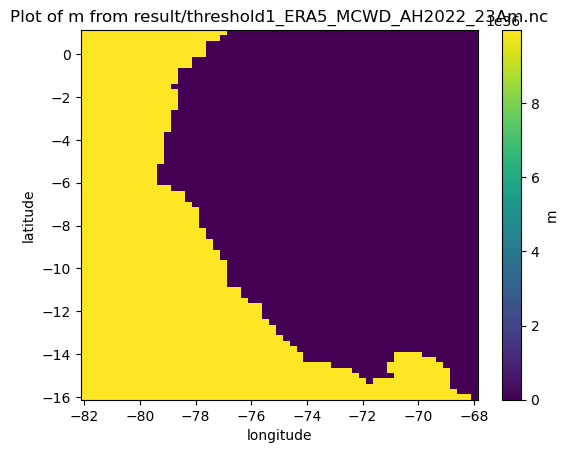

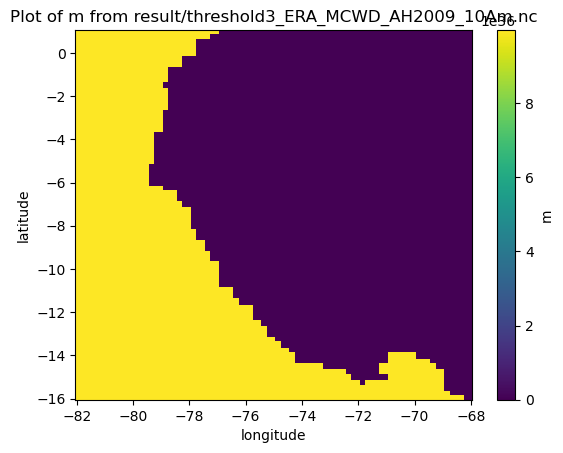

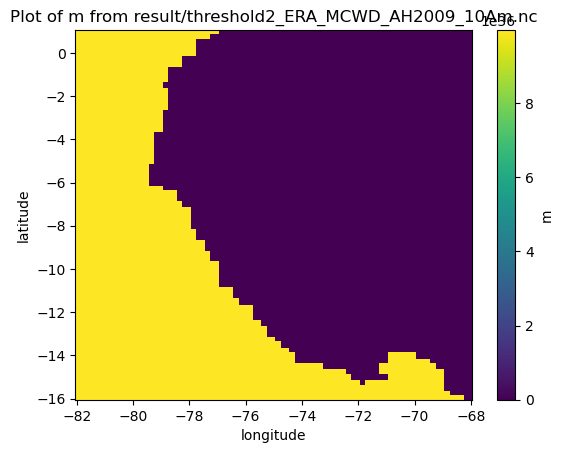

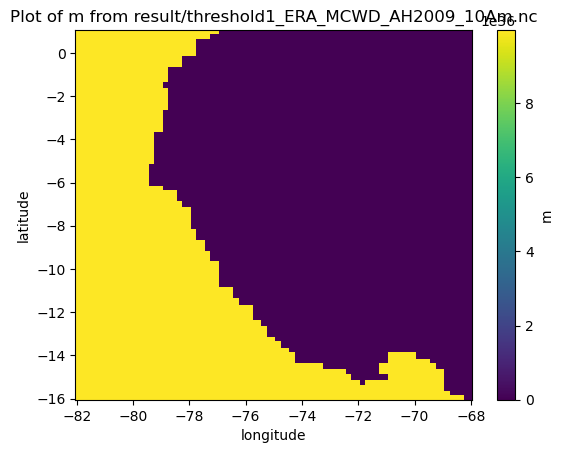

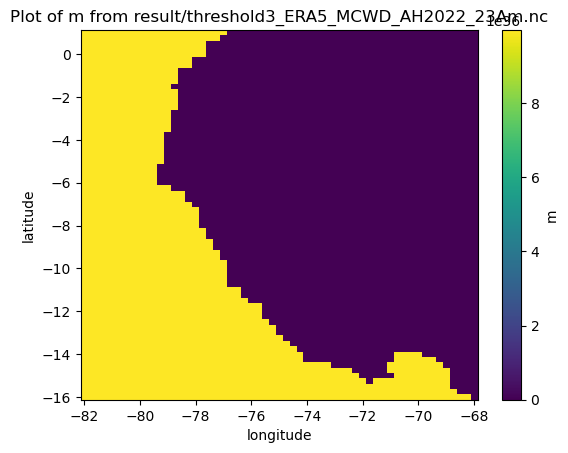

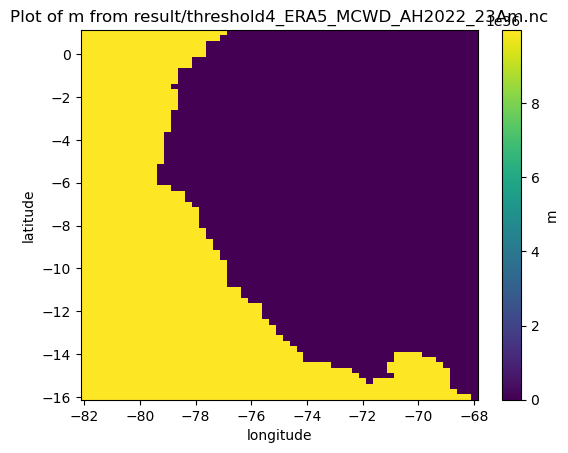

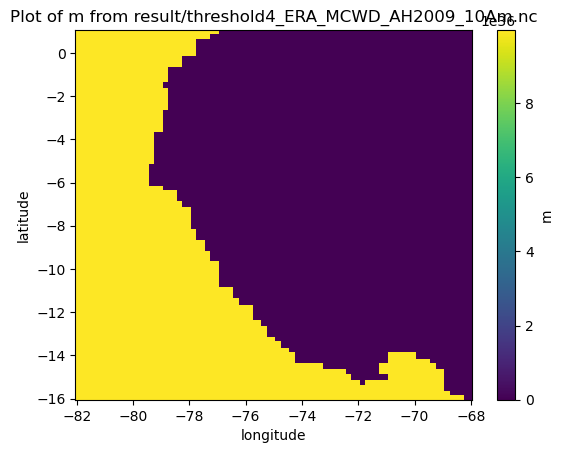

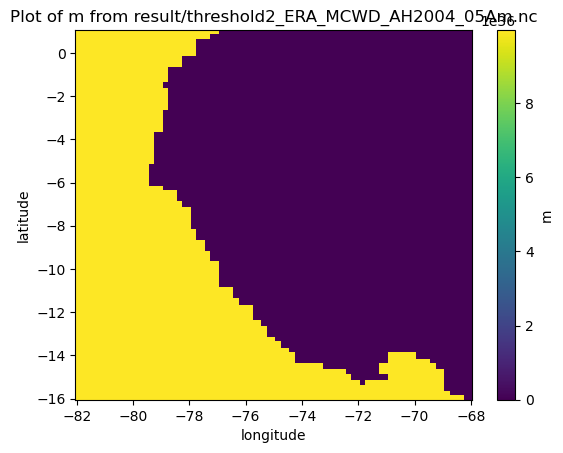

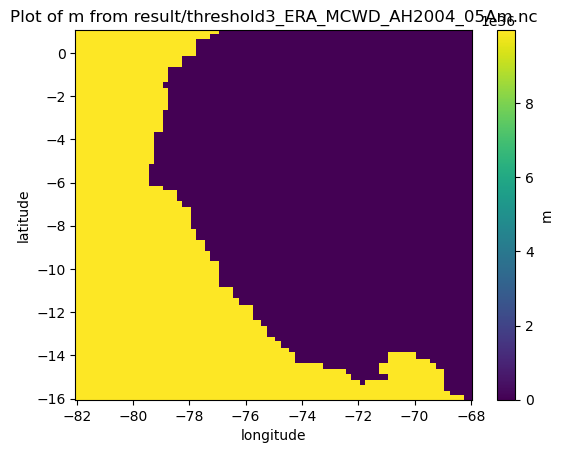

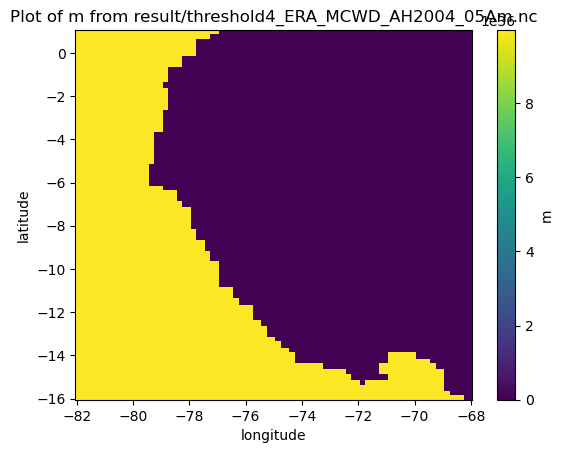

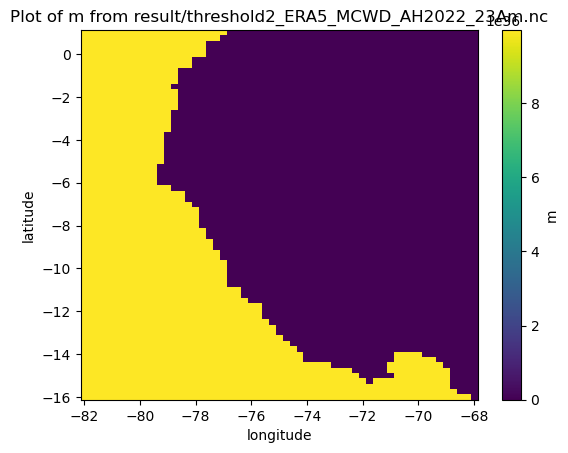

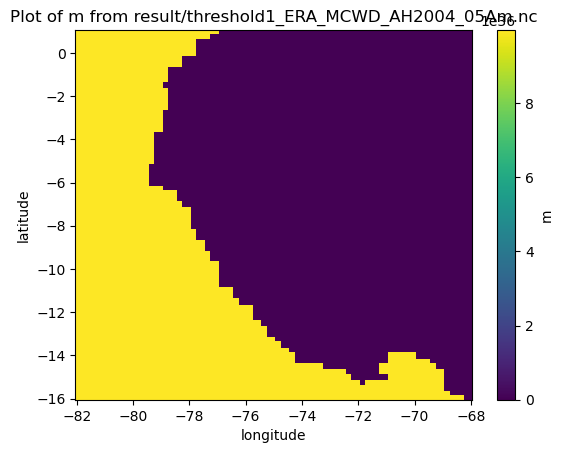

In [2]:
import glob
import xarray as xr
import matplotlib.pyplot as plt

# Buscar todos los archivos .nc en el directorio results
nc_files = glob.glob('result/*.nc')

# Iterar sobre cada archivo encontrado y plotear
for nc_file in nc_files:
    ds = xr.open_dataset(nc_file)
    variable_name = list(ds.data_vars)[0]  # Suponiendo que hay solo una variable principal en el dataset
    plt.figure()
    ds[variable_name].sel(time=ds.time[0]).plot()
    plt.title(f'Plot of {variable_name} from {nc_file}')
    plt.show()


# empieza script 

/tmp/ipykernel_88479/2499187552.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<Figure size 640x480 with 0 Axes>

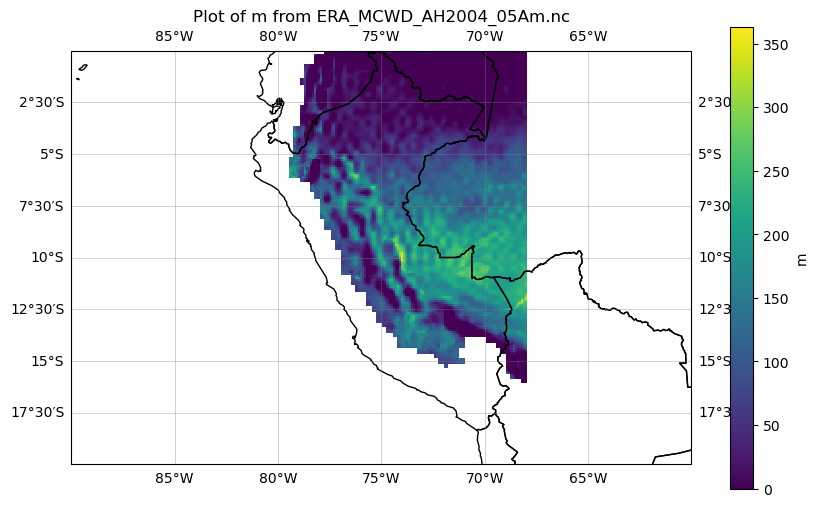

<Figure size 640x480 with 0 Axes>

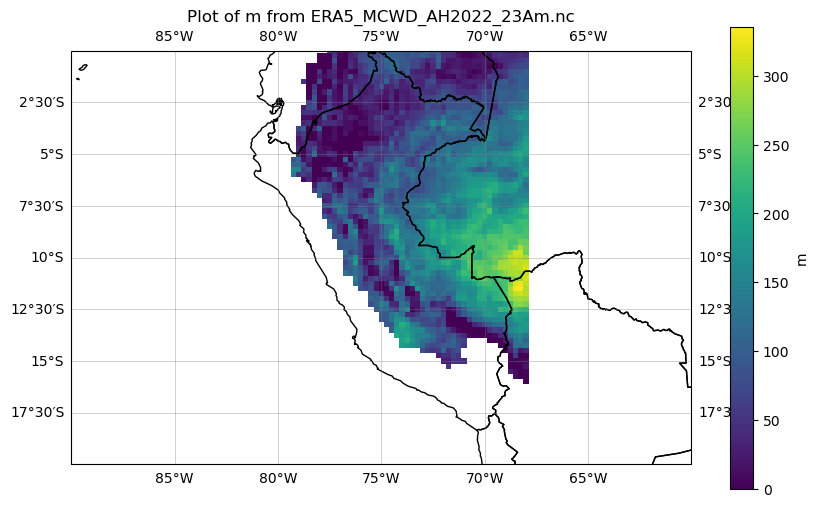

<Figure size 640x480 with 0 Axes>

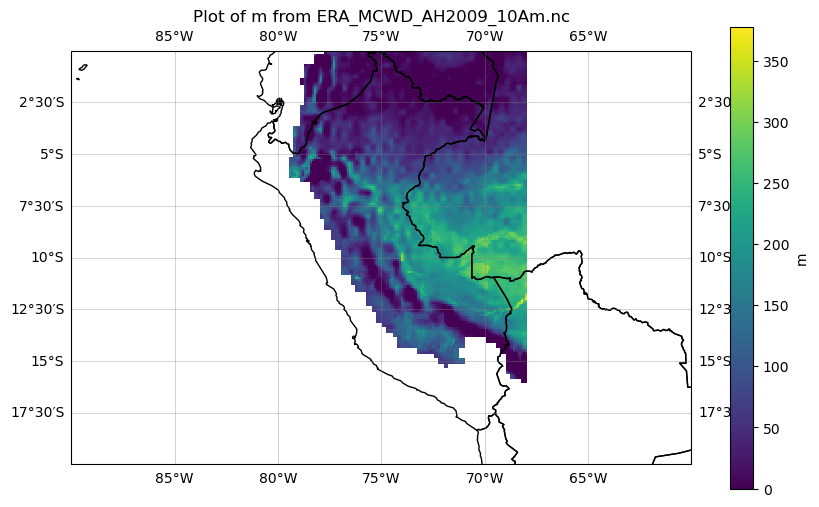

In [3]:
import glob
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# Buscar todos los archivos .nc en el directorio results
nc_files = glob.glob('*m.nc')

# Iterar sobre cada archivo encontrado y plotear
for nc_file in nc_files:
    ds = xr.open_dataset(nc_file)
    variable_name = list(ds.data_vars)[1]  # Suponiendo que hay solo una variable principal en el dataset
    plt.figure()
    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file('~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp')
    # Configurar el tamaño del gráfico y la proyección
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-90, -60, -20, 0], crs=ccrs.PlateCarree())
    # Dibujar los shapefiles de los países
    gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    # Agregar barra de color
    # Agregar etiquetas y título
    plt.title('Anomalia de Temperatura Superficial del Mar (SST)')
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.5)
    
    ds[variable_name].sel(time=ds.time[0]).plot()
    plt.title(f'Plot of {variable_name} from {nc_file}')
    plt.show()


In [4]:
import xarray as xr
import numpy as np
import os
import pandas as pd

# Define paths and filenames
data_dir = "/home/mandrade/DMARTINEZ"
output_dir = "Results"
filenames = ["ERA5_MCWD_AH2022_23Am", "ERA_MCWD_AH2004_05Am", "ERA_MCWD_AH2009_10Am"]
km = 111

# Create output directory if it doesn't exist
os.makedirs(os.path.join(data_dir, output_dir), exist_ok=True)

def process_threshold(data, lower_bound, upper_bound=None):
    if upper_bound:
        mask = (data >= lower_bound) & (data <= upper_bound)
    else:
        mask = (data >= lower_bound)
    thresholded_data = xr.where(mask, data, 0)
    return thresholded_data

def calculate_area(grid_res, km_factor):
    return grid_res**2 * km_factor**2

for file in filenames:
    print(f"Processing file: {file}")
    ds = xr.open_dataset(os.path.join(data_dir, f"{file}.nc"))

    # Seleccionar la variable numérica 'm'
    data = ds['m']

    # Si hay una dimensión de tiempo, promediar sobre el tiempo
    if 'time' in data.dims:
        print("Data has a time dimension. Applying mean over time.")
        data = data.mean(dim='time')

    # Process Threshold 1
    threshold1 = process_threshold(data, 110, 140)
    threshold1_sum = threshold1.sum(dim=['latitude', 'longitude'])
    threshold1_area = calculate_area(ds.attrs.get('xinc', 1), km)
    threshold1_km2 = threshold1_sum * threshold1_area
    
    threshold1.to_netcdf(os.path.join(data_dir, output_dir, f"threshold1_{file}.nc"))

    # Process Threshold 2
    threshold2 = process_threshold(data, 140, 200)
    threshold2_sum = threshold2.sum(dim=['latitude', 'longitude'])
    threshold2_km2 = threshold2_sum * threshold1_area

    threshold2.to_netcdf(os.path.join(data_dir, output_dir, f"threshold2_{file}.nc"))

    # Process Threshold 3
    threshold3 = process_threshold(data, 200)
    threshold3_sum = threshold3.sum(dim=['latitude', 'longitude'])
    threshold3_km2 = threshold3_sum * threshold1_area

    threshold3.to_netcdf(os.path.join(data_dir, output_dir, f"threshold3_{file}.nc"))

    # Process Threshold 4
    threshold4 = process_threshold(data, 30, 110)
    threshold4_sum = threshold4.sum(dim=['latitude', 'longitude'])
    threshold4_km2 = threshold4_sum * threshold1_area

    threshold4.to_netcdf(os.path.join(data_dir, output_dir, f"threshold4_{file}.nc"))

    # Save results to CSV
    result_df = pd.DataFrame({
        'Threshold': [1, 2, 3, 4],
        'GPoints': [threshold1_sum.values, threshold2_sum.values, threshold3_sum.values, threshold4_sum.values],
        'km2': [threshold1_km2.values, threshold2_km2.values, threshold3_km2.values, threshold4_km2.values]
    })
    result_df.to_csv(os.path.join(data_dir, output_dir, f"{file}_results.csv"), index=False)

print("Processing complete.")


Processing file: ERA5_MCWD_AH2022_23Am
Data has a time dimension. Applying mean over time.
Processing file: ERA_MCWD_AH2004_05Am
Data has a time dimension. Applying mean over time.
Processing file: ERA_MCWD_AH2009_10Am
Data has a time dimension. Applying mean over time.
Processing complete.


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import os

# Define paths and filenames
data_dir = "/home/mandrade/DMARTINEZ"
output_dir = "Results"
filenames = ["ERA5_MCWD_AH2022_23Am", "ERA_MCWD_AH2004_05Am", "ERA_MCWD_AH2009_10Am"]

# Umbrales que hemos procesado
thresholds = ['threshold1', 'threshold2', 'threshold3', 'threshold4']

# Crear un gráfico para cada archivo y umbral
for file in filenames:
    plt.figure(figsize=(12, 8))
    
    for threshold in thresholds:
        # Cargar los datos desde los archivos NetCDF generados
        ds = xr.open_dataset(os.path.join(data_dir, output_dir, f"{threshold}_{file}.nc"))
        data = ds.to_array().squeeze()

        # Crear el plot para el umbral
        plt.plot(data.latitude, data.mean(dim='longitude'), label=threshold)

    plt.title(f"Suma de datos por umbrales para {file}")
    plt.xlabel("Latitud")
    plt.ylabel("Promedio de valores")
    plt.legend()
    plt.grid(True)
    plt.show()


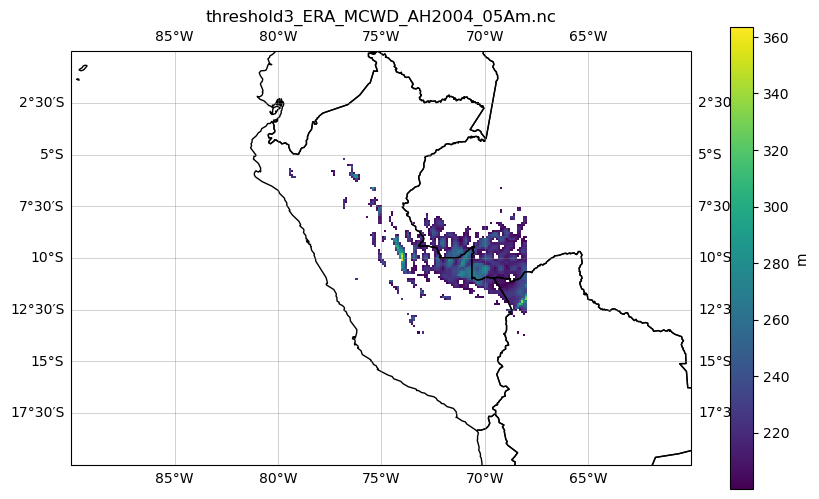

In [41]:
varname='Results/threshold3_ERA_MCWD_AH2004_05Am.nc'
dsT1 = xr.open_dataset(f'{varname}')

# Cargar el shapefile usando Geopandas
gdf = gpd.read_file('~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp')
# Configurar el tamaño del gráfico y la proyección
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-90, -60, -20, 0], crs=ccrs.PlateCarree())
# Dibujar los shapefiles de los países
gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
# Agregar barra de color
# Agregar etiquetas y título
dsT1.where(dsT1.m.values>0).m.plot()
varname= varname.split('/')[-1]
plt.title(f'{varname}')
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.5)


<AxesSubplot: >

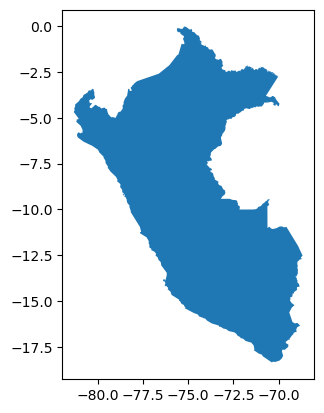

In [42]:
gdf[gdf.COUNTRY=='Peru'].plot()

In [43]:
import geopandas as gpd
import rioxarray
import xarray as xr
import numpy as np

# Filtrar el GeoDataFrame para la zona de Perú
gdf_peru = gdf[gdf.COUNTRY == 'Peru']

# Definir las características del raster
resolution = 0.01  # Ajusta esta resolución según sea necesario (0.01 equivale a 1km aproximadamente)
xmin, ymin, xmax, ymax = gdf_peru.total_bounds
ncols = int((xmax - xmin) / resolution)
nrows = int((ymax - ymin) / resolution)

# Crear una cuadrícula de coordenadas
x_coords = np.linspace(xmin, xmax, ncols)
y_coords = np.linspace(ymin, ymax, nrows)

# Crear una matriz vacía para almacenar los valores rasterizados
raster = np.zeros((nrows, ncols))

# Rasterizar la geometría de Perú
from rasterio.features import rasterize

shapes = ((geom, 1) for geom in gdf_peru.geometry)
raster = rasterize(shapes, out_shape=raster.shape, transform=(resolution, 0, xmin, 0, resolution, ymin))

# Crear un DataArray de xarray
da = xr.DataArray(
    raster,
    dims=("lat", "lon"),
    coords={"lat": y_coords, "lon": x_coords},
)

# Definir los atributos espaciales
da.rio.write_crs("EPSG:4326", inplace=True)

# Exportar el DataArray a NetCDF
output_netcdf = 'peru_high_res.nc'
da.to_netcdf(output_netcdf)

print(f'Archivo NetCDF exportado: {output_netcdf}')


Archivo NetCDF exportado: peru_high_res.nc


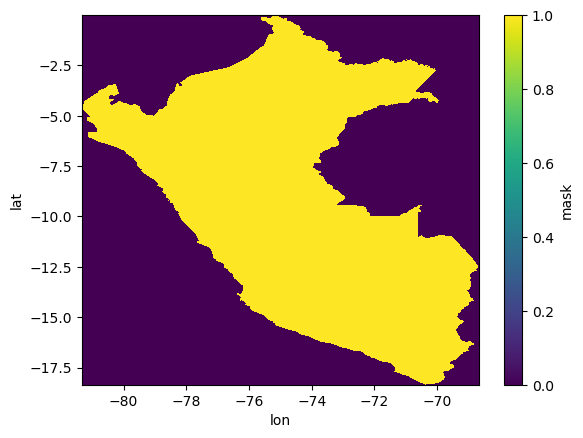

In [51]:
dsPeru = xr.open_dataset('peru_high_res.nc')
dsPeru = dsPeru.rename({'__xarray_dataarray_variable__':'mask'})
dsPeru = dsPeru[['mask']]
dsPeru.mask.plot() 
dsPeru.to_netcdf('Peru_mask.nc')

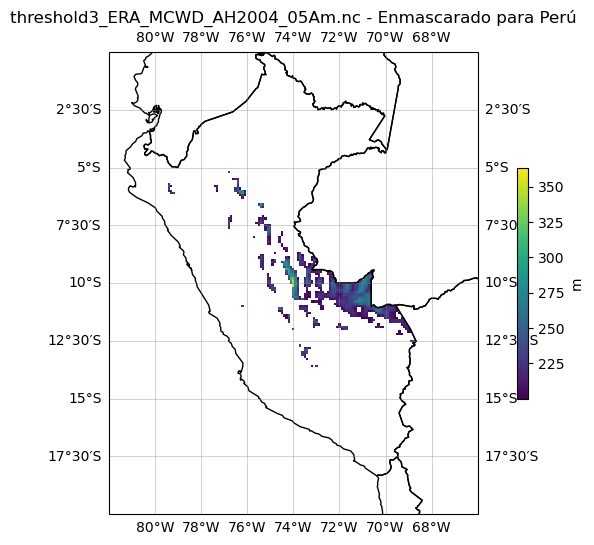

In [5]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import rioxarray

# Archivo de datos NetCDF y shapefile de países
varname = 'Results/threshold3_ERA_MCWD_AH2004_05Am.nc'
dsT1 = xr.open_dataset(f'{varname}')

# Configurar el CRS (EPSG:4326 es el sistema de referencia geográfica WGS 84)
dsT1 = dsT1.rio.write_crs("EPSG:4326")

# Cargar el shapefile usando Geopandas
gdf = gpd.read_file('~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp')

# Seleccionar la geometría de Perú
peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

# Convertir la geometría a una lista para usar en el enmascaramiento
geometries = [peru_shape]

# Convertir la geometría a una máscara para xarray
masked_data = dsT1.rio.clip(geometries, drop=True)

# Configurar el tamaño del gráfico y la proyección
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-82, -66, -20, 0], crs=ccrs.PlateCarree())

# Dibujar los shapefiles de los países
gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

# Plotear los datos enmascarados
masked_data.where(masked_data.m.values>0).m.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})

# Configuración de la barra de color, etiquetas y título
plt.title(f'{varname.split("/")[-1]} - Enmascarado para Perú')
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.5)

plt.show()


In [14]:
import xarray as xr
import rioxarray

def maskedAmazon(file,ruta,masked_data):
    # Cargar el dataset original
    ds_F1 = xr.open_dataset(f'{file}')

    # Configurar el CRS para el dataset original (asegurándote de que coincide con el de la máscara)
    ds_F1 = ds_F1.rio.write_crs("EPSG:4326")

    # Aplicar la máscara
    masked_data = ds_F1.where(masked_data.m.notnull(), drop=True)

    # Asignar los valores enmascarados al dataset original
    ds_F1['m'] = masked_data.m

    # Guardar el dataset enmascarado
    ds_F1.to_netcdf(f'{ruta}{file}_masked.nc')

    # Verificación de la aplicación de la máscara
    print(ds_F1)

file='ERA_MCWD_AH2004_05Am.nc'
ruta='./ERA_masked/'

maskedAmazon(file,ruta,masked_data)

<xarray.Dataset> Size: 98kB
Dimensions:      (time: 1, longitude: 141, latitude: 171, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 8B 2005-02-15
  * longitude    (longitude) float32 564B -82.0 -81.9 -81.8 ... -68.1 -68.0
  * latitude     (latitude) float32 684B 1.0 0.9 0.8 0.7 ... -15.8 -15.9 -16.0
    spatial_ref  int64 8B 0
Dimensions without coordinates: bnds
Data variables:
    time_bnds    (time, bnds) datetime64[ns] 16B ...
    m            (time, latitude, longitude) float32 96kB nan nan ... nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 06 16:46:15 2024: cdo sellonlatbox,-82,-68,-16,1 -i...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...


In [6]:
dsMasked1 = xr.open_dataset(f'./ERA_masked/ERA_MCWD_AH2004_05Am.nc_masked.nc')
dsMasked1.m.plot()

FileNotFoundError: [Errno 2] No such file or directory: b'/home/mandrade/DMARTINEZ/ERA_masked/ERA_MCWD_AH2004_05Am.nc_masked.nc'

# enmascarando la amazonia peruana

total area:942737.2817209493
Área total en ERA_MCWD_AH2004_05Am.nc: 942737.28 km²


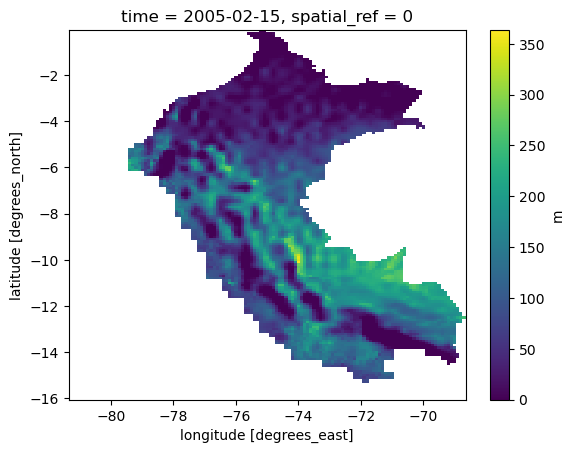

total area:942737.2817209493
Área total en ERA_MCWD_AH2009_10Am.nc: 942737.28 km²


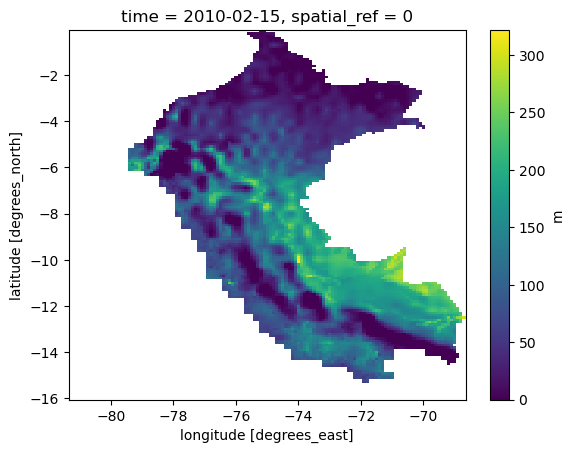

total area:932545.6875
Área total en ERA5_MCWD_AH2022_23Am.nc: 932545.69 km²


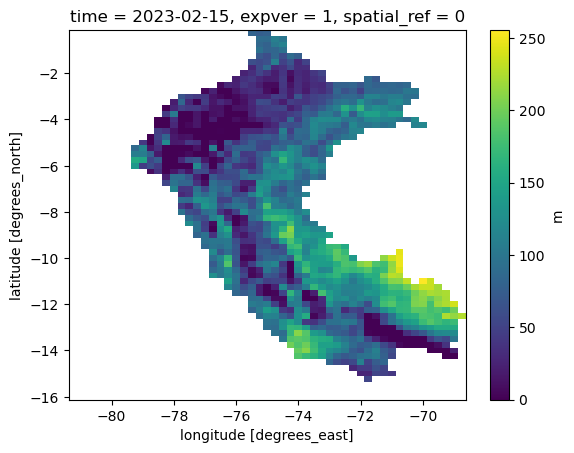

In [16]:
import xarray as xr
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

def filter_data_for_peru(nc_file, shapefile, crs="EPSG:4326"):
    """
    Filtra un dataset NetCDF espacialmente para Perú utilizando un shapefile.

    Parámetros:
    nc_file (str): Ruta al archivo NetCDF que se desea filtrar.
    shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
    crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

    Retorna:
    masked_data (xarray.Dataset): Dataset filtrado para la región de Perú.
    """
    # Cargar el dataset NetCDF
    ds = xr.open_dataset(nc_file)
    ds = ds[['m']]

    # Renombrar dimensiones si es necesario
    if 'longitude' in ds.dims and 'latitude' in ds.dims:
        ds = ds.rename({'longitude': 'x', 'latitude': 'y'})
    elif 'lon' in ds.dims and 'lat' in ds.dims:
        ds = ds.rename({'lon': 'x', 'lat': 'y'})
    else:
        # Inferir las dimensiones espaciales
        possible_x_dims = ['lon', 'longitude', 'x']
        possible_y_dims = ['lat', 'latitude', 'y']
        x_dim = next((dim for dim in ds.dims if dim in possible_x_dims), None)
        y_dim = next((dim for dim in ds.dims if dim in possible_y_dims), None)
        if x_dim and y_dim:
            ds = ds.rename({x_dim: 'x', y_dim: 'y'})
        else:
            raise ValueError("No se encontraron dimensiones espaciales reconocidas en el dataset.")

    # Configurar el CRS para el dataset
    ds = ds.rio.write_crs(crs)

    # Configurar las dimensiones espaciales si no están correctamente identificadas
    ds = ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file(shapefile)

    # Seleccionar la geometría de Perú
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

    # Aplicar el enmascaramiento utilizando la geometría de Perú
    masked_data = ds.rio.clip([peru_shape], drop=True)

    return masked_data

def calculate_area(masked_data):
    """
    Calcula el área total del dataset enmascarado basado en su resolución.

    Parámetros:
    masked_data (xarray.Dataset): Dataset enmascarado.

    Retorna:
    total_area (float): Área total en kilómetros cuadrados.
    """
    # Asumir que la resolución espacial es la misma en ambas dimensiones
    res_lat = (masked_data.y[1] - masked_data.y[0]).values
    res_lon = (masked_data.x[1] - masked_data.x[0]).values
    # Calcular área de una celda en km²
    area_per_cell = abs(res_lat * res_lon) * 111**2
    # Contar el número de celdas con datos válidos
    valid_cells = masked_data.notnull().sum().values
    # Calcular el área total
    total_area = valid_cells * area_per_cell
    print(f'total area:{total_area}')
    return total_area

# Ejemplo de uso de la función
shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'

for nc_file in ['ERA_MCWD_AH2004_05Am.nc', 'ERA_MCWD_AH2009_10Am.nc', 'ERA5_MCWD_AH2022_23Am.nc']:
    masked_data = filter_data_for_peru(nc_file, shapefile)
    masked_data.to_netcdf(f'ERA_masked/{nc_file.split(".")[0]}_masked_peru.nc')
    total_area = calculate_area(masked_data.m)
    print(f"Área total en {nc_file}: {total_area:.2f} km²")
    masked_data.m.plot()
    plt.show()


In [17]:
def calculate_area(masked_data):
    """
    Calcula el área total del dataset enmascarado basado en su resolución.

    Parámetros:
    masked_data (xarray.Dataset): Dataset enmascarado.

    Retorna:
    total_area (float): Área total en kilómetros cuadrados.
    """
    # Asumir que la resolución espacial es la misma en ambas dimensiones
    res_lat = (masked_data.latitude[1] - masked_data.latitude[0]).values
    res_lon = (masked_data.longitude[1] - masked_data.longitude[0]).values
    # Calcular área de una celda en km²
    area_per_cell = abs(res_lat * res_lon) * 111**2
    # Contar el número de celdas con datos válidos
    valid_cells = masked_data.notnull().sum().values
    # Calcular el área total
    total_area = valid_cells * area_per_cell
    print(f'total area:{total_area}')
    return total_area

ds1= xr.open_dataset('ERA_masked/Results/threshold1_ERA_MCWD_AH2004_05Am_masked_peru2.nc')
calculate_area(ds1.m)


ds1= xr.open_dataset('ERA_masked/Results/threshold1_ERA_MCWD_AH2009_10Am_masked_peru2.nc')
calculate_area(ds1.m)


ds1= xr.open_dataset('ERA_masked/Results/threshold1_ERA5_MCWD_AH2022_23Am_masked_peru2.nc')
calculate_area(ds1.m)



ds1= xr.open_dataset('ERA_masked/Results/threshold3_ERA5_MCWD_AH2022_23Am_masked_peru2.nc')
calculate_area(ds1.m)



# si me da el area del peru
# ds1= xr.open_dataset('ERA_masked/Results/threshold5_ERA_MCWD_AH2004_05Am_masked_peru2.nc')
# maskeddata1=filter_data_for_peru('ERA_masked/Results/threshold5_ERA_MCWD_AH2004_05Am_masked_peru2.nc', shapefile)
# maskeddata1=maskeddata1.rename({'x':'longitude','y':'latitude'})
# calculate_area(maskeddata1.m)

total area:97218.62701317854
total area:78489.56325398572
total area:137841.1875
total area:32342.625


32342.625

In [18]:
import glob
import xarray as xr
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

file_pattern = 'ERA_masked/*.nc'
files = glob.glob(file_pattern)

# Inicializar una lista para almacenar los resultados
for each in files:
    try:
        print('procesando archivo',each)
        ds1= xr.open_dataset(each)
        calculate_area(ds1.m)
    except:
        print('error en el archivo : ',each)


##############

file_pattern = 'ERA_masked/Results/*.nc'
files = glob.glob(file_pattern)

# Inicializar una lista para almacenar los resultados
for each in files:
    print('procesando archivo',each)
    ds1= xr.open_dataset(each)
    calculate_area(ds1.m)

procesando archivo ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru2.nc
total area:932545.6875
procesando archivo ERA_masked/ERA_MCWD_AH2004_05Am.nc_masked.nc
total area:942665.5541132642
procesando archivo ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru.nc
error en el archivo :  ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru.nc
procesando archivo ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru.nc
error en el archivo :  ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru.nc
procesando archivo ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru.nc
error en el archivo :  ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru.nc
procesando archivo ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru2.nc
total area:942737.2817209493
procesando archivo ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru2.nc
total area:942737.2817209493
procesando archivo ERA_masked/Results/threshold3_ERA5_MCWD_AH2022_23Am_masked_peru2.nc
total area:32342.625
procesando archivo ERA_masked/Results/threshold1_ERA5_MCWD_AH2022_23Am_masked_peru2.nc
total area:137841.1

In [19]:
# import xarray as xr
# import numpy as np
# import pandas as pd
# import glob
# import os

# def calculate_area(masked_data):
#     """
#     Calcula el área total del dataset enmascarado usando el dataset ya recortado para Perú.

#     Parámetros:
#     masked_data (xarray.DataArray): Dataset enmascarado.

#     Retorna:
#     total_area (float): Área total en kilómetros cuadrados.
#     """
#     # Reproyectar los datos a una proyección que use metros como unidad
#     reprojected = masked_data.rio.reproject("EPSG:3857")

#     # Obtener la resolución del raster en metros
#     res_x, res_y = reprojected.rio.resolution()

#     # Calcular el área de cada celda en metros cuadrados
#     cell_area_m2 = abs(res_x * res_y)

#     # Contar el número de celdas válidas
#     valid_cells = np.count_nonzero(~np.isnan(reprojected))

#     # Calcular el área total en kilómetros cuadrados
#     total_area_km2 = (cell_area_m2 * valid_cells) / 1e6

#     return total_area_km2

# # Ruta a los archivos NetCDF
# file_pattern = 'ERA_masked/Results/*.nc'
# files = glob.glob(file_pattern)
# print(files)
# # Inicializar una lista para almacenar los resultados
# results = []

# # Iterar sobre cada archivo y calcular el área
# for file in files:
#     ds = xr.open_dataset(file)
#     area = calculate_area(ds.m)
    
#     # Extraer la información de threshold y ERA del nombre del archivo
#     filename = os.path.basename(file)
#     threshold = filename.split('_')[0]
#     era_type = '_'.join(filename.split('_')[2:4])
    
#     # Agregar los resultados a la lista
#     results.append({
#         'Archivo': filename,
#         'Threshold': threshold,
#         'ERA': era_type,
#         'Área (km²)': area
#     })

# # Convertir los resultados a un DataFrame
# df_results = pd.DataFrame(results)

# # Guardar el DataFrame en un archivo Excel
# output_file = 'area_calculations.xlsx'
# df_results.to_excel(output_file, index=False)

# print(f"Resultados guardados en {output_file}")


In [20]:
# import xarray as xr
# import geopandas as gpd
# import rioxarray
# import numpy as np
# import matplotlib.pyplot as plt

# def filter_data_for_peru(nc_file, shapefile, crs="EPSG:4326"):
#     """
#     Filtra un dataset NetCDF espacialmente para Perú utilizando un shapefile.

#     Parámetros:
#     nc_file (str): Ruta al archivo NetCDF que se desea filtrar.
#     shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
#     crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

#     Retorna:
#     masked_data (xarray.Dataset): Dataset filtrado para la región de Perú.
#     """
#     # Cargar el dataset NetCDF
#     ds = xr.open_dataset(nc_file)
#     ds = ds[['m']]

#     # Renombrar dimensiones si es necesario
#     if 'longitude' in ds.dims and 'latitude' in ds.dims:
#         ds = ds.rename({'longitude': 'x', 'latitude': 'y'})
#     elif 'lon' in ds.dims and 'lat' in ds.dims:
#         ds = ds.rename({'lon': 'x', 'lat': 'y'})
#     else:
#         # Inferir las dimensiones espaciales
#         possible_x_dims = ['lon', 'longitude', 'x']
#         possible_y_dims = ['lat', 'latitude', 'y']
#         x_dim = next((dim for dim in ds.dims if dim in possible_x_dims), None)
#         y_dim = next((dim for dim in ds.dims if dim in possible_y_dims), None)
#         if x_dim and y_dim:
#             ds = ds.rename({x_dim: 'x', y_dim: 'y'})
#         else:
#             raise ValueError("No se encontraron dimensiones espaciales reconocidas en el dataset.")

#     # Configurar el CRS para el dataset
#     ds = ds.rio.write_crs(crs)

#     # Configurar las dimensiones espaciales si no están correctamente identificadas
#     ds = ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

#     # Cargar el shapefile usando Geopandas
#     gdf = gpd.read_file(shapefile)

#     # Reproyectar el shapefile al CRS del dataset
#     gdf = gdf.to_crs(crs)

#     # Seleccionar la geometría de Perú
#     peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

#     # Aplicar el enmascaramiento utilizando la geometría de Perú
#     masked_data = ds.rio.clip([peru_shape], drop=True)

#     return masked_data

# def calculate_area_using_mask(masked_data):
#     """
#     Calcula el área total del dataset enmascarado usando el dataset ya recortado para Perú.

#     Parámetros:
#     masked_data (xarray.DataArray): Dataset enmascarado.

#     Retorna:
#     total_area (float): Área total en kilómetros cuadrados.
#     """
#     # Reproyectar los datos a una proyección que use metros como unidad
#     reprojected = masked_data.rio.reproject("EPSG:3857")

#     # Obtener la resolución del raster en metros
#     res_x, res_y = reprojected.rio.resolution()

#     # Calcular el área de cada celda en metros cuadrados
#     cell_area_m2 = abs(res_x * res_y)

#     # Contar el número de celdas válidas
#     valid_cells = np.count_nonzero(~np.isnan(reprojected))

#     # Calcular el área total en kilómetros cuadrados
#     total_area_km2 = (cell_area_m2 * valid_cells) / 1e6

#     print(f'total area (using mask): {total_area_km2}')
#     return total_area_km2

# # Ejemplo de uso de la función
# shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'

# for nc_file in ['ERA_MCWD_AH2004_05Am.nc', 'ERA_MCWD_AH2009_10Am.nc', 'ERA5_MCWD_AH2022_23Am.nc']:
#     masked_data = filter_data_for_peru(nc_file, shapefile)
#     masked_data.to_netcdf(f'ERA_masked/{nc_file.split(".")[0]}_masked_peru.nc')
#     total_area_mask = calculate_area_using_mask(masked_data.m)
#     print(f"Área total usando máscara en {nc_file}: {total_area_mask:.2f} km²")
#     masked_data.m.plot()
#     plt.show()


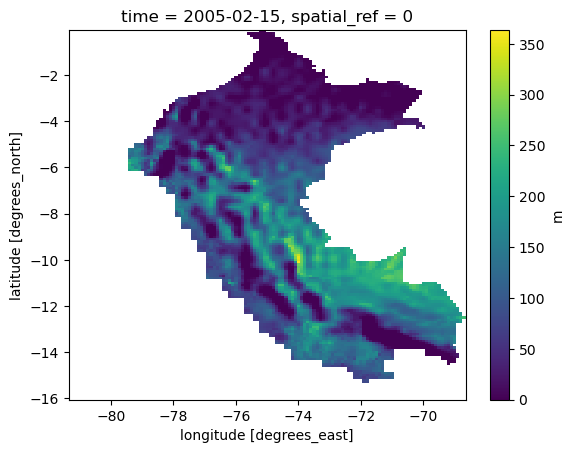

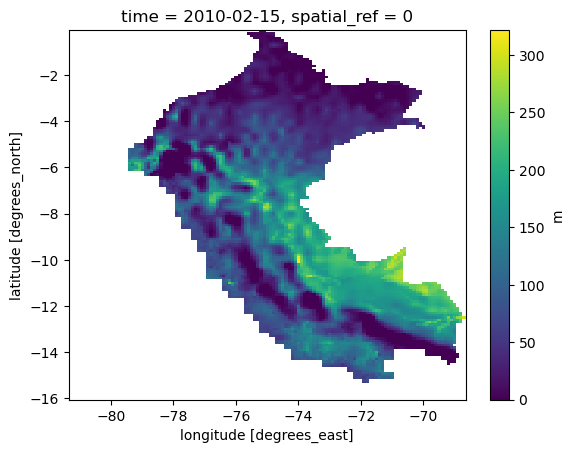

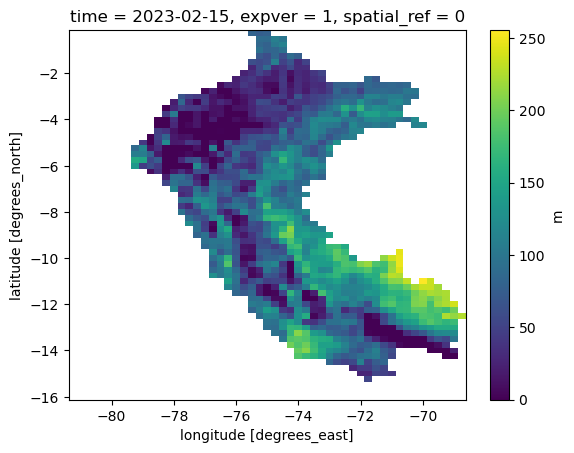

Processing file: ERA5_MCWD_AH2022_23Am_masked_peru2
Data has a time dimension. Applying mean over time.
Processing file: ERA_MCWD_AH2004_05Am_masked_peru2
Data has a time dimension. Applying mean over time.
Processing file: ERA_MCWD_AH2009_10Am_masked_peru2
Data has a time dimension. Applying mean over time.
Processing complete.


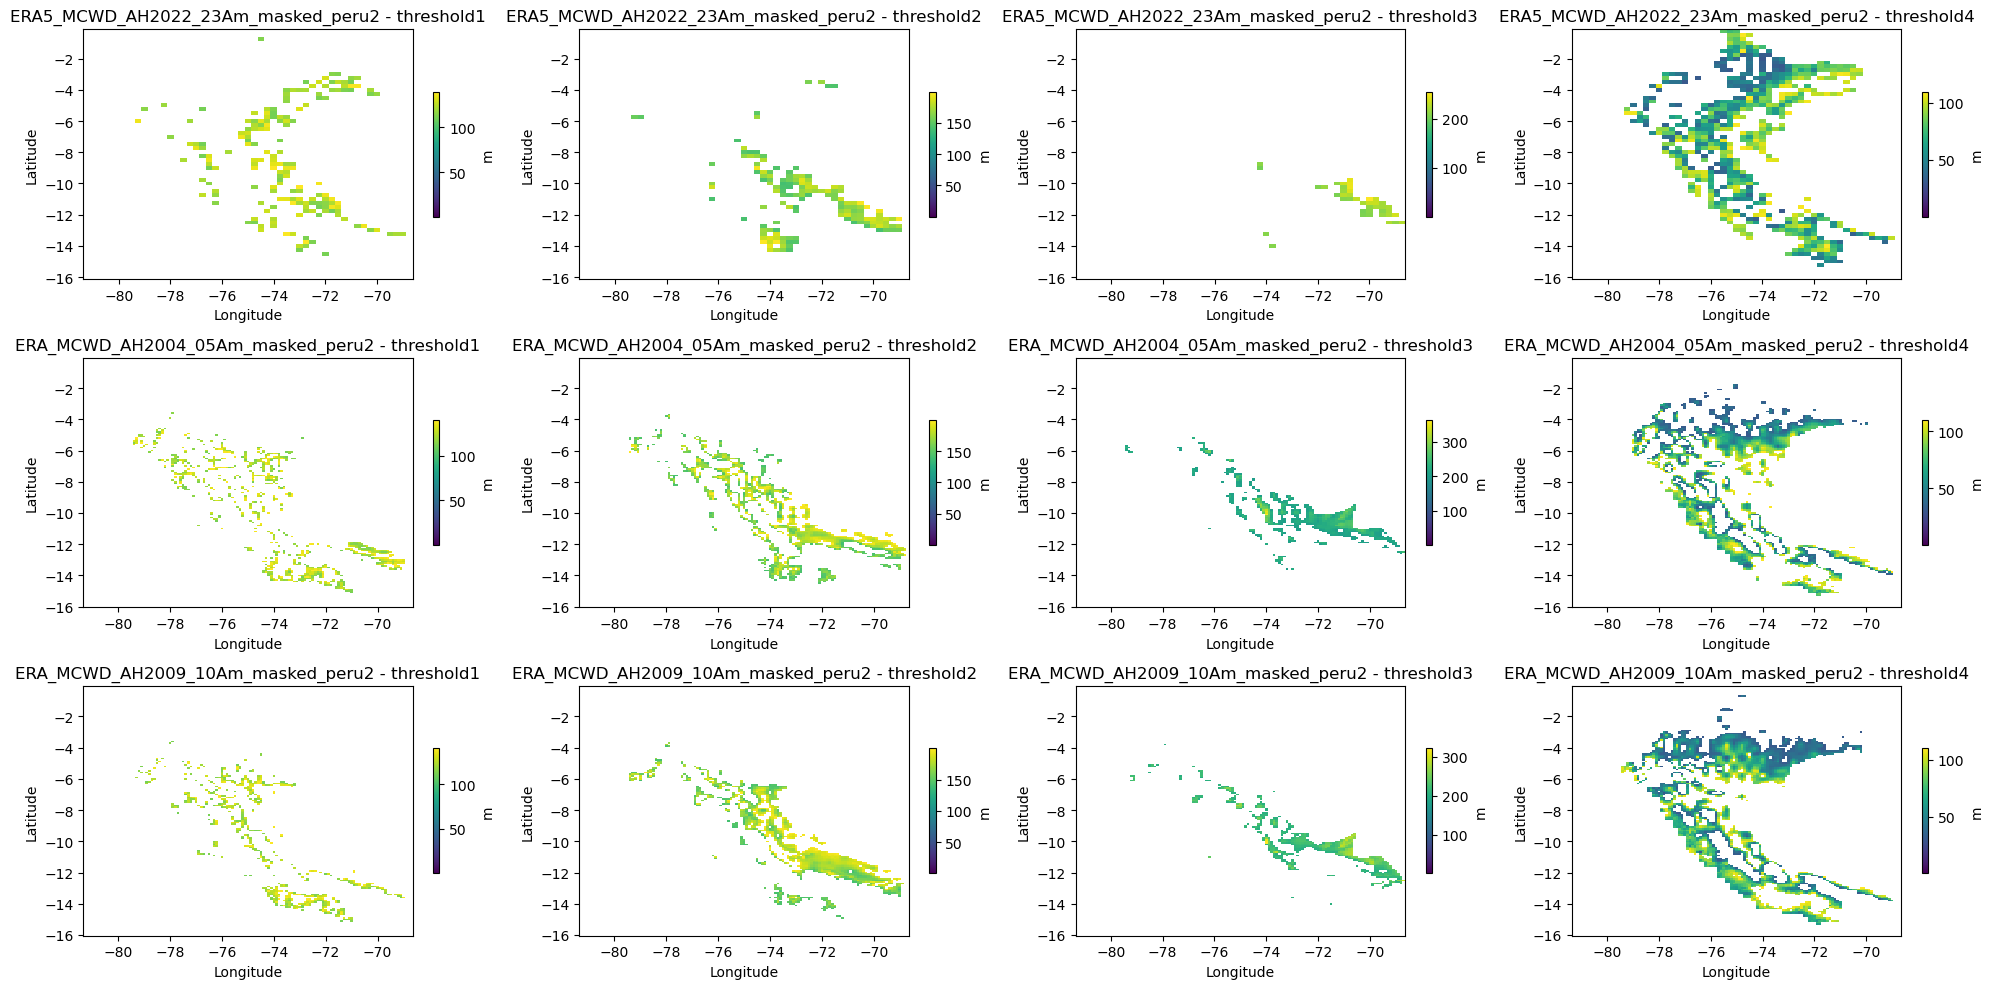

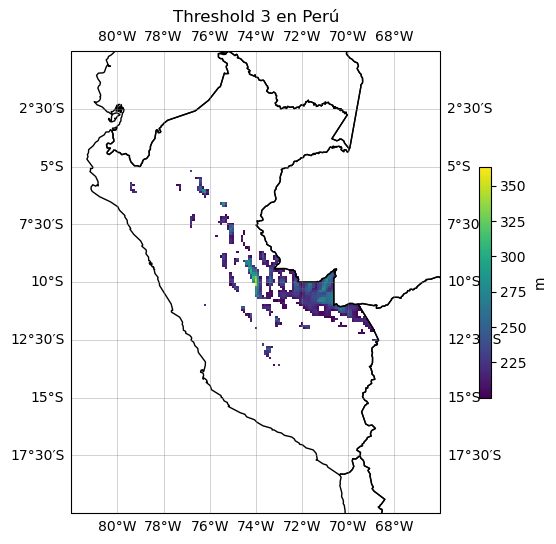

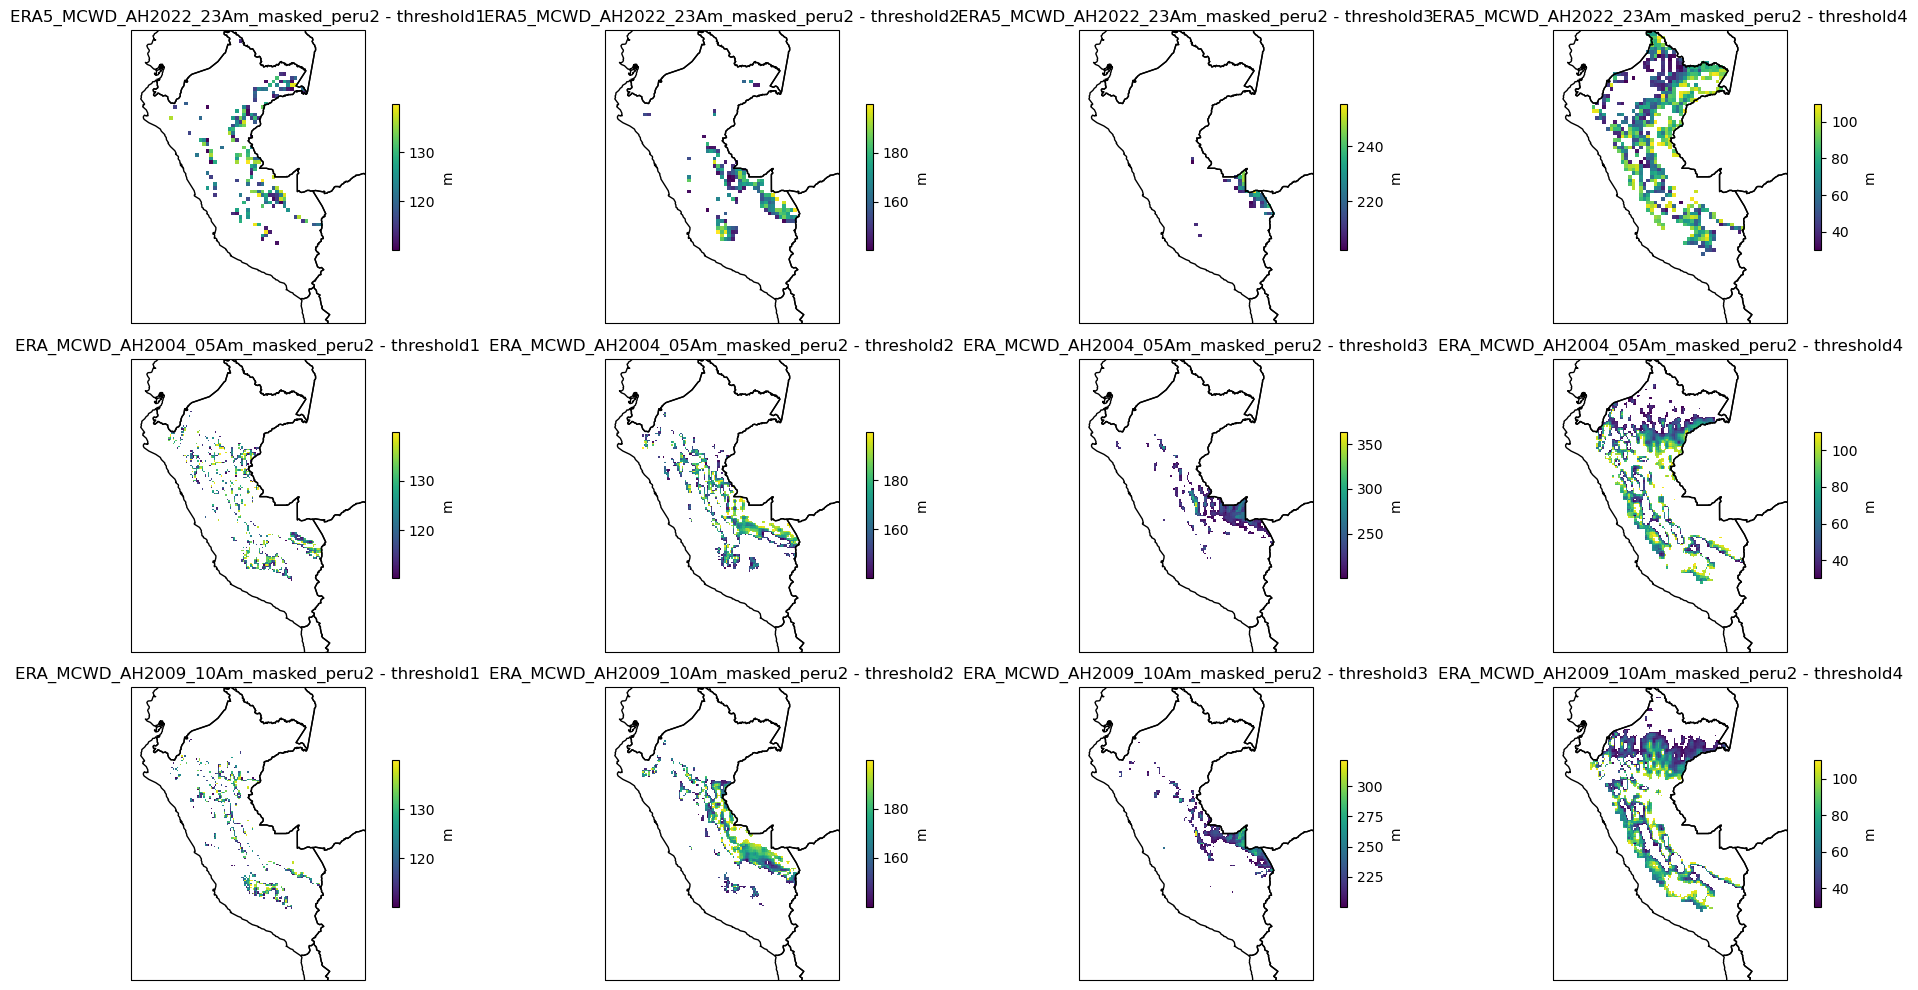

In [167]:
import xarray as xr
import geopandas as gpd
import rioxarray

def filter_data_for_peru(nc_file, shapefile, crs="EPSG:4326"):
    """
    Filtra un dataset NetCDF espacialmente para Perú utilizando un shapefile.

    Parámetros:
    nc_file (str): Ruta al archivo NetCDF que se desea filtrar.
    shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
    crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

    Retorna:
    masked_data (xarray.Dataset): Dataset filtrado para la región de Perú.
    """
    # Cargar el dataset NetCDF
    ds = xr.open_dataset(nc_file)
    ds = ds[['m']]
    # Intentar identificar las dimensiones espaciales comunes
    if 'longitude' in ds.dims and 'latitude' in ds.dims:
        ds = ds.rename({'longitude': 'x', 'latitude': 'y'})
    elif 'lon' in ds.dims and 'lat' in ds.dims:
        ds = ds.rename({'lon': 'x', 'lat': 'y'})
    else:
        # Intentar inferir las dimensiones espaciales automáticamente
        possible_x_dims = ['lon', 'longitude', 'x']
        possible_y_dims = ['lat', 'latitude', 'y']
        x_dim = next((dim for dim in ds.dims if dim in possible_x_dims), None)
        y_dim = next((dim for dim in ds.dims if dim in possible_y_dims), None)
        if x_dim and y_dim:
            ds = ds.rename({x_dim: 'x', y_dim: 'y'})
        else:
            raise ValueError("No se encontraron dimensiones espaciales reconocidas en el dataset.")

    # Configurar el CRS para el dataset
    ds = ds.rio.write_crs(crs)

    # Configurar las dimensiones espaciales si no están correctamente identificadas
    ds = ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file(shapefile)

    # Seleccionar la geometría de Perú
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

    # Convertir la geometría a una lista para usar en el enmascaramiento
    geometries = [peru_shape]

    # Aplicar el enmascaramiento utilizando la geometría de Perú
    masked_data = ds.rio.clip(geometries, drop=True)

    return masked_data

# Uso de la función
nc_file = 'ERA_MCWD_AH2004_05Am.nc'
shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
masked_data = filter_data_for_peru(nc_file, shapefile)
masked_data.to_netcdf('ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru.nc')
masked_data.m.plot()
plt.show()


nc_file = 'ERA_MCWD_AH2009_10Am.nc'
shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
masked_data = filter_data_for_peru(nc_file, shapefile)
masked_data.to_netcdf('ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru.nc')
masked_data.m.plot()
plt.show()


nc_file = 'ERA5_MCWD_AH2022_23Am.nc'
shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
masked_data = filter_data_for_peru(nc_file, shapefile)
masked_data.to_netcdf('ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru.nc')
masked_data.m.plot()
plt.show()




ds = xr.open_dataset('ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru.nc')
ds = ds.rename({'x':'longitude','y':'latitude'})
ds = ds[['m']]
ds.to_netcdf('ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru2.nc')


ds = xr.open_dataset('ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru.nc')
ds = ds.rename({'x':'longitude','y':'latitude'})
ds = ds[['m']]
ds.to_netcdf('ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru2.nc')



ds = xr.open_dataset('ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru.nc')
ds = ds.rename({'x':'longitude','y':'latitude'})
ds = ds[['m']]
ds.to_netcdf('ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru2.nc')

import xarray as xr
import numpy as np
import os
import pandas as pd

# Define paths and filenames
data_dir = "/home/mandrade/DMARTINEZ/ERA_masked/"
output_dir = "/home/mandrade/DMARTINEZ/ERA_masked/Results"
filenames = ["ERA5_MCWD_AH2022_23Am_masked_peru2", "ERA_MCWD_AH2004_05Am_masked_peru2", "ERA_MCWD_AH2009_10Am_masked_peru2"]
km = 111

# Create output directory if it doesn't exist
os.makedirs(os.path.join(data_dir, output_dir), exist_ok=True)

def process_threshold(data, lower_bound, upper_bound=None):
    if upper_bound:
        mask = (data >= lower_bound) & (data <= upper_bound)
    else:
        mask = (data >= lower_bound)
    thresholded_data = xr.where(mask, data, 0)
    return thresholded_data

def calculate_area(grid_res, km_factor):
    return grid_res**2 * km_factor**2

for file in filenames:
    print(f"Processing file: {file}")
    ds = xr.open_dataset(os.path.join(data_dir, f"{file}.nc"))

    # Seleccionar la variable numérica 'm'
    data = ds['m']

    # Si hay una dimensión de tiempo, promediar sobre el tiempo
    if 'time' in data.dims:
        print("Data has a time dimension. Applying mean over time.")
        data = data.mean(dim='time')

    # Process Threshold 1
    threshold1 = process_threshold(data, 110, 140)
    threshold1_sum = threshold1.sum(dim=['latitude', 'longitude'])
    threshold1_area = calculate_area(ds.attrs.get('xinc', 1), km)
    threshold1_km2 = threshold1_sum * threshold1_area
    threshold1=threshold1.where(threshold1>0)
    threshold1.to_netcdf(os.path.join(data_dir, output_dir, f"threshold1_{file}.nc"))

    # Process Threshold 2
    threshold2 = process_threshold(data, 140, 200)
    threshold2_sum = threshold2.sum(dim=['latitude', 'longitude'])
    threshold2_km2 = threshold2_sum * threshold1_area
    threshold2=threshold2.where(threshold2>0)
    threshold2.to_netcdf(os.path.join(data_dir, output_dir, f"threshold2_{file}.nc"))

    # Process Threshold 3
    threshold3 = process_threshold(data, 200)
    threshold3_sum = threshold3.sum(dim=['latitude', 'longitude'])
    threshold3_km2 = threshold3_sum * threshold1_area
    threshold3=threshold3.where(threshold3>0)
    threshold3.to_netcdf(os.path.join(data_dir, output_dir, f"threshold3_{file}.nc"))

    # Process Threshold 4
    threshold4 = process_threshold(data, 30, 110)
    threshold4_sum = threshold4.sum(dim=['latitude', 'longitude'])
    threshold4_km2 = threshold4_sum * threshold1_area
    threshold4=threshold4.where(threshold4>0)
    threshold4.to_netcdf(os.path.join(data_dir, output_dir, f"threshold4_{file}.nc"))
    
        # Process Threshold 5
    threshold5 = process_threshold(data, 0)
    threshold5_sum = threshold5.sum(dim=['latitude', 'longitude'])
    threshold5_km2 = threshold5_sum * threshold1_area
    threshold5.to_netcdf(os.path.join(data_dir, output_dir, f"threshold5_{file}.nc"))

    # Save results to CSV
    result_df = pd.DataFrame({
        'Threshold': [1, 2, 3, 4,5],
        'GPoints': [threshold1_sum.values, threshold2_sum.values, threshold3_sum.values, threshold4_sum.values,threshold5_sum.values],
        'km2': [threshold1_km2.values, threshold2_km2.values, threshold3_km2.values, threshold4_km2.values,threshold5_km2.values]
    })
    result_df.to_csv(os.path.join(data_dir, output_dir, f"{file}_results.csv"), index=False)

print("Processing complete.")


# graficando resultados de Results
import matplotlib.pyplot as plt
import xarray as xr
import os

# Define paths and filenames
data_dir = "/home/mandrade/DMARTINEZ/ERA_masked/"
output_dir = "/home/mandrade/DMARTINEZ/ERA_masked/Results"
filenames = ["ERA5_MCWD_AH2022_23Am_masked_peru2", "ERA_MCWD_AH2004_05Am_masked_peru2", "ERA_MCWD_AH2009_10Am_masked_peru2"]

# Crear una figura con subplots
fig, axs = plt.subplots(len(filenames), 4, figsize=(20, 10))

for i, file in enumerate(filenames):
    for j, threshold in enumerate(['threshold1', 'threshold2', 'threshold3', 'threshold4']):
        # Cargar los datos desde los archivos NetCDF generados
        ds = xr.open_dataset(os.path.join(output_dir, f"{threshold}_{file}.nc"))
        data = ds['m']
        
        # Crear el subplot
        ax = axs[i, j]
        data.plot(ax=ax, cmap='viridis', cbar_kwargs={'shrink': 0.5},vmin=0.1)
        ax.set_title(f"{file} - {threshold}")
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

# Ajustar el layout
plt.tight_layout()
plt.show()


import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import rioxarray

def ploteaMapa(varname, shapefile, title="Mapa enmascarado para Perú", extent=[-82, -66, -20, 0]):
    """
    Plotea un mapa enmascarado para Perú utilizando un dataset NetCDF y un shapefile.

    Parámetros:
    varname (str): Ruta al archivo NetCDF.
    shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
    title (str): Título del gráfico.
    extent (list): Extensión del mapa [lon_min, lon_max, lat_min, lat_max].

    Retorna:
    None: Muestra el mapa en la pantalla.
    """
    # Cargar el dataset NetCDF
    dsT1 = xr.open_dataset(varname)

    # Configurar el CRS (EPSG:4326 es el sistema de referencia geográfica WGS 84)
    dsT1 = dsT1.rio.write_crs("EPSG:4326")

    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file(shapefile)

    # Seleccionar la geometría de Perú
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

    # Convertir la geometría a una lista para usar en el enmascaramiento
    geometries = [peru_shape]

    # Convertir la geometría a una máscara para xarray
    masked_data = dsT1.rio.clip(geometries, drop=True)

    # Configurar el tamaño del gráfico y la proyección
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Dibujar los shapefiles de los países
    gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

    # Plotear los datos enmascarados
    masked_data.where(masked_data.m.values > 0).m.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})

    # Configuración de la barra de color, etiquetas y título
    plt.title(title)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.5)

    plt.show()
# Archivo NetCDF y Shapefile
varname = 'Results/threshold3_ERA_MCWD_AH2004_05Am.nc'
shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'

# Llamar a la función para plotear el mapa
ploteaMapa(varname, shapefile, title="Threshold 3 en Perú")


import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import os
import cartopy.crs as ccrs

def ploteaMapaEnSubplot(ax, varname, shapefile, extent=[-82, -66, -20, 0]):
    """
    Plotea un mapa en un subplot utilizando un dataset NetCDF y un shapefile.
    
    Parámetros:
    ax (matplotlib.axes): El eje en el que se ploteará el mapa.
    varname (str): Ruta al archivo NetCDF.
    shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
    extent (list): Extensión del mapa [lon_min, lon_max, lat_min, lat_max].
    
    Retorna:
    None: El mapa es ploteado en el eje proporcionado.
    """
    # Cargar el dataset NetCDF
    dsT1 = xr.open_dataset(varname)
    dsT1 = dsT1.rio.write_crs("EPSG:4326")
    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file(shapefile)
    
    # Seleccionar la geometría de Perú
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union
    
    # Convertir la geometría a una lista para usar en el enmascaramiento
    geometries = [peru_shape]
    
    # Aplicar el enmascaramiento utilizando la geometría de Perú
    masked_data = dsT1.rio.clip(geometries, drop=True)
    
    # Configurar la extensión del mapa y ploteo
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    masked_data.where(masked_data.m.values > 0).m.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})

# Define paths and filenames
data_dir = "/home/mandrade/DMARTINEZ/ERA_masked/"
output_dir = "/home/mandrade/DMARTINEZ/ERA_masked/Results"
filenames = ["ERA5_MCWD_AH2022_23Am_masked_peru2", "ERA_MCWD_AH2004_05Am_masked_peru2", "ERA_MCWD_AH2009_10Am_masked_peru2"]
shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'

# Crear una figura con subplots
fig, axs = plt.subplots(len(filenames), 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

for i, file in enumerate(filenames):
    for j, threshold in enumerate(['threshold1', 'threshold2', 'threshold3', 'threshold4']):
        varname = os.path.join(output_dir, f"{threshold}_{file}.nc")
        ploteaMapaEnSubplot(axs[i, j], varname, shapefile)
        axs[i, j].set_title(f"{file} - {threshold}")
        axs[i, j].set_xlabel('Longitude')
        axs[i, j].set_ylabel('Latitude')

# Ajustar el layout

plt.tight_layout()
plt.savefig('./ERA_masked/Results/Plot.png')
plt.show()



In [40]:
import xarray as xr
import rioxarray

def netcdf_to_geotiff(nc_file, output_tiff, var_name='m', crs="EPSG:4326"):
    """
    Convierte un archivo NetCDF con coordenadas lat/lon en un GeoTIFF.

    Parámetros:
    nc_file (str): Ruta al archivo NetCDF de entrada.
    output_tiff (str): Ruta de salida para el archivo GeoTIFF.
    var_name (str): Nombre de la variable dentro del NetCDF que se desea convertir. Por defecto 'm'.
    crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

    Retorna:
    None: Exporta el archivo GeoTIFF a la ubicación especificada.
    """
    # Cargar el dataset NetCDF
    ds = xr.open_dataset(nc_file)
    ds_var = ds[var_name]

    # Renombrar dimensiones si es necesario
    if 'longitude' in ds_var.dims and 'latitude' in ds_var.dims:
        ds_var = ds_var.rename({'longitude': 'x', 'latitude': 'y'})
    elif 'lon' in ds_var.dims and 'lat' in ds_var.dims:
        ds_var = ds_var.rename({'lon': 'x', 'lat': 'y'})

    # Configurar el CRS
    ds_var = ds_var.rio.write_crs(crs)
    ds_var = ds_var.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

    # Exportar a GeoTIFF
    ds_var.rio.to_raster(output_tiff)
    print(f"Archivo exportado a GeoTIFF: {output_tiff}")

# Ejemplo de uso
nc_file = 'ERA_masked/Results/threshold1_ERA_MCWD_AH2004_05Am_masked_peru2.nc'  # Ruta del archivo NetCDF
output_tiff = nc_file.split('/')[-1].replace('nc','tiff')  # Ruta de salida para el GeoTIFF

netcdf_to_geotiff(nc_file, output_tiff)


Archivo exportado a GeoTIFF: threshold1_ERA_MCWD_AH2004_05Am_masked_peru2.tiff


In [41]:
netcdf_to_geotiff('ERA_MCWD_AH2009_10Am.nc','maked1.tiff')

Archivo exportado a GeoTIFF: maked1.tiff


In [42]:
dpic=xr.open_dataset('ERA_masked/Results/threshold5_ERA_MCWD_AH2004_05Am_masked_peru2.nc')
dpic['m'].where(dpic.m.values>0).plot()

FileNotFoundError: [Errno 2] No such file or directory: b'/home/mandrade/DMARTINEZ/ERA_masked/Results/threshold5_ERA_MCWD_AH2004_05Am_masked_peru2.nc'

In [43]:
import xarray as xr
import rioxarray

dsEvapo=xr.open_dataset('DescargaData/evapotranspiration_full_series.nc')
dsEvapo

<xarray.Dataset> Size: 466MB
Dimensions:    (longitude: 41, latitude: 81, time: 35064)
Coordinates:
  * longitude  (longitude) float32 164B -80.0 -79.75 -79.5 ... -70.25 -70.0
  * latitude   (latitude) float32 324B 10.0 9.75 9.5 9.25 ... -9.5 -9.75 -10.0
  * time       (time) datetime64[ns] 281kB 2000-01-01 ... 2023-12-31T18:00:00
Data variables:
    e          (time, latitude, longitude) float32 466MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-05 04:38:19 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [44]:
dsEvapo.sortby('latitude')

<xarray.Dataset> Size: 466MB
Dimensions:    (longitude: 41, latitude: 81, time: 35064)
Coordinates:
  * longitude  (longitude) float32 164B -80.0 -79.75 -79.5 ... -70.25 -70.0
  * latitude   (latitude) float32 324B -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * time       (time) datetime64[ns] 281kB 2000-01-01 ... 2023-12-31T18:00:00
Data variables:
    e          (time, latitude, longitude) float32 466MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-05 04:38:19 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

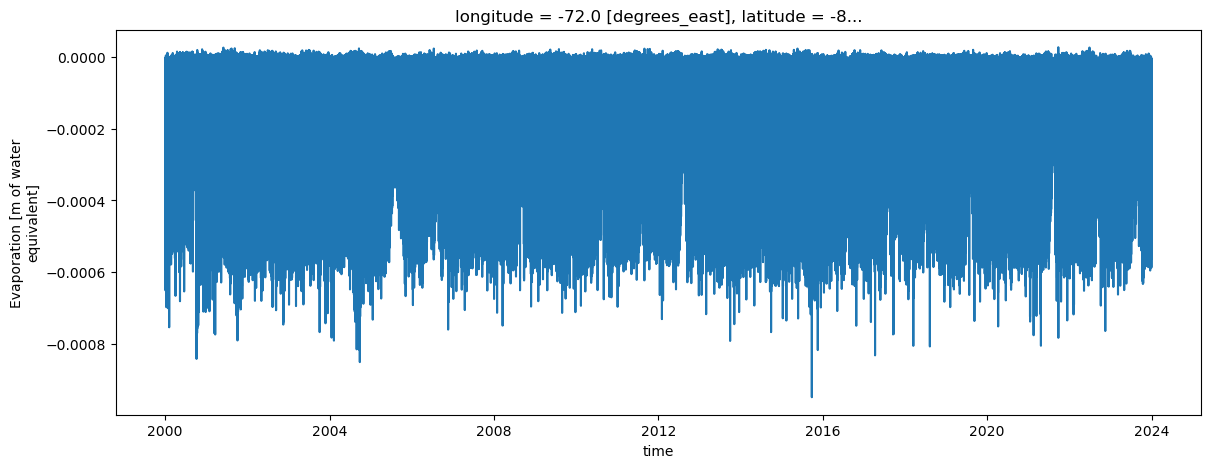

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(14,5))
dsEvapo.sel(latitude=-8,longitude=-72).e.plot()
# plt.xlim(pd.to_datetime('2015-07-01'),pd.to_datetime('2016-01-01'))


# new data

In [95]:
import pandas as pd
import numpy as np
import xarray as xr


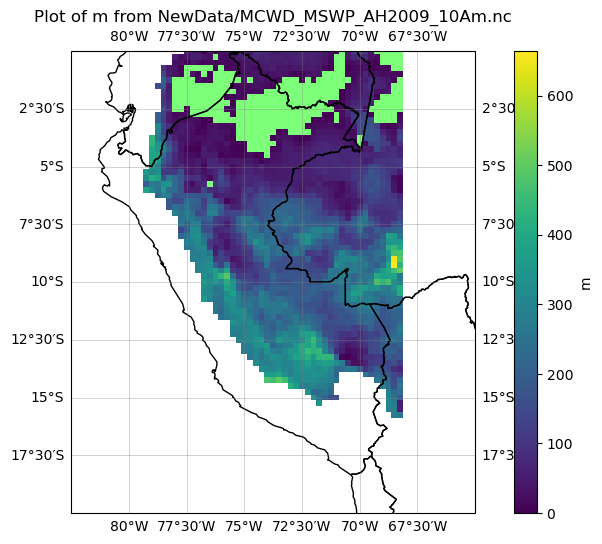

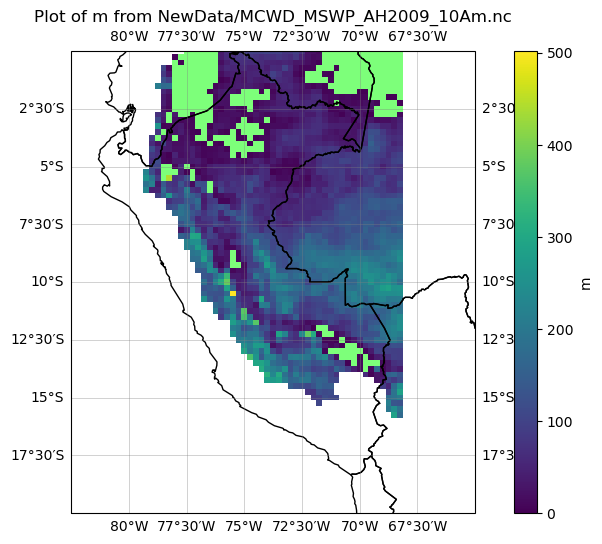

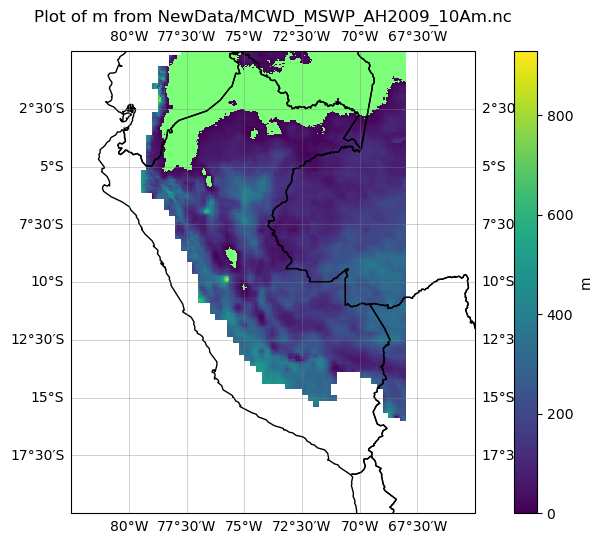

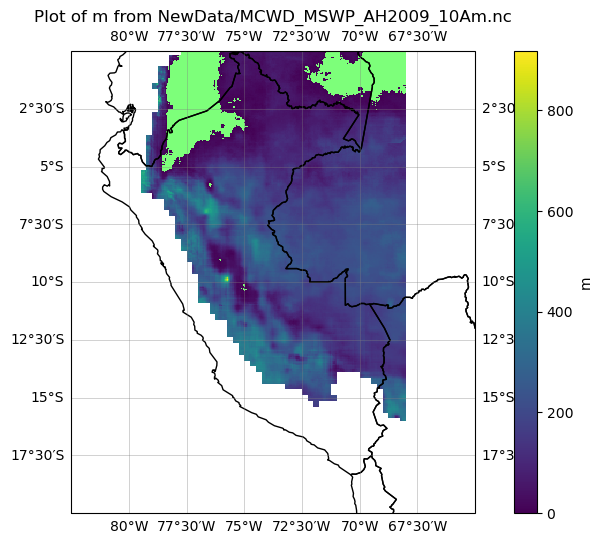

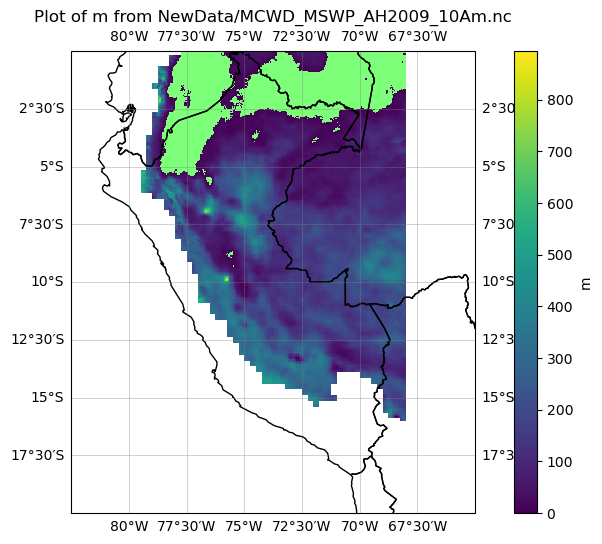

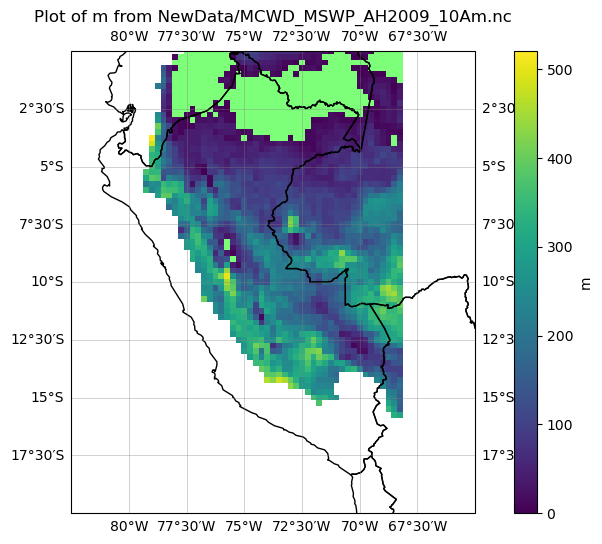

In [96]:
import glob 
# encontrar archivos 
files = glob.glob('NewData/*.nc')
for each in files:
    dsMCWD = xr.open_dataset(each)
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    dsm1=dsMCWD.m
    dsm1=dsm1.where(dsm1.values==0)
    dsm=dsMCWD.m
    dsm.plot(cmap='viridis')
    dsm1.plot(cmap='jet',add_colorbar=False,label='m=0')
    plt.title(each)
    # plt.legend()/

    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file('~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp')
    # Configurar el tamaño del gráfico y la proyección
    
    ax.set_extent([-82.5, -65, -20, 0], crs=ccrs.PlateCarree())
    # Dibujar los shapefiles de los países
    gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    # Agregar barra de color
    # Agregar etiquetas y título
    plt.title('Anomalia de Temperatura Superficial del Mar (SST)')
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.5)
    plt.title(f'Plot of {variable_name} from {nc_file}')
    plt.show()

In [97]:
import xarray as xr
import geopandas as gpd
import rioxarray

def masked_peru(nc_file, shapefile, output_file, crs="EPSG:4326"):
    """
    Filtra un dataset NetCDF espacialmente para Perú utilizando un shapefile y exporta el resultado.

    Parámetros:
    nc_file (str): Ruta al archivo NetCDF que se desea filtrar.
    shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
    output_file (str): Ruta donde se guardará el archivo NetCDF filtrado y renombrado.
    crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

    Retorna:
    None. El dataset filtrado y renombrado es guardado en la ruta especificada.
    """
    # Cargar el dataset NetCDF
    ds = xr.open_dataset(nc_file)
    ds = ds[['m']]
    # Imprimir información para depuración
    print("Información general del dataset:")
    print(ds)

    # Intentar identificar las dimensiones espaciales
    x_dim = 'longitude'
    y_dim = 'latitude'

    # Verificar si las dimensiones espaciales están en el dataset
    if x_dim not in ds.dims or y_dim not in ds.dims:
        raise ValueError(f"No se encontraron las dimensiones espaciales esperadas: {x_dim} y {y_dim}")

    # Renombrar las dimensiones a 'x' e 'y' para rioxarray
    ds = ds.rename({x_dim: 'x', y_dim: 'y'})

    # Configurar el CRS para el dataset
    ds = ds.rio.write_crs(crs)

    # Configurar las dimensiones espaciales
    ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y')

    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file(shapefile)

    # Seleccionar la geometría de Perú
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

    # Aplicar el enmascaramiento utilizando la geometría de Perú
    masked_data = ds.rio.clip([peru_shape], drop=True)

    # Renombrar las coordenadas a sus nombres originales
    masked_data = masked_data.rename({'x': 'longitude', 'y': 'latitude'})

    # Guardar el dataset filtrado y renombrado
    masked_data.to_netcdf(output_file)

    return masked_data

# Ejemplo de uso
# nc_file = 'path/to/your/netcdf_file.nc'
# shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
# output_file = 'path/to/output_file.nc'

masked_peru(nc_file, shapefile, output_file)


Información general del dataset:
<xarray.Dataset> Size: 16kB
Dimensions:    (time: 1, latitude: 69, longitude: 57)
Coordinates:
  * time       (time) datetime64[ns] 8B 2010-02-15
  * longitude  (longitude) float32 228B -82.0 -81.75 -81.5 ... -68.25 -68.0
  * latitude   (latitude) float32 276B 1.0 0.75 0.5 0.25 ... -15.5 -15.75 -16.0
Data variables:
    m          (time, latitude, longitude) float32 16kB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Apr 04 13:37:30 2024: cdo sellonlatbox,-82,-68,-16,1 -i...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...


PermissionError: [Errno 13] Permission denied: b'/home/mandrade/DMARTINEZ/NewData/NCfiltrados/MCWD_MSWP_AH2009_10Am.nc'

In [110]:
# #lista datos
# from glob import glob

# files = glob('NewData/*.nc')
# files

# output_files= [each.replace('.nc','_masked.nc') for each in files]
# output_files

['NewData/MCWD_MSWP_AH2009_10Am_masked.nc',
 'NewData/MCWD_MSWP_AH2022_23Am_masked.nc',
 'NewData/MCWD_CHIRPS_AH2004_05Am1Fix_masked.nc',
 'NewData/MCWD_CHIRPS_AH2022_23Am1Fix_masked.nc',
 'NewData/MCWD_CHIRPS_AH2009_10Am1Fix_masked.nc',
 'NewData/MCWD_MSWP_AH2004_05Am_masked.nc']

In [146]:
# CHIRPS
masked_peru('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2004_05Am1Fix.nc','~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp','NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2004_05Am1Fix_masked.nc')
masked_peru('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2009_10Am1Fix.nc','~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp','NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2009_10Am1Fix_masked.nc')
masked_peru('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2022_23Am1Fix.nc','~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp','NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2022_23Am1Fix_masked.nc')
# MCWD
masked_peru('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2004_05Am.nc','~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp','NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2004_05Am_masked.nc')
masked_peru('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2009_10Am.nc','~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp','NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2009_10Am_masked.nc')
masked_peru('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am.nc','~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp','NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am_masked.nc')


Información general del dataset:
<xarray.Dataset> Size: 384kB
Dimensions:    (time: 1, latitude: 340, longitude: 280)
Coordinates:
  * longitude  (longitude) float64 2kB -81.98 -81.92 -81.88 ... -68.08 -68.02
  * time       (time) datetime64[ns] 8B 2005-03-01T06:00:00
  * latitude   (latitude) float32 1kB -15.98 -15.93 -15.88 ... 0.875 0.925 0.975
Data variables:
    m          (time, latitude, longitude) float32 381kB ...
Attributes: (12/34)
    CDI:                       Climate Data Interface version 2.0.4 (https://...
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    acknowledgements:          The Climate Hazards Group InfraRed Precipitati...
    cdm_data_type:             Grid
    creator_email:             pete@geog.ucsb.edu
    creator_name:              Pete Peterson
    ...                        ...
    title:                     CHIRPS Version 2.0, Precipitation, Global, 0.0...
    version:                   2.0
    Westernmost_Easting:       276.025
    frequency:

<xarray.Dataset> Size: 14kB
Dimensions:      (time: 1, longitude: 51, latitude: 64)
Coordinates:
  * time         (time) datetime64[ns] 8B 2023-02-15
  * longitude    (longitude) float32 204B -81.25 -81.0 -80.75 ... -69.0 -68.75
  * latitude     (latitude) float32 256B -0.25 -0.5 -0.75 ... -15.5 -15.75 -16.0
    spatial_ref  int64 8B 0
Data variables:
    m            (time, latitude, longitude) float32 13kB nan nan ... nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Apr 04 13:36:42 2024: cdo sellonlatbox,-82,-68,-16,1 -i...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [156]:
dsm1 = xr.open_dataset('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2022_23Am1Fix_masked.nc')

In [157]:
dsm1

<xarray.Dataset> Size: 326kB
Dimensions:      (longitude: 252, time: 1, latitude: 320)
Coordinates:
  * longitude    (longitude) float64 2kB -81.27 -81.23 -81.17 ... -68.77 -68.73
  * time         (time) datetime64[ns] 8B 2023-03-01T06:00:00
  * latitude     (latitude) float32 1kB -15.98 -15.93 -15.88 ... -0.075 -0.025
Data variables:
    spatial_ref  int64 8B ...
    m            (time, latitude, longitude) float32 323kB ...
Attributes: (12/34)
    CDI:                       Climate Data Interface version 2.0.4 (https://...
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    acknowledgements:          The Climate Hazards Group InfraRed Precipitati...
    cdm_data_type:             Grid
    creator_email:             pete@geog.ucsb.edu
    creator_name:              Pete Peterson
    ...                        ...
    title:                     CHIRPS Version 2.0, Precipitation, Global, 0.0...
    version:                   2.0
    Westernmost_Easting:       276.025
    frequency:                 mon
    NCO:                       netCDF Operators version 5.0.6 (Homepage = htt...
    CDO:                       Climate Data Operators version 2.0.4 (https://...

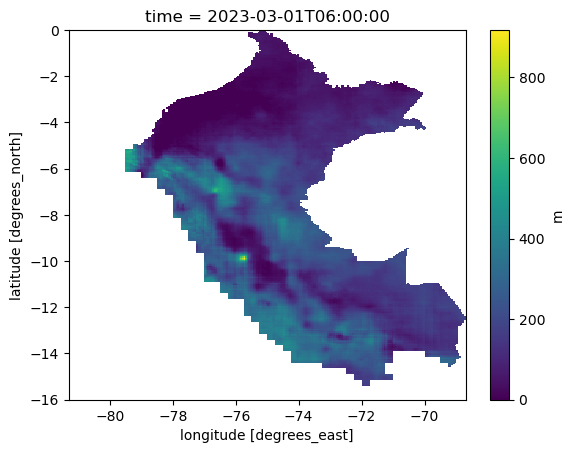

In [158]:
dsm1.m.plot()

['NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2022_23Am1Fix_masked.nc', 'NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2004_05Am1Fix_masked.nc', 'NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2009_10Am1Fix_masked.nc']
total area:950552.2693444949
Área total en NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2022_23Am1Fix_masked.nc: 950552.27 km²


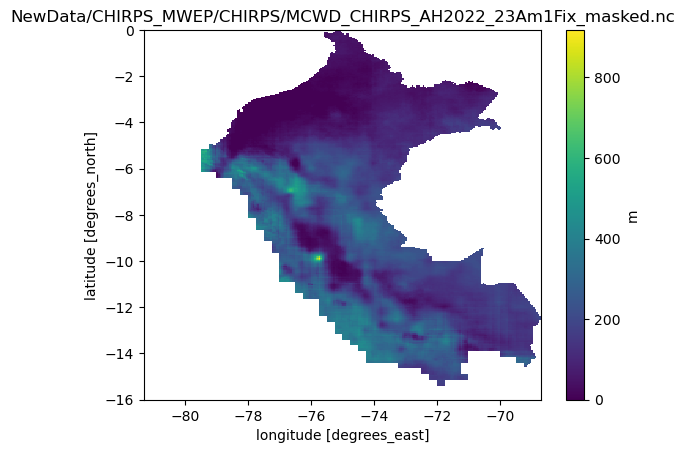

total area:950552.2693444949
Área total en NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2004_05Am1Fix_masked.nc: 950552.27 km²


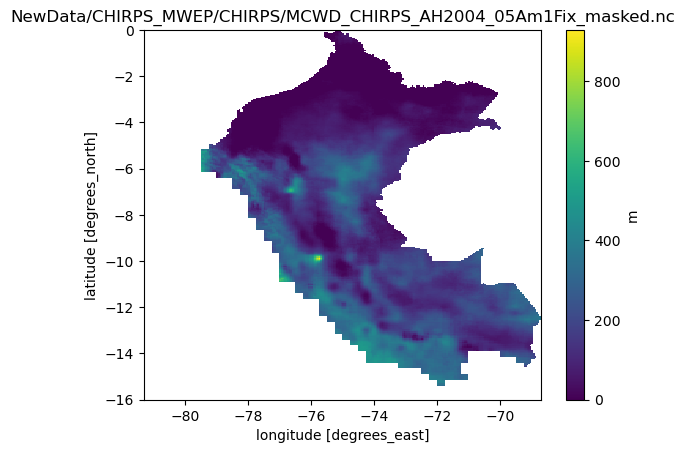

total area:950552.2693444949
Área total en NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2009_10Am1Fix_masked.nc: 950552.27 km²


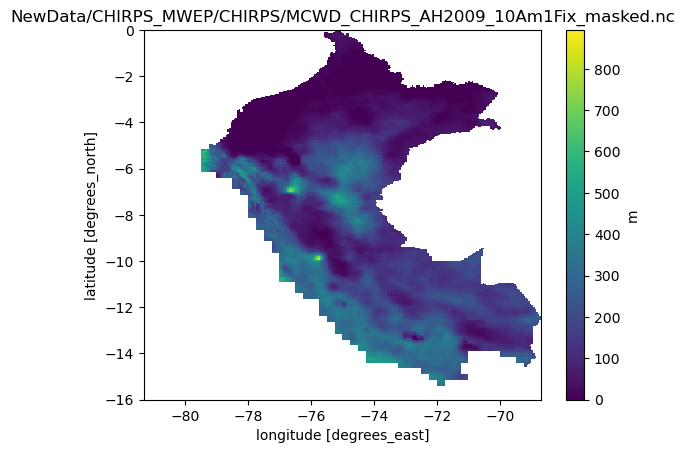

In [165]:
nc_files = glob('NewData/CHIRPS_MWEP/CHIRPS/*_masked.nc')
nc_files

import xarray as xr
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

def filter_data_for_peru(nc_file, shapefile, crs="EPSG:4326"):
    """
    Filtra un dataset NetCDF espacialmente para Perú utilizando un shapefile.

    Parámetros:
    nc_file (str): Ruta al archivo NetCDF que se desea filtrar.
    shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
    crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

    Retorna:
    masked_data (xarray.Dataset): Dataset filtrado para la región de Perú.
    """
    # Cargar el dataset NetCDF
    ds = xr.open_dataset(nc_file)
    ds = ds[['m']]

    # Renombrar dimensiones si es necesario
    if 'longitude' in ds.dims and 'latitude' in ds.dims:
        ds = ds.rename({'longitude': 'x', 'latitude': 'y'})
    elif 'lon' in ds.dims and 'lat' in ds.dims:
        ds = ds.rename({'lon': 'x', 'lat': 'y'})
    else:
        # Inferir las dimensiones espaciales
        possible_x_dims = ['lon', 'longitude', 'x']
        possible_y_dims = ['lat', 'latitude', 'y']
        x_dim = next((dim for dim in ds.dims if dim in possible_x_dims), None)
        y_dim = next((dim for dim in ds.dims if dim in possible_y_dims), None)
        if x_dim and y_dim:
            ds = ds.rename({x_dim: 'x', y_dim: 'y'})
        else:
            raise ValueError("No se encontraron dimensiones espaciales reconocidas en el dataset.")

    # Configurar el CRS para el dataset
    ds = ds.rio.write_crs(crs)

    # Configurar las dimensiones espaciales si no están correctamente identificadas
    ds = ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file(shapefile)

    # Seleccionar la geometría de Perú
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

    # Aplicar el enmascaramiento utilizando la geometría de Perú
    masked_data = ds.rio.clip([peru_shape], drop=True)

    return masked_data

def calculate_area(masked_data):
    """
    Calcula el área total del dataset enmascarado basado en su resolución.

    Parámetros:
    masked_data (xarray.Dataset): Dataset enmascarado.

    Retorna:
    total_area (float): Área total en kilómetros cuadrados.
    """
    # Asumir que la resolución espacial es la misma en ambas dimensiones
    res_lat = (masked_data.latitude[1] - masked_data.latitude[0]).values
    res_lon = (masked_data.longitude[1] - masked_data.longitude[0]).values
    # Calcular área de una celda en km²
    area_per_cell = abs(res_lat * res_lon) * 111**2
    # Contar el número de celdas con datos válidos
    valid_cells = masked_data.notnull().sum().values
    # Calcular el área total
    total_area = valid_cells * area_per_cell
    print(f'total area:{total_area}')
    return total_area

# Ejemplo de uso de la función
shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
print(nc_files)
for nc_file in nc_files:
    masked_data=xr.open_dataset(nc_file)
    total_area = calculate_area(masked_data.m)
    print(f"Área total en {nc_file}: {total_area:.2f} km²")
    plt.figure()
    masked_data.m.plot()
    plt.title(f'{nc_file}')
    plt.show()


In [168]:
#
ds = xr.open_dataset('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2009_10Am1Fix_masked.nc')
ds

<xarray.Dataset> Size: 326kB
Dimensions:      (longitude: 252, time: 1, latitude: 320)
Coordinates:
  * longitude    (longitude) float64 2kB -81.27 -81.23 -81.17 ... -68.77 -68.73
  * time         (time) datetime64[ns] 8B 2010-03-01T06:00:00
  * latitude     (latitude) float32 1kB -15.98 -15.93 -15.88 ... -0.075 -0.025
Data variables:
    spatial_ref  int64 8B ...
    m            (time, latitude, longitude) float32 323kB ...
Attributes: (12/34)
    CDI:                       Climate Data Interface version 2.0.4 (https://...
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    acknowledgements:          The Climate Hazards Group InfraRed Precipitati...
    cdm_data_type:             Grid
    creator_email:             pete@geog.ucsb.edu
    creator_name:              Pete Peterson
    ...                        ...
    title:                     CHIRPS Version 2.0, Precipitation, Global, 0.0...
    version:                   2.0
    Westernmost_Easting:       276.025
    frequency:                 mon
    NCO:                       netCDF Operators version 5.0.6 (Homepage = htt...
    CDO:                       Climate Data Operators version 2.0.4 (https://...

Processing file: MCWD_CHIRPS_AH2004_05Am1Fix_masked2
Data has a time dimension. Applying mean over time.
Processing file: MCWD_CHIRPS_AH2009_10Am1Fix_masked2
Data has a time dimension. Applying mean over time.
Processing file: MCWD_CHIRPS_AH2022_23Am1Fix_masked2
Data has a time dimension. Applying mean over time.
Processing complete.


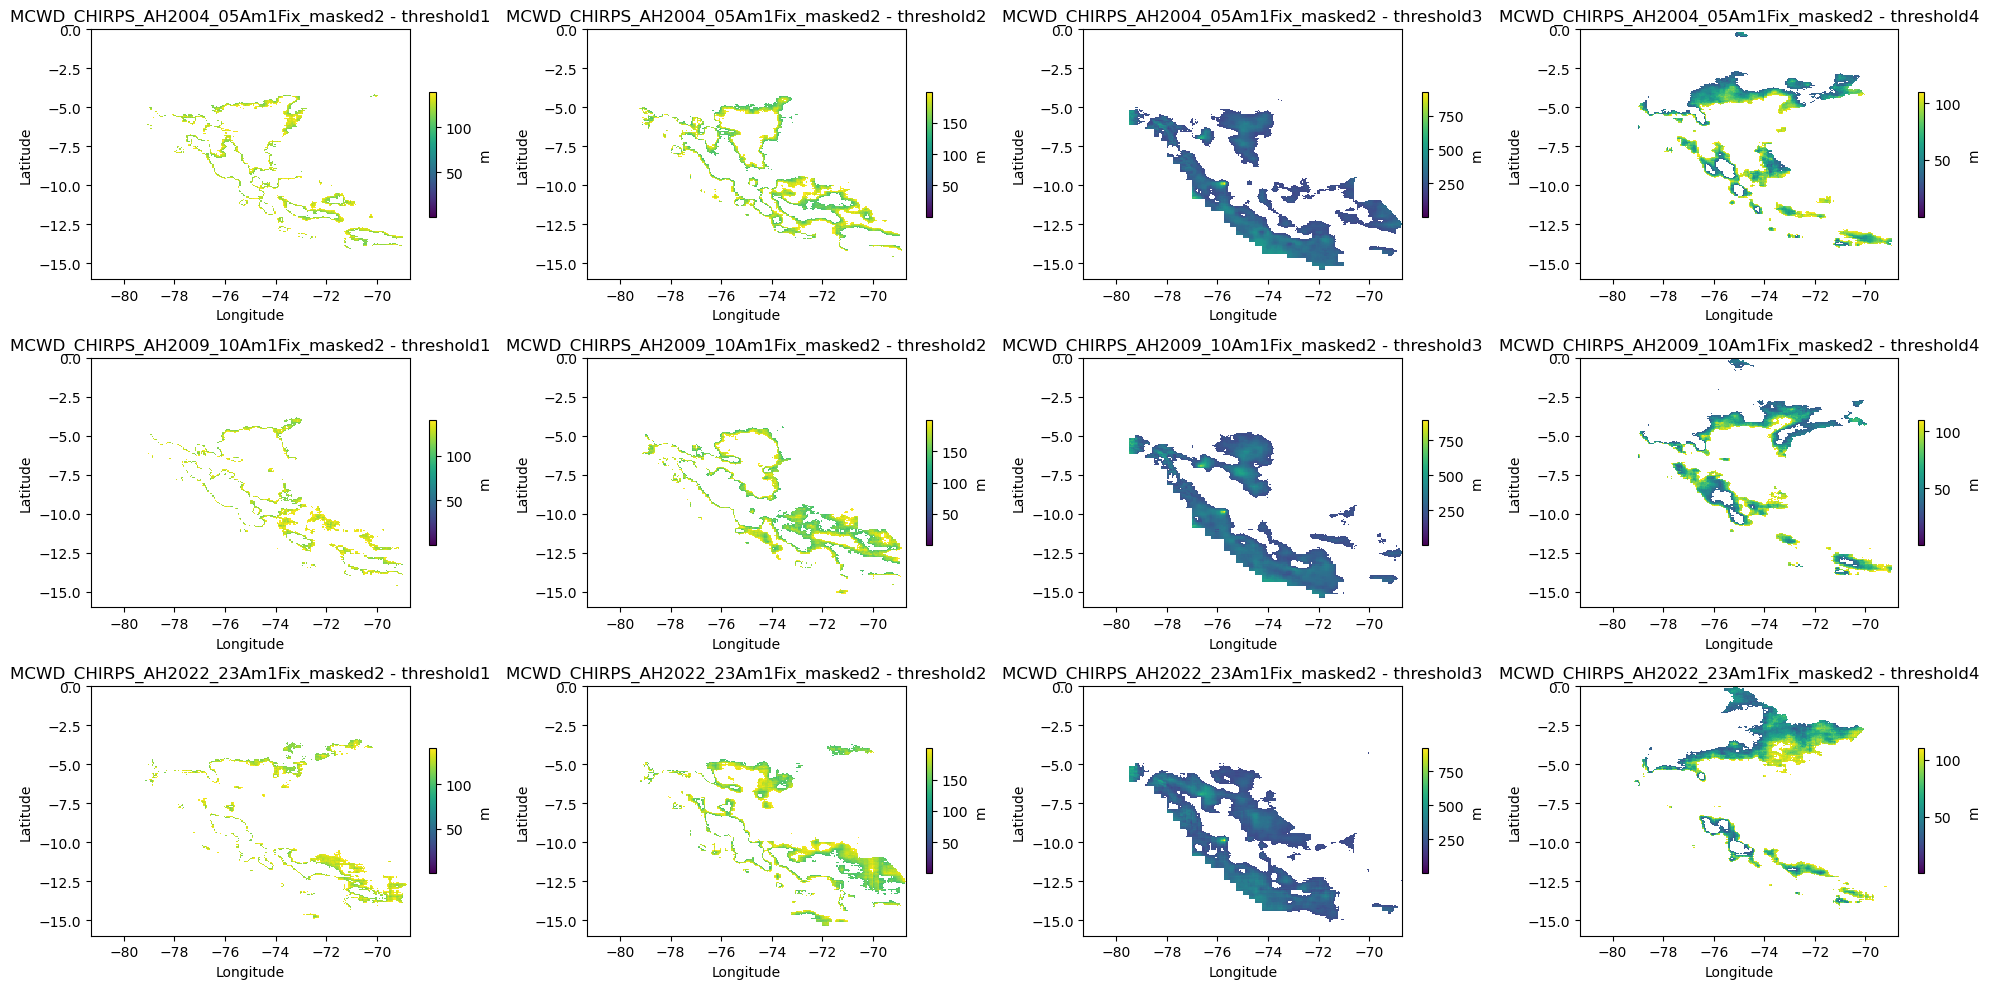

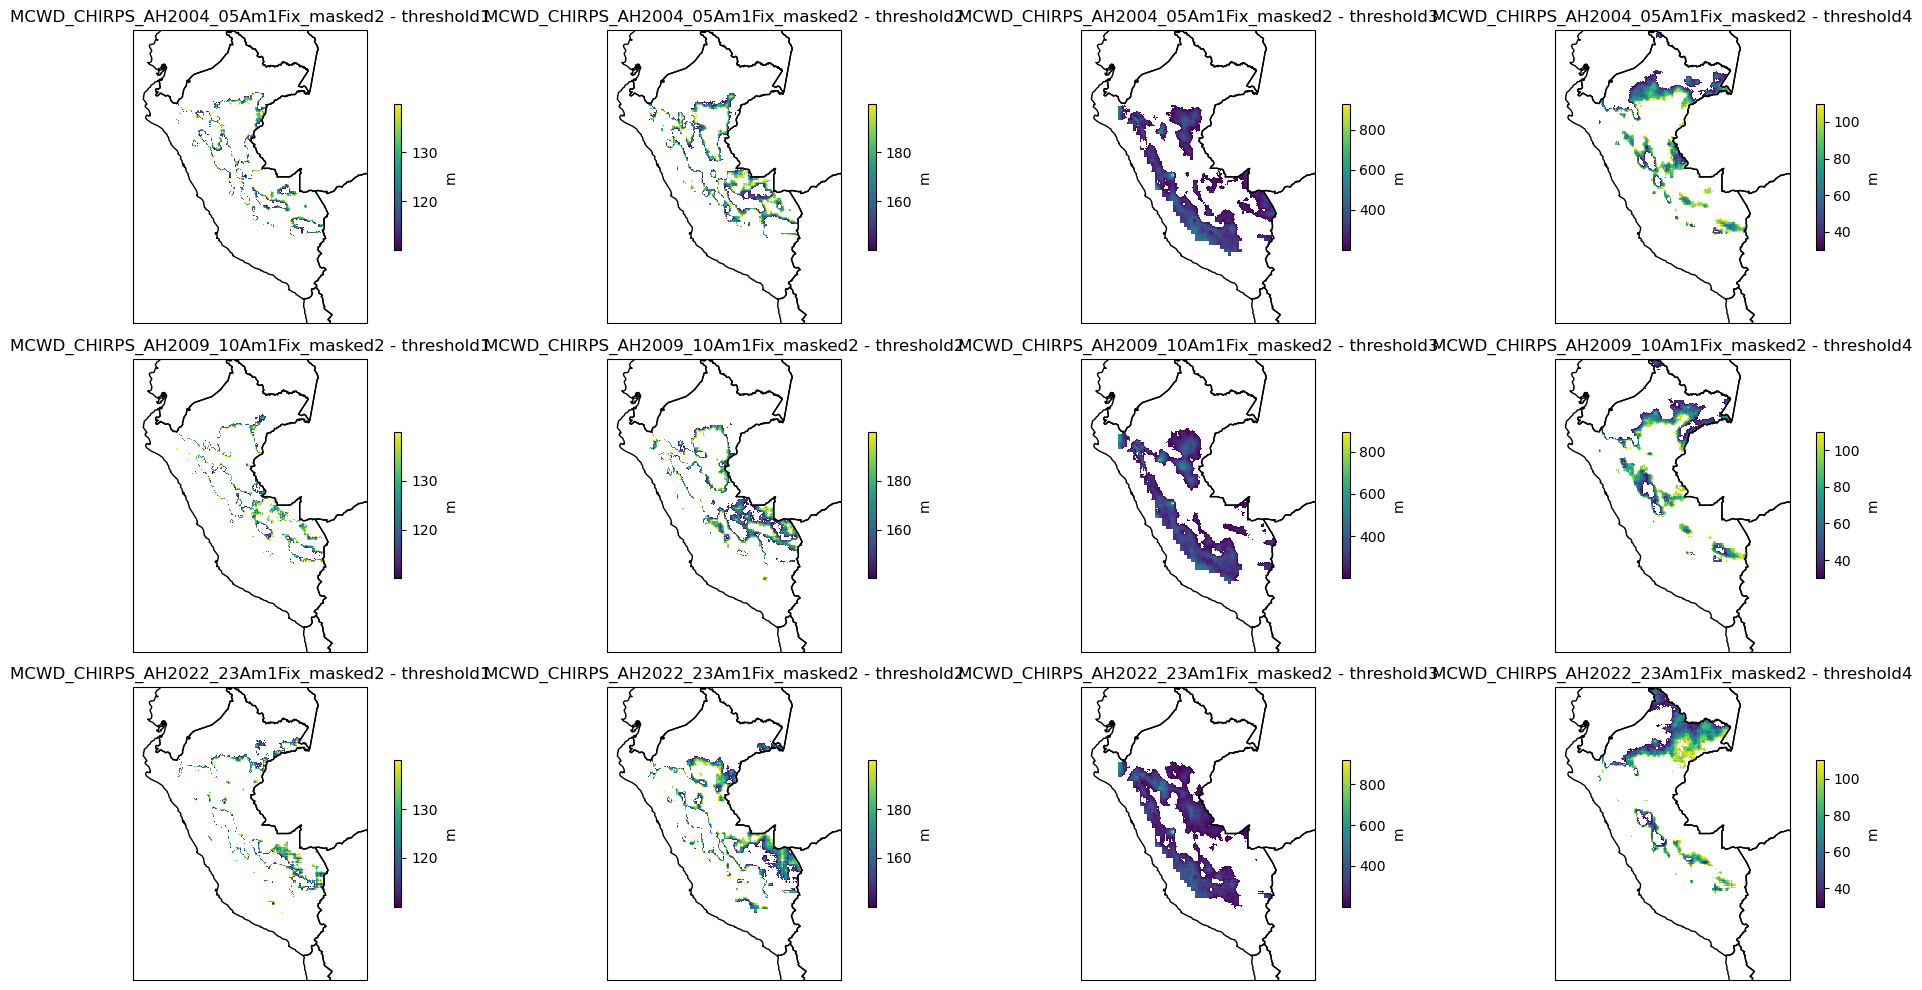

In [7]:
import xarray as xr
import geopandas as gpd
import rioxarray
import numpy as np
import os
import pandas as pd

# def filter_data_for_peru(nc_file, shapefile, crs="EPSG:4326"):
#     """
#     Filtra un dataset NetCDF espacialmente para Perú utilizando un shapefile.

#     Parámetros:
#     nc_file (str): Ruta al archivo NetCDF que se desea filtrar.
#     shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
#     crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

#     Retorna:
#     masked_data (xarray.Dataset): Dataset filtrado para la región de Perú.
#     """
#     # Cargar el dataset NetCDF
#     ds = xr.open_dataset(nc_file)
#     ds = ds[['m']]
#     # Intentar identificar las dimensiones espaciales comunes
#     if 'longitude' in ds.dims and 'latitude' in ds.dims:
#         ds = ds.rename({'longitude': 'x', 'latitude': 'y'})
#     elif 'lon' in ds.dims and 'lat' in ds.dims:
#         ds = ds.rename({'lon': 'x', 'lat': 'y'})
#     else:
#         # Intentar inferir las dimensiones espaciales automáticamente
#         possible_x_dims = ['lon', 'longitude', 'x']
#         possible_y_dims = ['lat', 'latitude', 'y']
#         x_dim = next((dim for dim in ds.dims if dim in possible_x_dims), None)
#         y_dim = next((dim for dim in ds.dims if dim in possible_y_dims), None)
#         if x_dim and y_dim:
#             ds = ds.rename({x_dim: 'x', y_dim: 'y'})
#         else:
#             raise ValueError("No se encontraron dimensiones espaciales reconocidas en el dataset.")

#     # Configurar el CRS para el dataset
#     ds = ds.rio.write_crs(crs)

#     # Configurar las dimensiones espaciales si no están correctamente identificadas
#     ds = ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

#     # Cargar el shapefile usando Geopandas
#     gdf = gpd.read_file(shapefile)

#     # Seleccionar la geometría de Perú
#     peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

#     # Convertir la geometría a una lista para usar en el enmascaramiento
#     geometries = [peru_shape]

#     # Aplicar el enmascaramiento utilizando la geometría de Perú
#     masked_data = ds.rio.clip(geometries, drop=True)

#     return masked_data

# # Uso de la función
# nc_file = 'ERA_MCWD_AH2004_05Am.nc'
# shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
# masked_data = filter_data_for_peru(nc_file, shapefile)
# masked_data.to_netcdf('ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru.nc')
# masked_data.m.plot()
# plt.show()


# nc_file = 'ERA_MCWD_AH2009_10Am.nc'
# shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
# masked_data = filter_data_for_peru(nc_file, shapefile)
# masked_data.to_netcdf('ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru.nc')
# masked_data.m.plot()
# plt.show()


# nc_file = 'ERA5_MCWD_AH2022_23Am.nc'
# shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
# masked_data = filter_data_for_peru(nc_file, shapefile)
# masked_data.to_netcdf('ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru.nc')
# masked_data.m.plot()
# plt.show()




ds = xr.open_dataset('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2004_05Am1Fix_masked.nc')
ds = ds[['m']]
ds.to_netcdf('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2004_05Am1Fix_masked2.nc')


ds = xr.open_dataset('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2009_10Am1Fix_masked.nc')
ds = ds[['m']]
ds.to_netcdf('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2009_10Am1Fix_masked2.nc')



ds = xr.open_dataset('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2022_23Am1Fix_masked.nc')
ds = ds[['m']]
ds.to_netcdf('NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2022_23Am1Fix_masked2.nc')


# Define paths and filenames
data_dir = "NewData/CHIRPS_MWEP/CHIRPS/"
output_dir = "Results"
filenames = ["MCWD_CHIRPS_AH2004_05Am1Fix_masked2", "MCWD_CHIRPS_AH2009_10Am1Fix_masked2", "MCWD_CHIRPS_AH2022_23Am1Fix_masked2"]
km = 111

# Create output directory if it doesn't exist
os.makedirs(os.path.join(data_dir, output_dir), exist_ok=True)

def process_threshold(data, lower_bound, upper_bound=None):
    if upper_bound:
        mask = (data >= lower_bound) & (data <= upper_bound)
    else:
        mask = (data >= lower_bound)
    thresholded_data = xr.where(mask, data, 0)
    return thresholded_data

def calculate_area(grid_res, km_factor):
    return grid_res**2 * km_factor**2

for file in filenames:
    print(f"Processing file: {file}")
    ds = xr.open_dataset(os.path.join(data_dir, f"{file}.nc"))

    # Seleccionar la variable numérica 'm'
    data = ds['m']

    # Si hay una dimensión de tiempo, promediar sobre el tiempo
    if 'time' in data.dims:
        print("Data has a time dimension. Applying mean over time.")
        data = data.mean(dim='time')

    # Process Threshold 1
    threshold1 = process_threshold(data, 110, 140)
    threshold1_sum = threshold1.sum(dim=['latitude', 'longitude'])
    threshold1_area = calculate_area(ds.attrs.get('xinc', 1), km)
    threshold1_km2 = threshold1_sum * threshold1_area
    threshold1=threshold1.where(threshold1>0)
    threshold1.to_netcdf(os.path.join(data_dir, output_dir, f"threshold1_{file}.nc"))

    # Process Threshold 2
    threshold2 = process_threshold(data, 140, 200)
    threshold2_sum = threshold2.sum(dim=['latitude', 'longitude'])
    threshold2_km2 = threshold2_sum * threshold1_area
    threshold2=threshold2.where(threshold2>0)
    threshold2.to_netcdf(os.path.join(data_dir, output_dir, f"threshold2_{file}.nc"))

    # Process Threshold 3
    threshold3 = process_threshold(data, 200)
    threshold3_sum = threshold3.sum(dim=['latitude', 'longitude'])
    threshold3_km2 = threshold3_sum * threshold1_area
    threshold3=threshold3.where(threshold3>0)
    threshold3.to_netcdf(os.path.join(data_dir, output_dir, f"threshold3_{file}.nc"))

    # Process Threshold 4
    threshold4 = process_threshold(data, 30, 110)
    threshold4_sum = threshold4.sum(dim=['latitude', 'longitude'])
    threshold4_km2 = threshold4_sum * threshold1_area
    threshold4=threshold4.where(threshold4>0)
    threshold4.to_netcdf(os.path.join(data_dir, output_dir, f"threshold4_{file}.nc"))
    
        # Process Threshold 5
    threshold5 = process_threshold(data, 0)
    threshold5_sum = threshold5.sum(dim=['latitude', 'longitude'])
    threshold5_km2 = threshold5_sum * threshold1_area
    threshold5.to_netcdf(os.path.join(data_dir, output_dir, f"threshold5_{file}.nc"))

    # Save results to CSV
    result_df = pd.DataFrame({
        'Threshold': [1, 2, 3, 4,5],
        'GPoints': [threshold1_sum.values, threshold2_sum.values, threshold3_sum.values, threshold4_sum.values,threshold5_sum.values],
        'km2': [threshold1_km2.values, threshold2_km2.values, threshold3_km2.values, threshold4_km2.values,threshold5_km2.values]
    })
    result_df.to_csv(os.path.join(data_dir, output_dir, f"{file}_results.csv"), index=False)

print("Processing complete.")


# graficando resultados de Results
import matplotlib.pyplot as plt
import xarray as xr
import os

# Define paths and filenames
data_dir = "NewData/CHIRPS_MWEP/CHIRPS/"
output_dir = "NewData/CHIRPS_MWEP/CHIRPS/Results"
filenames = ["MCWD_CHIRPS_AH2004_05Am1Fix_masked2", "MCWD_CHIRPS_AH2009_10Am1Fix_masked2", "MCWD_CHIRPS_AH2022_23Am1Fix_masked2"]

# Crear una figura con subplots
fig, axs = plt.subplots(len(filenames), 4, figsize=(20, 10))

for i, file in enumerate(filenames):
    for j, threshold in enumerate(['threshold1', 'threshold2', 'threshold3', 'threshold4']):
        # Cargar los datos desde los archivos NetCDF generados
        ds = xr.open_dataset(os.path.join(output_dir, f"{threshold}_{file}.nc"))
        data = ds['m']
        
        # Crear el subplot
        ax = axs[i, j]
        data.plot(ax=ax, cmap='viridis', cbar_kwargs={'shrink': 0.5},vmin=0.1)
        ax.set_title(f"{file} - {threshold}")
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

# Ajustar el layout
plt.tight_layout()
plt.show()


import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import rioxarray

def ploteaMapa(varname, shapefile, title="Mapa enmascarado para Perú", extent=[-82, -66, -20, 0]):
    """
    Plotea un mapa enmascarado para Perú utilizando un dataset NetCDF y un shapefile.

    Parámetros:
    varname (str): Ruta al archivo NetCDF.
    shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
    title (str): Título del gráfico.
    extent (list): Extensión del mapa [lon_min, lon_max, lat_min, lat_max].

    Retorna:
    None: Muestra el mapa en la pantalla.
    """
    # Cargar el dataset NetCDF
    dsT1 = xr.open_dataset(varname)

    # Configurar el CRS (EPSG:4326 es el sistema de referencia geográfica WGS 84)
    dsT1 = dsT1.rio.write_crs("EPSG:4326")

    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file(shapefile)

    # Seleccionar la geometría de Perú
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

    # Convertir la geometría a una lista para usar en el enmascaramiento
    geometries = [peru_shape]

    # Convertir la geometría a una máscara para xarray
    masked_data = dsT1.rio.clip(geometries, drop=True)

    # Configurar el tamaño del gráfico y la proyección
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Dibujar los shapefiles de los países
    gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

    # Plotear los datos enmascarados
    masked_data.where(masked_data.m.values > 0).m.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})

    # Configuración de la barra de color, etiquetas y título
    plt.title(title)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.5)

    plt.show()

import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import os
import cartopy.crs as ccrs

def ploteaMapaEnSubplot(ax, varname, shapefile, extent=[-82, -66, -20, 0]):
    """
    Plotea un mapa en un subplot utilizando un dataset NetCDF y un shapefile.
    
    Parámetros:
    ax (matplotlib.axes): El eje en el que se ploteará el mapa.
    varname (str): Ruta al archivo NetCDF.
    shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
    extent (list): Extensión del mapa [lon_min, lon_max, lat_min, lat_max].
    
    Retorna:
    None: El mapa es ploteado en el eje proporcionado.
    """
    # Cargar el dataset NetCDF
    dsT1 = xr.open_dataset(varname)
    dsT1 = dsT1.rio.write_crs("EPSG:4326")
    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file(shapefile)
    
    # Seleccionar la geometría de Perú
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union
    
    # Convertir la geometría a una lista para usar en el enmascaramiento
    geometries = [peru_shape]
    
    # Aplicar el enmascaramiento utilizando la geometría de Perú
    masked_data = dsT1.rio.clip(geometries, drop=True)
    
    # Configurar la extensión del mapa y ploteo
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    masked_data.where(masked_data.m.values > 0).m.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})

# Define paths and filenames
data_dir = "NewData/CHIRPS_MWEP/CHIRPS/"
output_dir = "NewData/CHIRPS_MWEP/CHIRPS/Results"
filenames = ["MCWD_CHIRPS_AH2004_05Am1Fix_masked2", "MCWD_CHIRPS_AH2009_10Am1Fix_masked2", "MCWD_CHIRPS_AH2022_23Am1Fix_masked2"]

shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
# Crear una figura con subplots
fig, axs = plt.subplots(len(filenames), 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i, file in enumerate(filenames):
    for j, threshold in enumerate(['threshold1', 'threshold2', 'threshold3', 'threshold4']):
        varname = os.path.join(output_dir, f"{threshold}_{file}.nc")
        ploteaMapaEnSubplot(axs[i, j], varname, shapefile)
        axs[i, j].set_title(f"{file} - {threshold}")
        axs[i, j].set_xlabel('Longitude')
        axs[i, j].set_ylabel('Latitude')

# Ajustar el layout
plt.tight_layout()
plt.savefig('NewData/CHIRPS_MWEP/CHIRPS/Plot.png')
plt.show()

In [178]:
def calculate_area(masked_data):
    """
    Calcula el área total del dataset enmascarado basado en su resolución.

    Parámetros:
    masked_data (xarray.Dataset): Dataset enmascarado.

    Retorna:
    total_area (float): Área total en kilómetros cuadrados.
    """
    # Asumir que la resolución espacial es la misma en ambas dimensiones
    res_lat = (masked_data.latitude[1] - masked_data.latitude[0]).values
    res_lon = (masked_data.longitude[1] - masked_data.longitude[0]).values
    # Calcular área de una celda en km²
    area_per_cell = abs(res_lat * res_lon) * 111**2
    # Contar el número de celdas con datos válidos
    valid_cells = masked_data.notnull().sum().values
    # Calcular el área total
    total_area = valid_cells * area_per_cell
    print(f'total area:{total_area}')
    return total_area

import glob
import xarray as xr
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

file_pattern = 'ERA_masked/*.nc'
files = glob.glob(file_pattern)

# Inicializar una lista para almacenar los resultados
for each in files:
    try:
        print('procesando archivo',each)
        ds1= xr.open_dataset(each)
        calculate_area(ds1.m)
    except:
        print('error en el archivo : ',each)


##############

file_pattern = 'NewData/CHIRPS_MWEP/CHIRPS/NewData/CHIRPS_MWEP/CHIRPS/Results/*.nc'
files = glob.glob(file_pattern)

# Inicializar una lista para almacenar los resultados
for each in files:
    print('procesando archivo',each)
    ds1= xr.open_dataset(each)
    calculate_area(ds1.m)

procesando archivo ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru2.nc
total area:932545.6875
procesando archivo ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru.nc
error en el archivo :  ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru.nc
procesando archivo ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru.nc
error en el archivo :  ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru.nc
procesando archivo ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru.nc
error en el archivo :  ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru.nc
procesando archivo ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru2.nc
total area:942737.2817209493
procesando archivo ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru2.nc
total area:942737.2817209493
procesando archivo NewData/CHIRPS_MWEP/CHIRPS/NewData/CHIRPS_MWEP/CHIRPS/Results/threshold2_MCWD_CHIRPS_AH2022_23Am1Fix_masked2.nc
total area:177934.07238385628
procesando archivo NewData/CHIRPS_MWEP/CHIRPS/NewData/CHIRPS_MWEP/CHIRPS/Results/threshold5_MCWD_CHIRPS_AH2009_10Am1Fix_masked2.nc
total area:2483

# MSwP

['NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2009_10Am_masked.nc', 'NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2004_05Am_masked.nc', 'NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am_masked.nc']
total area:932545.6875
Área total en NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2009_10Am_masked.nc: 932545.69 km²


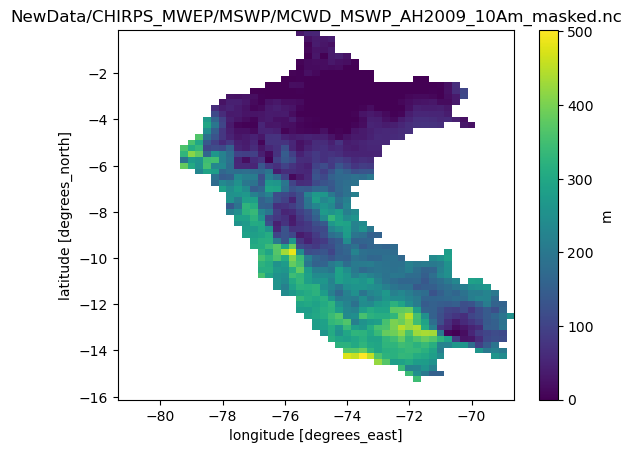

total area:932545.6875
Área total en NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2004_05Am_masked.nc: 932545.69 km²


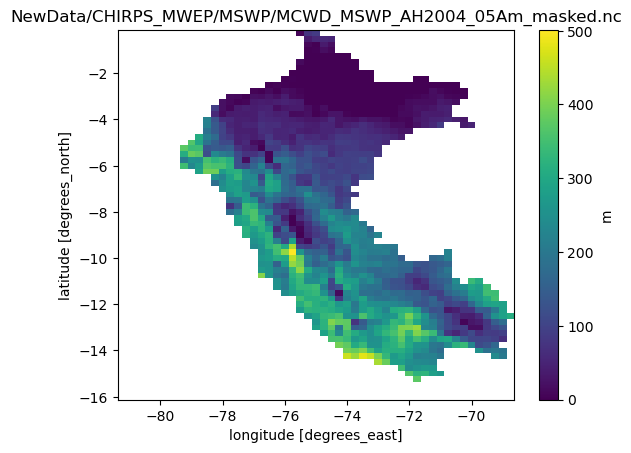

total area:932545.6875
Área total en NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am_masked.nc: 932545.69 km²


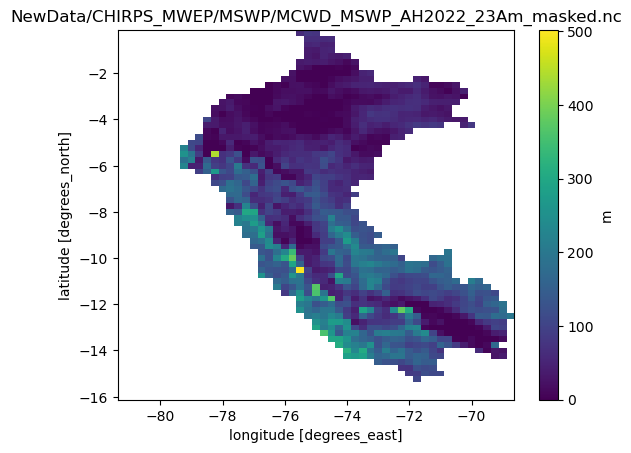

In [8]:
import xarray as xr
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt
from glob import glob 

nc_files = glob('NewData/CHIRPS_MWEP/MSWP/*_masked.nc')
nc_files


def filter_data_for_peru(nc_file, shapefile, crs="EPSG:4326"):
    """
    Filtra un dataset NetCDF espacialmente para Perú utilizando un shapefile.

    Parámetros:
    nc_file (str): Ruta al archivo NetCDF que se desea filtrar.
    shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
    crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

    Retorna:
    masked_data (xarray.Dataset): Dataset filtrado para la región de Perú.
    """
    # Cargar el dataset NetCDF
    ds = xr.open_dataset(nc_file)
    ds = ds[['m']]

    # Renombrar dimensiones si es necesario
    if 'longitude' in ds.dims and 'latitude' in ds.dims:
        ds = ds.rename({'longitude': 'x', 'latitude': 'y'})
    elif 'lon' in ds.dims and 'lat' in ds.dims:
        ds = ds.rename({'lon': 'x', 'lat': 'y'})
    else:
        # Inferir las dimensiones espaciales
        possible_x_dims = ['lon', 'longitude', 'x']
        possible_y_dims = ['lat', 'latitude', 'y']
        x_dim = next((dim for dim in ds.dims if dim in possible_x_dims), None)
        y_dim = next((dim for dim in ds.dims if dim in possible_y_dims), None)
        if x_dim and y_dim:
            ds = ds.rename({x_dim: 'x', y_dim: 'y'})
        else:
            raise ValueError("No se encontraron dimensiones espaciales reconocidas en el dataset.")

    # Configurar el CRS para el dataset
    ds = ds.rio.write_crs(crs)

    # Configurar las dimensiones espaciales si no están correctamente identificadas
    ds = ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

    # Cargar el shapefile usando Geopandas
    gdf = gpd.read_file(shapefile)

    # Seleccionar la geometría de Perú
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

    # Aplicar el enmascaramiento utilizando la geometría de Perú
    masked_data = ds.rio.clip([peru_shape], drop=True)

    return masked_data

def calculate_area(masked_data):
    """
    Calcula el área total del dataset enmascarado basado en su resolución.

    Parámetros:
    masked_data (xarray.Dataset): Dataset enmascarado.

    Retorna:
    total_area (float): Área total en kilómetros cuadrados.
    """
    # Asumir que la resolución espacial es la misma en ambas dimensiones
    res_lat = (masked_data.latitude[1] - masked_data.latitude[0]).values
    res_lon = (masked_data.longitude[1] - masked_data.longitude[0]).values
    # Calcular área de una celda en km²
    area_per_cell = abs(res_lat * res_lon) * 111**2
    # Contar el número de celdas con datos válidos
    valid_cells = masked_data.notnull().sum().values
    # Calcular el área total
    total_area = valid_cells * area_per_cell
    print(f'total area:{total_area}')
    return total_area

# Ejemplo de uso de la función
shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
print(nc_files)
for nc_file in nc_files:
    masked_data=xr.open_dataset(nc_file)
    total_area = calculate_area(masked_data.m)
    print(f"Área total en {nc_file}: {total_area:.2f} km²")
    plt.figure()
    masked_data.m.plot()
    plt.title(f'{nc_file}')
    plt.show()


In [9]:
# import xarray as xr
# import geopandas as gpd
# import rioxarray
# import numpy as np
# import os
# import pandas as pd



# ds = xr.open_dataset('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2004_05Am_masked.nc')
# ds = ds[['m']]
# ds.to_netcdf('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2004_05Am_masked2.nc')


# ds = xr.open_dataset('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2009_10Am_masked.nc')
# ds = ds[['m']]
# ds.to_netcdf('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2009_10Am_masked2.nc')



# ds = xr.open_dataset('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am_masked.nc')
# ds = ds[['m']]
# ds.to_netcdf('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am_masked2.nc')


# # Define paths and filenames
# data_dir = "NewData/CHIRPS_MWEP/MSWP/"
# output_dir = "Results"
# filenames = ["MCWD_MSWP_AH2004_05Am_masked2", "MCWD_MSWP_AH2009_10Am_masked2", "MCWD_MSWP_AH2022_23Am_masked2"]
# km = 111

# # Create output directory if it doesn't exist
# os.makedirs(os.path.join(data_dir, output_dir), exist_ok=True)

# def process_threshold(data, lower_bound, upper_bound=None):
#     if upper_bound:
#         mask = (data >= lower_bound) & (data <= upper_bound)
#     else:
#         mask = (data >= lower_bound)
#     thresholded_data = xr.where(mask, data, 0)
#     return thresholded_data

# def calculate_area(grid_res, km_factor):
#     return grid_res**2 * km_factor**2

# for file in filenames:
#     print(f"Processing file: {file}")
#     ds = xr.open_dataset(os.path.join(data_dir, f"{file}.nc"))

#     # Seleccionar la variable numérica 'm'
#     data = ds['m']

#     # Si hay una dimensión de tiempo, promediar sobre el tiempo
#     if 'time' in data.dims:
#         print("Data has a time dimension. Applying mean over time.")
#         data = data.mean(dim='time')

#     # Process Threshold 1
#     threshold1 = process_threshold(data, 110, 140)
#     threshold1_sum = threshold1.sum(dim=['latitude', 'longitude'])
#     threshold1_area = calculate_area(ds.attrs.get('xinc', 1), km)
#     threshold1_km2 = threshold1_sum * threshold1_area
#     threshold1=threshold1.where(threshold1>0)
#     threshold1.to_netcdf(os.path.join(data_dir, output_dir, f"threshold1_{file}.nc"))

#     # Process Threshold 2
#     threshold2 = process_threshold(data, 140, 200)
#     threshold2_sum = threshold2.sum(dim=['latitude', 'longitude'])
#     threshold2_km2 = threshold2_sum * threshold1_area
#     threshold2=threshold2.where(threshold2>0)
#     threshold2.to_netcdf(os.path.join(data_dir, output_dir, f"threshold2_{file}.nc"))

#     # Process Threshold 3
#     threshold3 = process_threshold(data, 200)
#     threshold3_sum = threshold3.sum(dim=['latitude', 'longitude'])
#     threshold3_km2 = threshold3_sum * threshold1_area
#     threshold3=threshold3.where(threshold3>0)
#     threshold3.to_netcdf(os.path.join(data_dir, output_dir, f"threshold3_{file}.nc"))

#     # Process Threshold 4
#     threshold4 = process_threshold(data, 30, 110)
#     threshold4_sum = threshold4.sum(dim=['latitude', 'longitude'])
#     threshold4_km2 = threshold4_sum * threshold1_area
#     threshold4=threshold4.where(threshold4>0)
#     threshold4.to_netcdf(os.path.join(data_dir, output_dir, f"threshold4_{file}.nc"))
    
#         # Process Threshold 5
#     threshold5 = process_threshold(data, 0)
#     threshold5_sum = threshold5.sum(dim=['latitude', 'longitude'])
#     threshold5_km2 = threshold5_sum * threshold1_area
#     threshold5.to_netcdf(os.path.join(data_dir, output_dir, f"threshold5_{file}.nc"))

#     # Save results to CSV
#     result_df = pd.DataFrame({
#         'Threshold': [1, 2, 3, 4,5],
#         'GPoints': [threshold1_sum.values, threshold2_sum.values, threshold3_sum.values, threshold4_sum.values,threshold5_sum.values],
#         'km2': [threshold1_km2.values, threshold2_km2.values, threshold3_km2.values, threshold4_km2.values,threshold5_km2.values]
#     })
#     result_df.to_csv(os.path.join(data_dir, output_dir, f"{file}_results.csv"), index=False)

# print("Processing complete.")


# # graficando resultados de Results
# import matplotlib.pyplot as plt
# import xarray as xr
# import os

# # Define paths and filenames
# data_dir = "NewData/CHIRPS_MWEP/MSWP"
# output_dir = "NewData/CHIRPS_MWEP/MSWP/Results"
# filenames = ["MCWD_MSWP_AH2004_05Am_masked", "MCWD_MSWP_AH2009_10Am_masked", "MCWD_MSWP_AH2022_23Am_masked"]

# # Crear una figura con subplots
# fig, axs = plt.subplots(len(filenames), 4, figsize=(20, 10))

# for i, file in enumerate(filenames):
#     for j, threshold in enumerate(['threshold1', 'threshold2', 'threshold3', 'threshold4']):
#         # Cargar los datos desde los archivos NetCDF generados
#         ds = xr.open_dataset(os.path.join(output_dir, f"{threshold}_{file}.nc"))
#         data = ds['m']
        
#         # Crear el subplot
#         ax = axs[i, j]
#         data.plot(ax=ax, cmap='viridis', cbar_kwargs={'shrink': 0.5},vmin=0.1)
#         ax.set_title(f"{file} - {threshold}")
#         ax.set_xlabel('Longitude')
#         ax.set_ylabel('Latitude')

# # Ajustar el layout
# plt.tight_layout()
# plt.show()


# import xarray as xr
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
# import rioxarray

# def ploteaMapa(varname, shapefile, title="Mapa enmascarado para Perú", extent=[-82, -66, -20, 0]):
#     """
#     Plotea un mapa enmascarado para Perú utilizando un dataset NetCDF y un shapefile.

#     Parámetros:
#     varname (str): Ruta al archivo NetCDF.
#     shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
#     title (str): Título del gráfico.
#     extent (list): Extensión del mapa [lon_min, lon_max, lat_min, lat_max].

#     Retorna:
#     None: Muestra el mapa en la pantalla.
#     """
#     # Cargar el dataset NetCDF
#     dsT1 = xr.open_dataset(varname)

#     # Configurar el CRS (EPSG:4326 es el sistema de referencia geográfica WGS 84)
#     dsT1 = dsT1.rio.write_crs("EPSG:4326")

#     # Cargar el shapefile usando Geopandas
#     gdf = gpd.read_file(shapefile)

#     # Seleccionar la geometría de Perú
#     peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union

#     # Convertir la geometría a una lista para usar en el enmascaramiento
#     geometries = [peru_shape]

#     # Convertir la geometría a una máscara para xarray
#     masked_data = dsT1.rio.clip(geometries, drop=True)

#     # Configurar el tamaño del gráfico y la proyección
#     fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
#     ax.set_extent(extent, crs=ccrs.PlateCarree())

#     # Dibujar los shapefiles de los países
#     gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

#     # Plotear los datos enmascarados
#     masked_data.where(masked_data.m.values > 0).m.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})

#     # Configuración de la barra de color, etiquetas y título
#     plt.title(title)
#     ax.xaxis.set_major_formatter(LongitudeFormatter())
#     ax.yaxis.set_major_formatter(LatitudeFormatter())
#     ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.5)

#     plt.show()

# import matplotlib.pyplot as plt
# import xarray as xr
# import geopandas as gpd
# import os
# import cartopy.crs as ccrs

# def ploteaMapaEnSubplot(ax, varname, shapefile, extent=[-82, -66, -20, 0]):
#     """
#     Plotea un mapa en un subplot utilizando un dataset NetCDF y un shapefile.
    
#     Parámetros:
#     ax (matplotlib.axes): El eje en el que se ploteará el mapa.
#     varname (str): Ruta al archivo NetCDF.
#     shapefile (str): Ruta al shapefile que contiene las geometrías de los países.
#     extent (list): Extensión del mapa [lon_min, lon_max, lat_min, lat_max].
    
#     Retorna:
#     None: El mapa es ploteado en el eje proporcionado.
#     """
#     # Cargar el dataset NetCDF
#     dsT1 = xr.open_dataset(varname)
#     dsT1 = dsT1.rio.write_crs("EPSG:4326")
#     # Cargar el shapefile usando Geopandas
#     gdf = gpd.read_file(shapefile)
    
#     # Seleccionar la geometría de Perú
#     peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union
    
#     # Convertir la geometría a una lista para usar en el enmascaramiento
#     geometries = [peru_shape]
    
#     # Aplicar el enmascaramiento utilizando la geometría de Perú
#     masked_data = dsT1.rio.clip(geometries, drop=True)
    
#     # Configurar la extensión del mapa y ploteo
#     ax.set_extent(extent, crs=ccrs.PlateCarree())
#     gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
#     masked_data.where(masked_data.m.values > 0).m.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})

# # Define paths and filenames
# # Define paths and filenames
# data_dir = "NewData/CHIRPS_MWEP/MSWP"
# output_dir = "Results"
# filenames = ["MCWD_MSWP_AH2004_05Am_masked2", "MCWD_MSWP_AH2009_10Am_masked2", "MCWD_MSWP_AH2022_23Am_masked2"]

# shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
# # Crear una figura con subplots
# fig, axs = plt.subplots(len(filenames), 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# for i, file in enumerate(filenames):
#     for j, threshold in enumerate(['threshold1', 'threshold2', 'threshold3', 'threshold4']):
#         varname = os.path.join(output_dir, f"{threshold}_{file}.nc")
#         ploteaMapaEnSubplot(axs[i, j], varname, shapefile)
#         axs[i, j].set_title(f"{file} - {threshold}")
#         axs[i, j].set_xlabel('Longitude')
#         axs[i, j].set_ylabel('Latitude')

# # Ajustar el layout
# plt.tight_layout()
# plt.savefig('NewData/CHIRPS_MWEP/CHIRPS/Plot.png')
# plt.show()

Processing file: MCWD_MSWP_AH2004_05Am_masked
Processing file: MCWD_MSWP_AH2009_10Am_masked


/tmp/ipykernel_88479/875312674.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/tmp/ipykernel_88479/875312674.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/tmp/ipykernel_88479/875312674.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/tmp/ipykernel_88479/875312674.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/tmp/ipykernel_88479/875312674.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df =

Processing file: MCWD_MSWP_AH2022_23Am_masked
Processing complete.


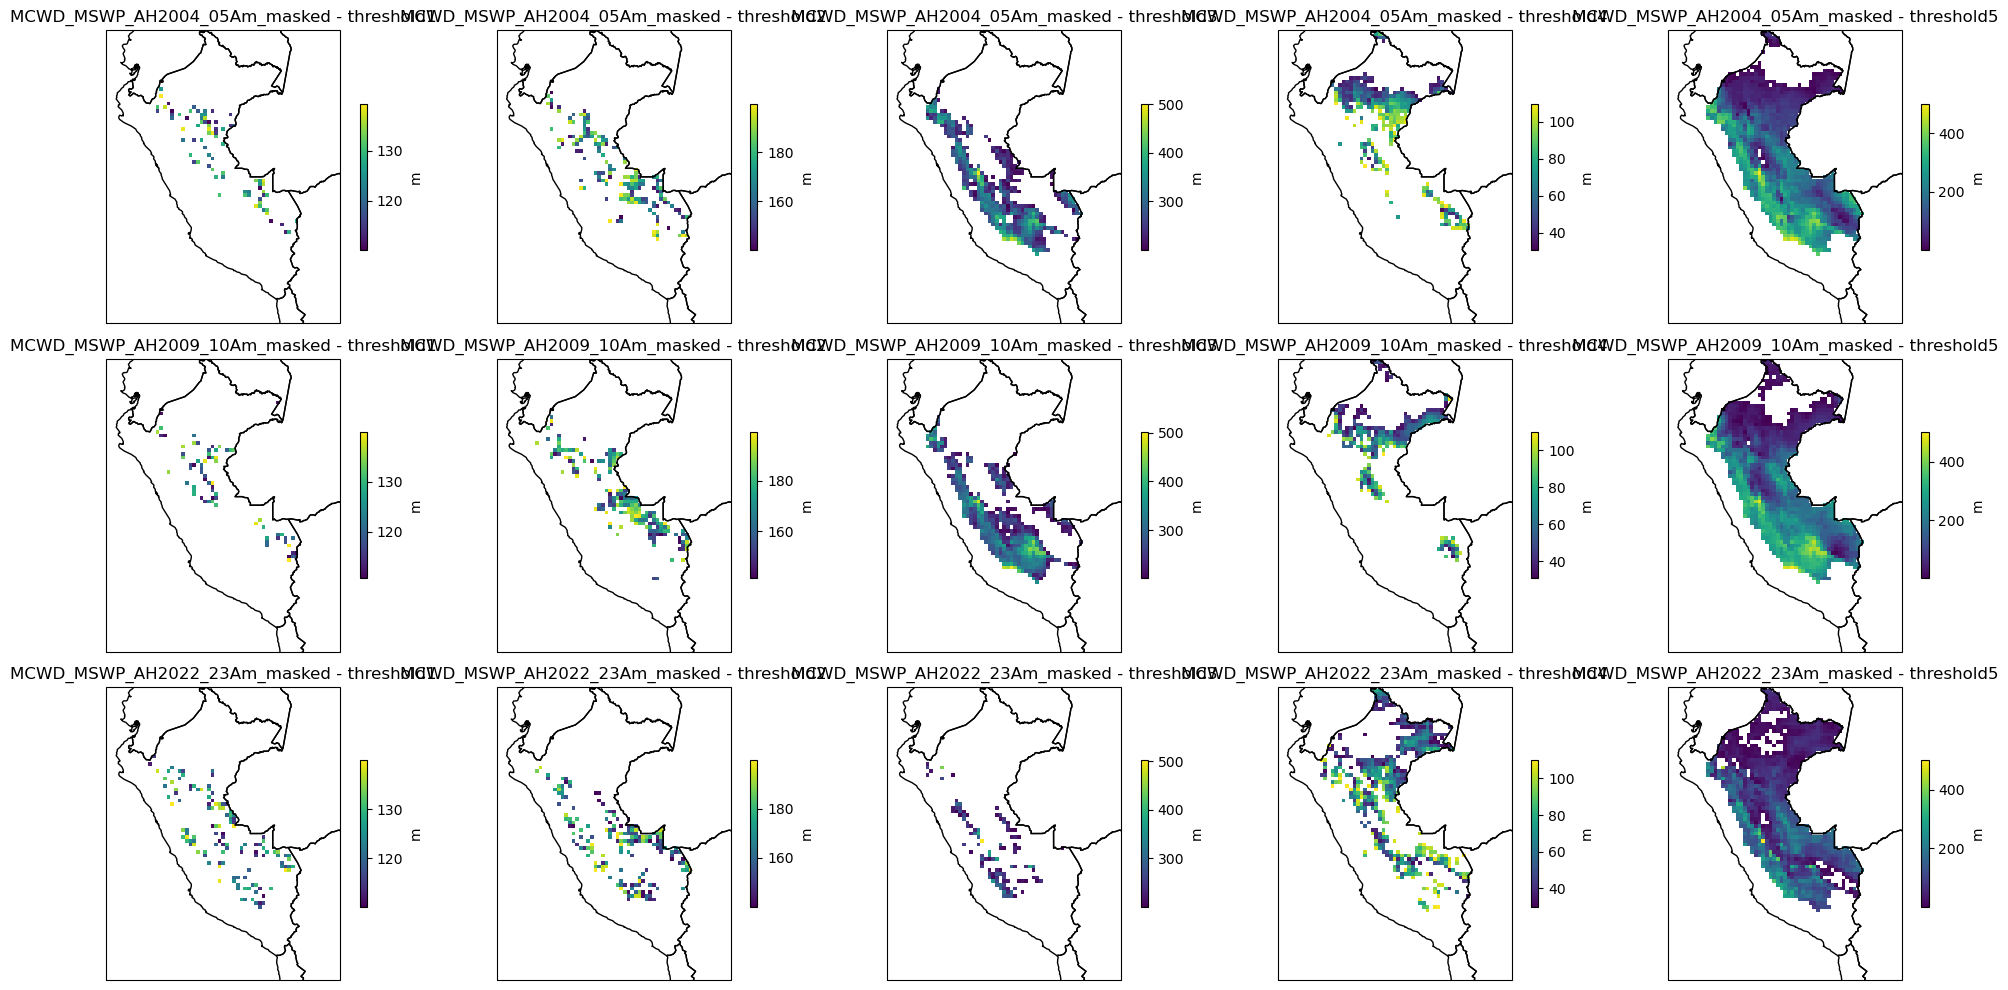

In [10]:
import xarray as xr
import geopandas as gpd
import rioxarray
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

# Definir rutas de datos y salida
data_dir = "NewData/CHIRPS_MWEP/MSWP"
output_dir = os.path.join(data_dir, "Results")
shapefile = '~/shp_mapa_paises_mundo_2014/Mapa_paises_mundo.shp'
filenames = ["MCWD_MSWP_AH2004_05Am_masked", "MCWD_MSWP_AH2009_10Am_masked", "MCWD_MSWP_AH2022_23Am_masked"]

# Crear directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

km = 111

def process_threshold(data, lower_bound, upper_bound=None):
    if upper_bound:
        mask = (data >= lower_bound) & (data <= upper_bound)
    else:
        mask = (data >= lower_bound)
    return xr.where(mask, data, 0)

def calculate_area(grid_res, km_factor):
    return grid_res**2 * km_factor**2

for file in filenames:
    print(f"Processing file: {file}")
    input_file = os.path.join(data_dir, f"{file}.nc")
    ds = xr.open_dataset(input_file)
    
    # Seleccionar la variable 'm'
    data = ds['m']

    # Promediar sobre la dimensión de tiempo si existe
    if 'time' in data.dims:
        data = data.mean(dim='time')

    # Definir los thresholds
    thresholds = {
        "threshold1": (110, 140),
        "threshold2": (140, 200),
        "threshold3": (200, None),
        "threshold4": (30, 110),
        "threshold5": (0, None)
    }

    result_df = pd.DataFrame(columns=['Threshold', 'GPoints', 'km2'])

    for i, (threshold_name, (lower, upper)) in enumerate(thresholds.items(), start=1):
        threshold_data = process_threshold(data, lower, upper)
        threshold_sum = threshold_data.sum(dim=['latitude', 'longitude'])
        threshold_area = calculate_area(ds.attrs.get('xinc', 1), km)
        threshold_km2 = threshold_sum * threshold_area
        threshold_data = threshold_data.where(threshold_data > 0)
        threshold_data.to_netcdf(os.path.join(output_dir, f"{threshold_name}_{file}.nc"))

        result_df = result_df.append({
            'Threshold': i,
            'GPoints': threshold_sum.values,
            'km2': threshold_km2.values
        }, ignore_index=True)

    result_df.to_csv(os.path.join(output_dir, f"{file}_results.csv"), index=False)

print("Processing complete.")

# Graficando resultados de Results
def ploteaMapaEnSubplot(ax, varname, shapefile, extent=[-82, -66, -20, 0]):
    dsT1 = xr.open_dataset(varname)
    dsT1 = dsT1.rio.write_crs("EPSG:4326")
    gdf = gpd.read_file(shapefile)
    peru_shape = gdf[gdf.COUNTRY == 'Peru'].geometry.unary_union
    masked_data = dsT1.rio.clip([peru_shape], drop=True)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    masked_data.where(masked_data.m.values > 0).m.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})

fig, axs = plt.subplots(len(filenames), len(thresholds), figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i, file in enumerate(filenames):
    for j, threshold in enumerate(thresholds.keys()):
        varname = os.path.join(output_dir, f"{threshold}_{file}.nc")
        ploteaMapaEnSubplot(axs[i, j], varname, shapefile)
        axs[i, j].set_title(f"{file} - {threshold}")
        axs[i, j].set_xlabel('Longitude')
        axs[i, j].set_ylabel('Latitude')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Plot.png'))
plt.show()


In [11]:
!ls NewData/CHIRPS_MWEP/MSWP/Results/*

NewData/CHIRPS_MWEP/MSWP/Results/MCWD_MSWP_AH2004_05Am_masked2_results.csv
NewData/CHIRPS_MWEP/MSWP/Results/MCWD_MSWP_AH2004_05Am_masked_results.csv
NewData/CHIRPS_MWEP/MSWP/Results/MCWD_MSWP_AH2009_10Am_masked2_results.csv
NewData/CHIRPS_MWEP/MSWP/Results/MCWD_MSWP_AH2009_10Am_masked_results.csv
NewData/CHIRPS_MWEP/MSWP/Results/MCWD_MSWP_AH2022_23Am_masked2_results.csv
NewData/CHIRPS_MWEP/MSWP/Results/MCWD_MSWP_AH2022_23Am_masked_results.csv
NewData/CHIRPS_MWEP/MSWP/Results/Plot.png
NewData/CHIRPS_MWEP/MSWP/Results/areas_por_umbral.xlsx
NewData/CHIRPS_MWEP/MSWP/Results/areas_por_umbral_y_tiempo-Copy1.xlsx
NewData/CHIRPS_MWEP/MSWP/Results/areas_por_umbral_y_tiempo.xlsx
NewData/CHIRPS_MWEP/MSWP/Results/tabla.xlsx
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked.nc
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked.tiff
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked2.nc
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCW

NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked.nc
60064.875
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked2.nc
60064.875
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2009_10Am_masked.nc
53904.375
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2009_10Am_masked2.nc
53904.375
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2022_23Am_masked.nc
96257.8125
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2022_23Am_masked2.nc
96257.8125
NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2004_05Am_masked.nc
125520.1875
NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2004_05Am_masked2.nc
125520.1875
NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2009_10Am_masked.nc
137841.1875
NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2009_10Am_masked2.nc
137841.1875
NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2022_23Am_masked.nc
133990.875
NewData/CHIRPS_MWEP/MSWP/Results/thres

/tmp/ipykernel_88479/3287451808.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2022_23Am_masked.nc
365009.625
NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2022_23Am_masked2.nc
365009.625
NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2004_05Am_masked.nc
830127.375
NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2004_05Am_masked2.nc
2513484.0
NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2009_10Am_masked.nc
836287.875
NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2009_10Am_masked2.nc
2513484.0
NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2022_23Am_masked.nc
857849.625
NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2022_23Am_masked2.nc
2513484.0


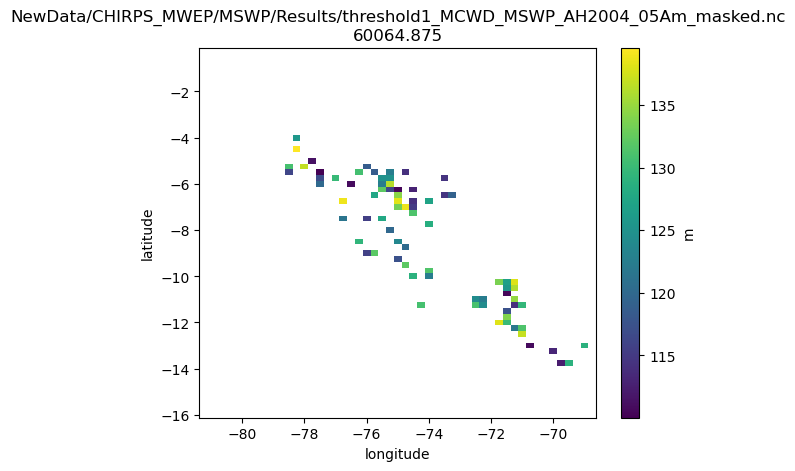

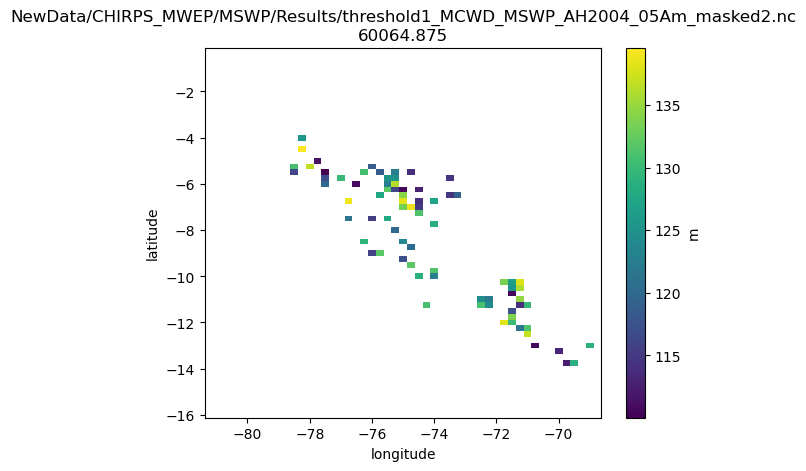

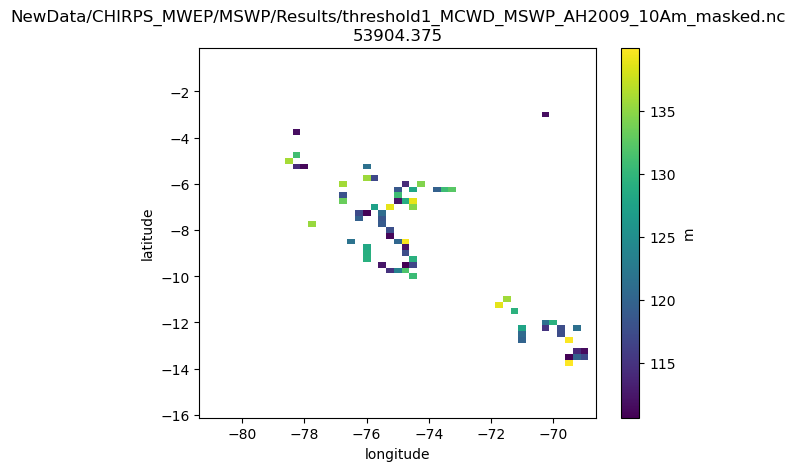

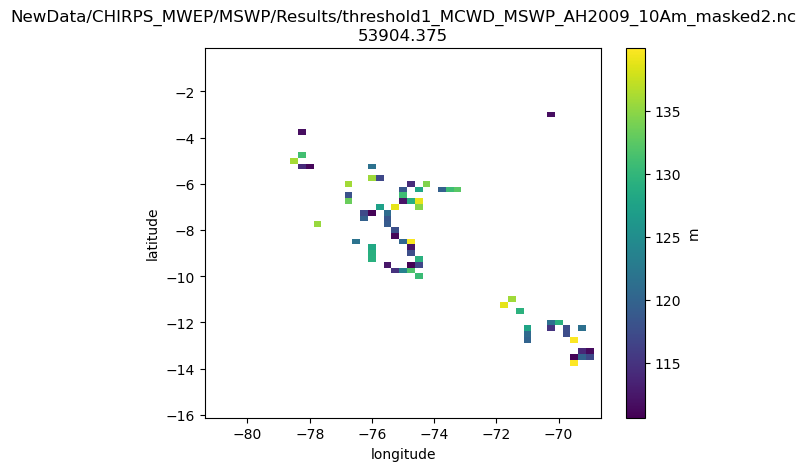

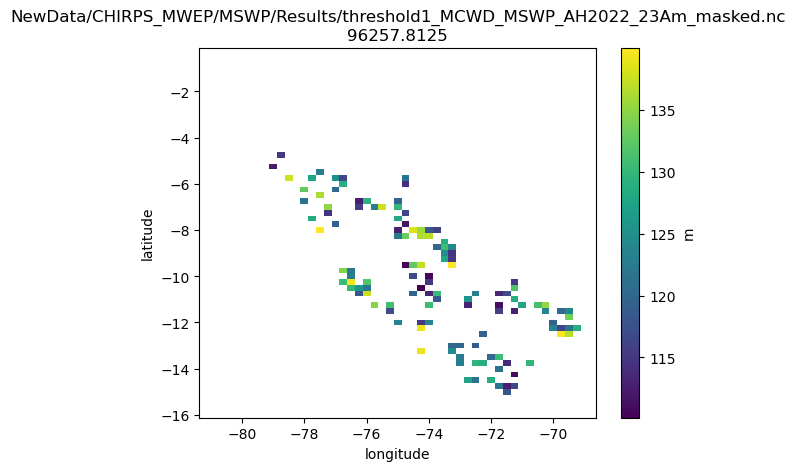

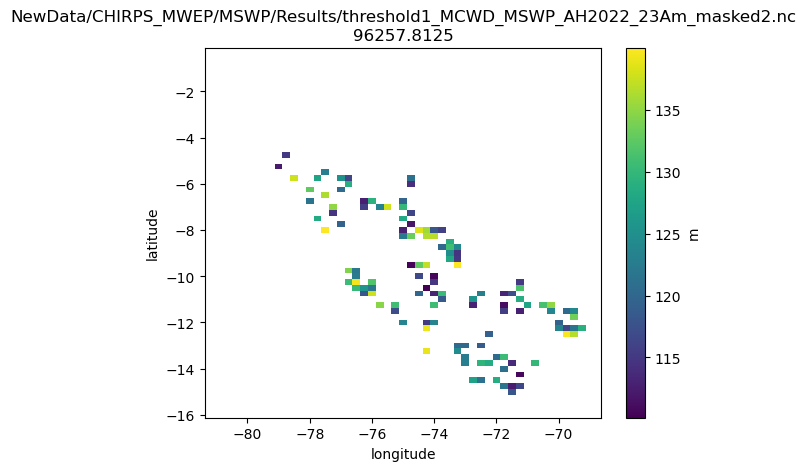

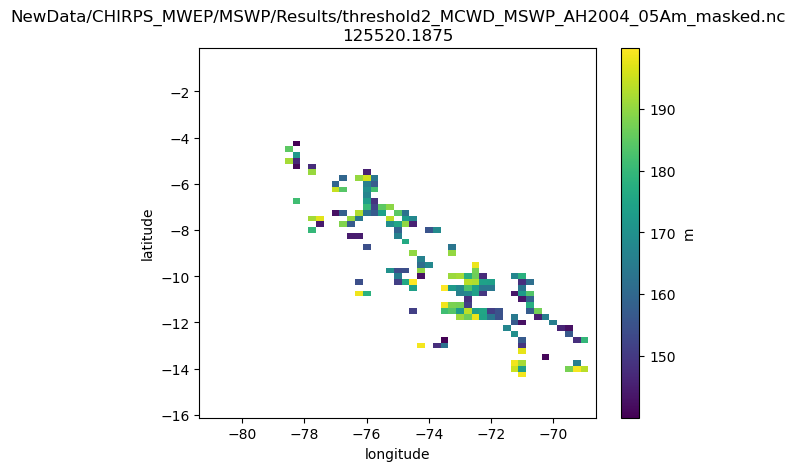

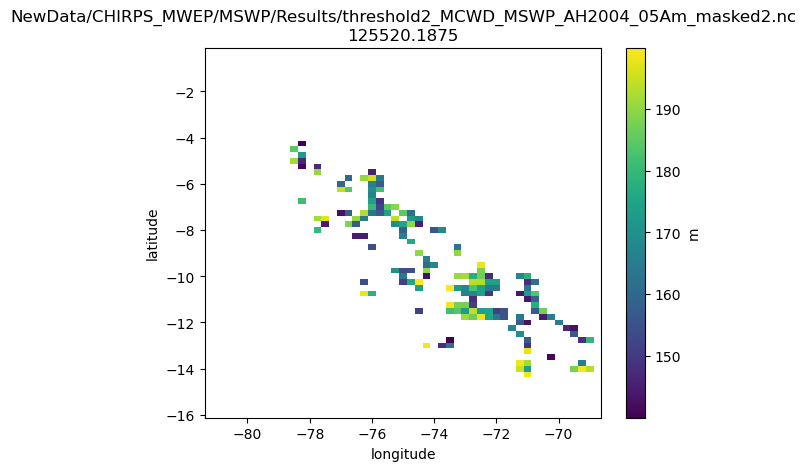

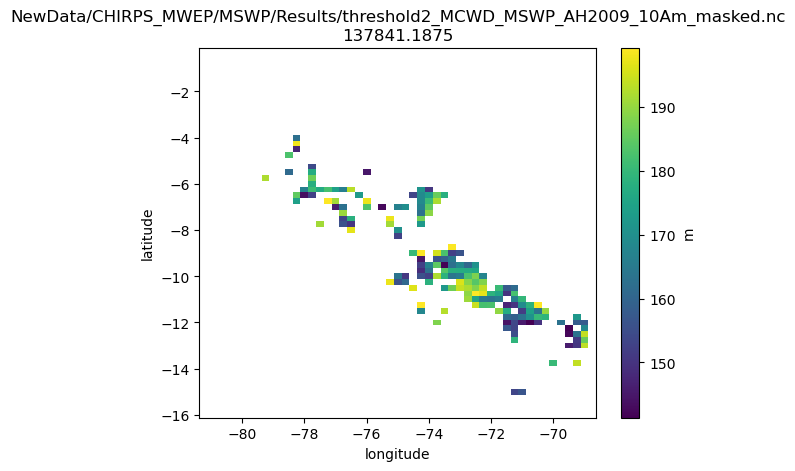

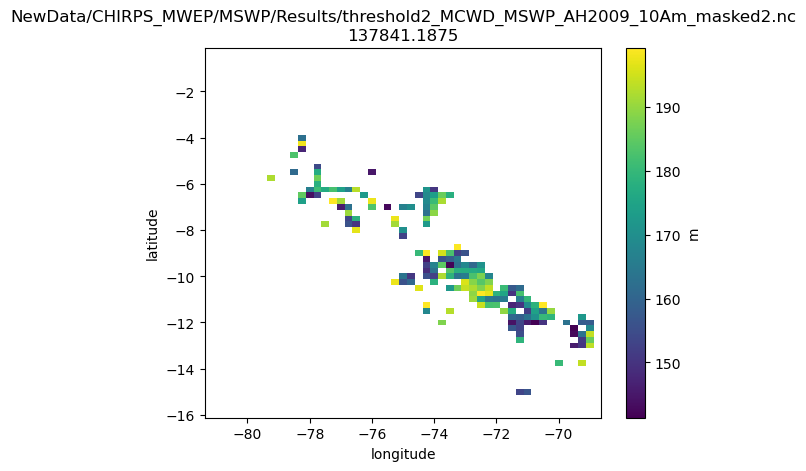

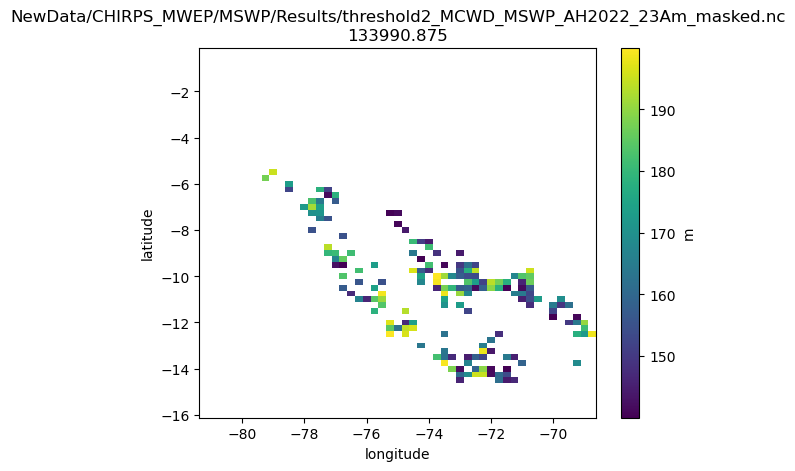

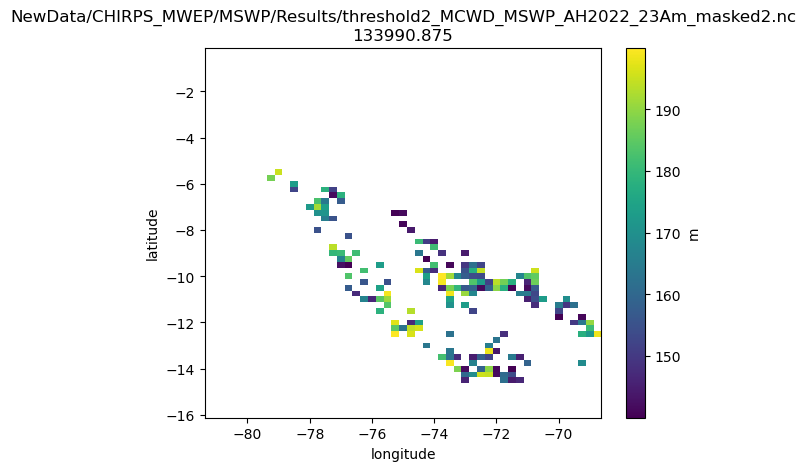

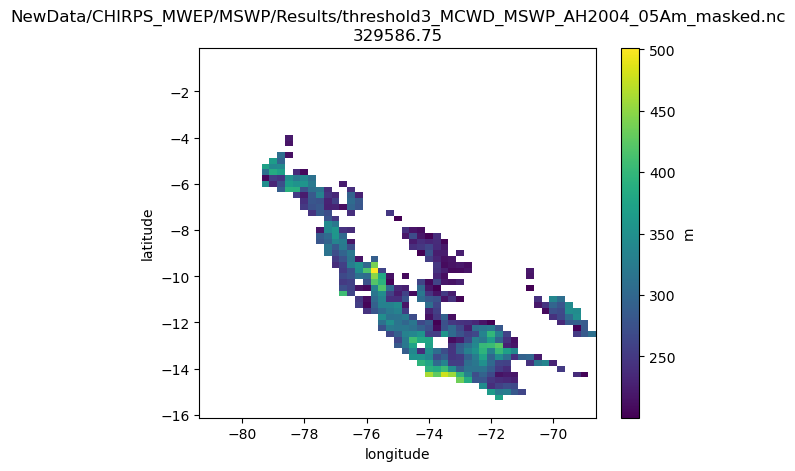

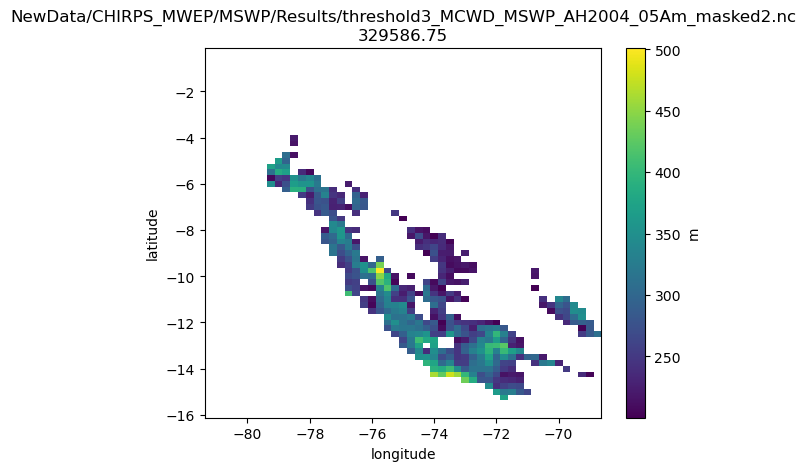

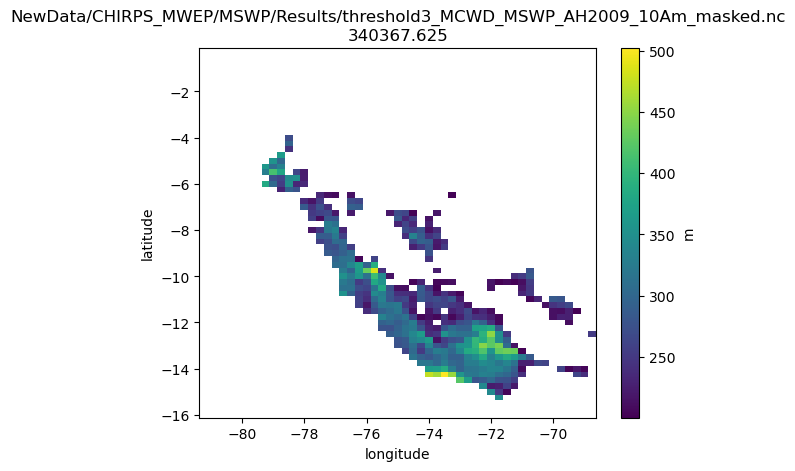

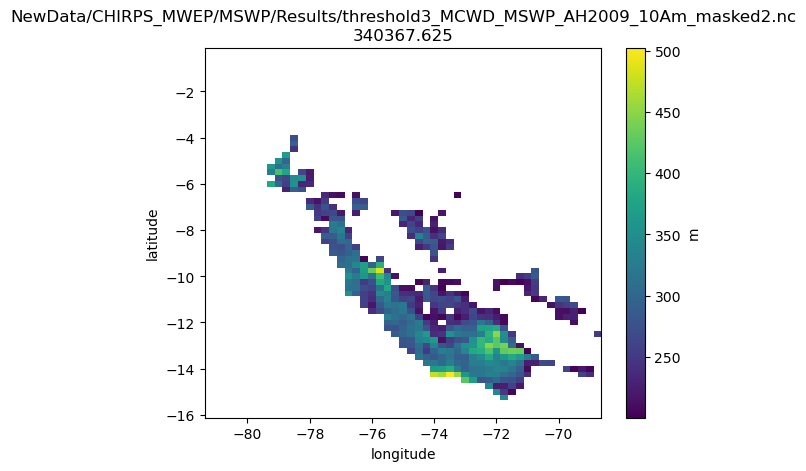

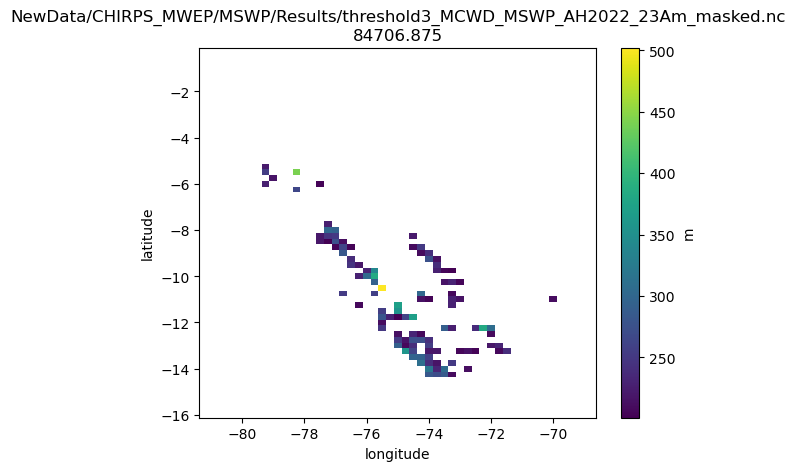

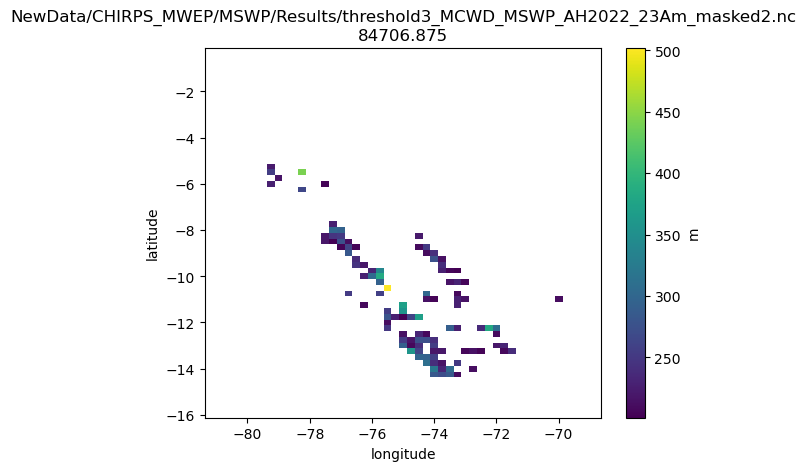

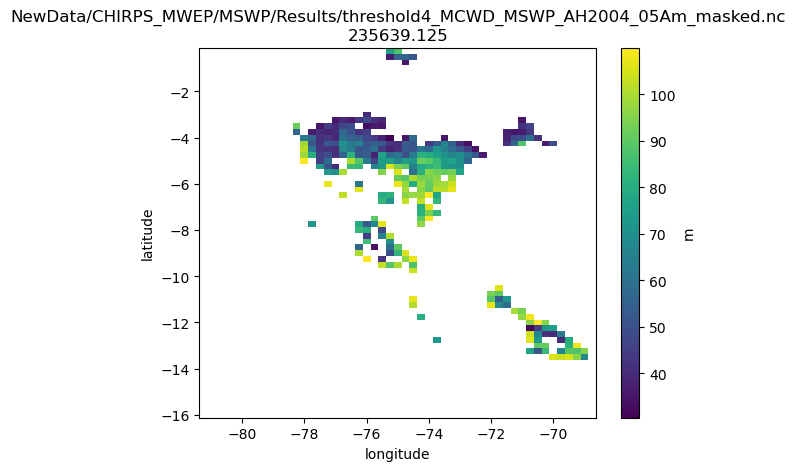

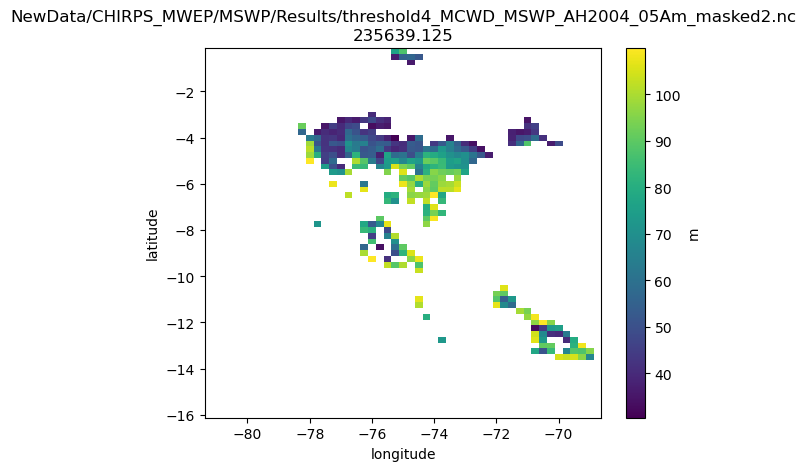

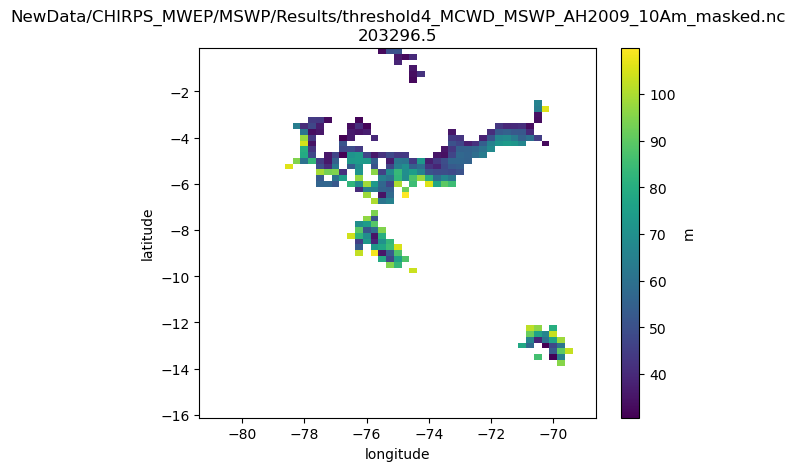

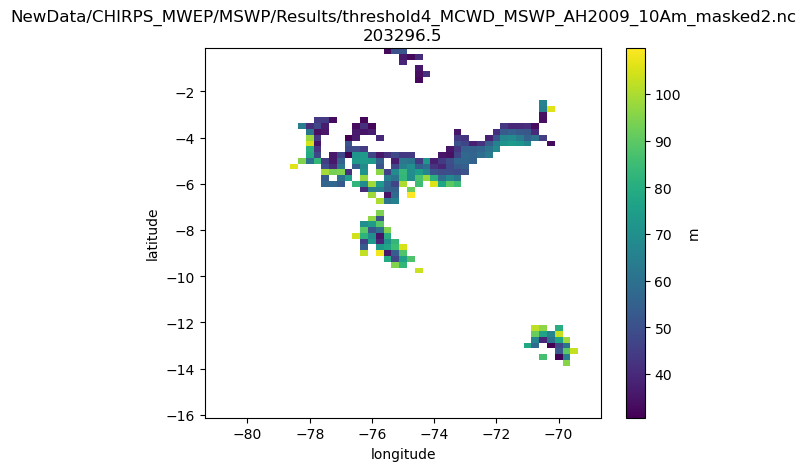

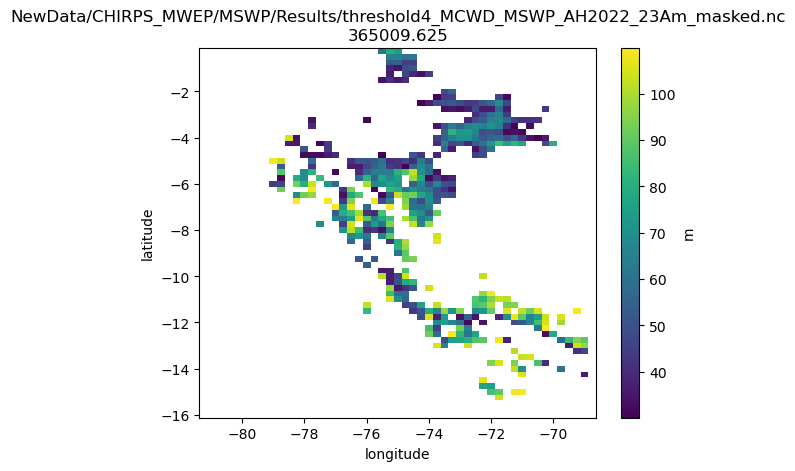

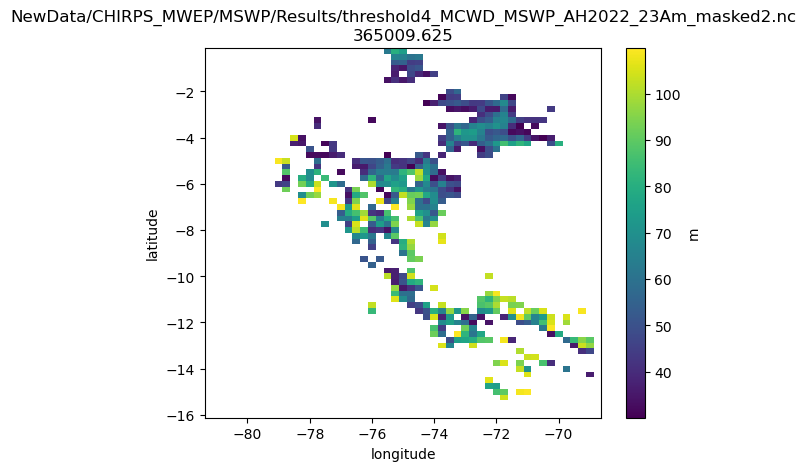

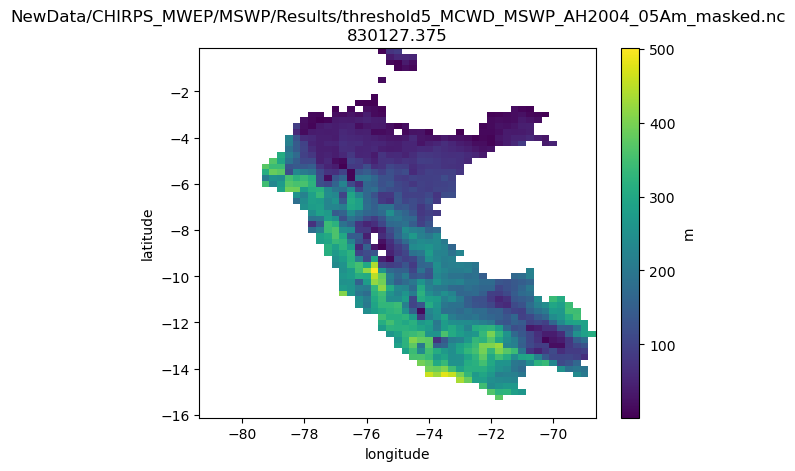

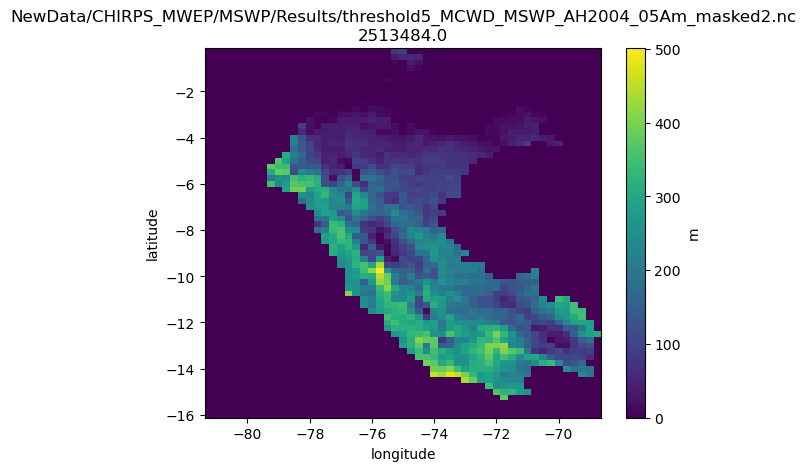

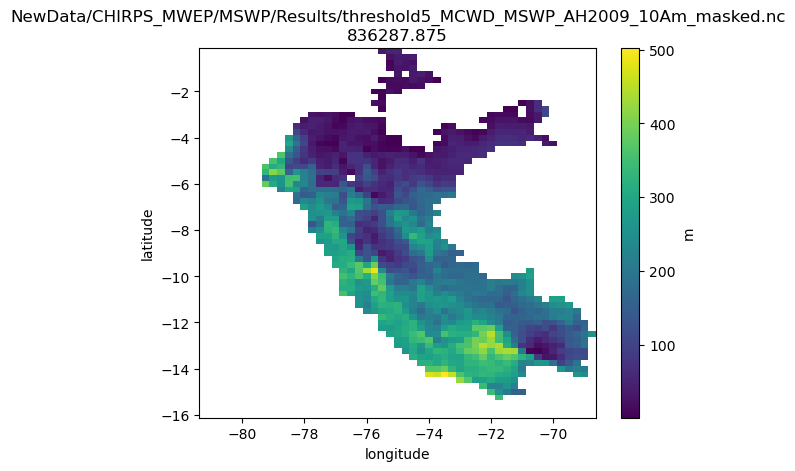

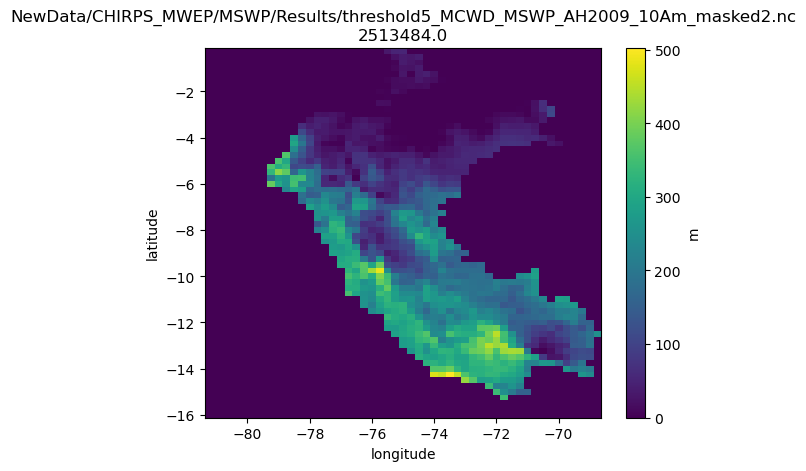

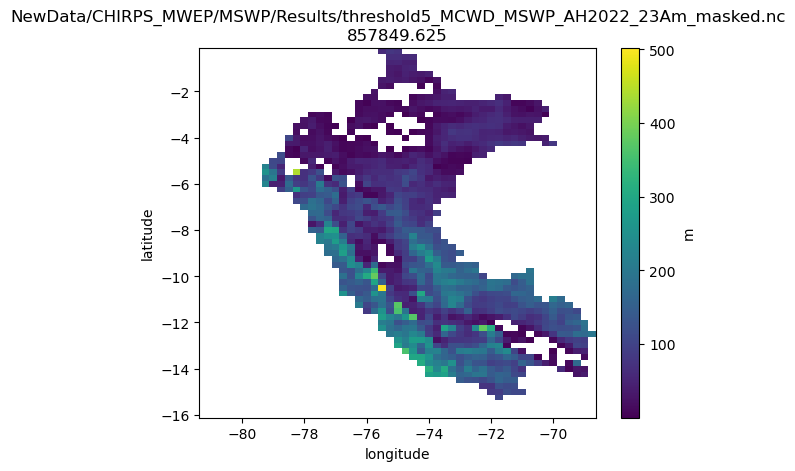

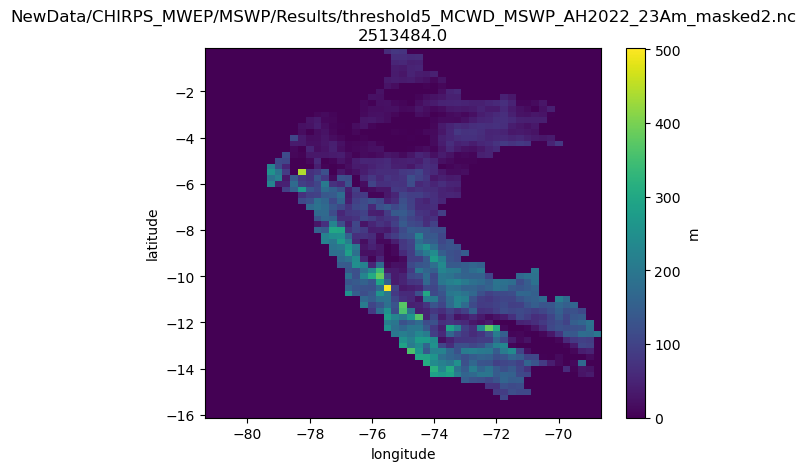

In [12]:
import xarray as xr
import pandas as pd
import os

# Función para calcular el área
def calculate_area(masked_data):
    """
    Calcula el área total del dataset enmascarado basado en su resolución.

    Parámetros:
    masked_data (xarray.Dataset): Dataset enmascarado.

    Retorna:
    total_area (float): Área total en kilómetros cuadrados.
    """
    res_lat = (masked_data.latitude[1] - masked_data.latitude[0]).values
    res_lon = (masked_data.longitude[1] - masked_data.longitude[0]).values
    area_per_cell = abs(res_lat * res_lon) * 111**2
    valid_cells = masked_data.notnull().sum().values
    total_area = valid_cells * area_per_cell
    return total_area

# Lista de archivos NetCDF
nc_files = [
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2009_10Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2009_10Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2022_23Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2022_23Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2004_05Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2004_05Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2009_10Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2009_10Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2022_23Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2022_23Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold3_MCWD_MSWP_AH2004_05Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold3_MCWD_MSWP_AH2004_05Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold3_MCWD_MSWP_AH2009_10Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold3_MCWD_MSWP_AH2009_10Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold3_MCWD_MSWP_AH2022_23Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold3_MCWD_MSWP_AH2022_23Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2004_05Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2004_05Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2009_10Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2009_10Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2022_23Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2022_23Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2004_05Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2004_05Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2009_10Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2009_10Am_masked2.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2022_23Am_masked.nc",
    "NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2022_23Am_masked2.nc"
]

# Crear un DataFrame vacío para almacenar los resultados
results = []

# Iterar sobre los archivos y calcular el área
for nc_file in nc_files:
    ds = xr.open_dataset(nc_file)
    plt.figure()
    ds.m.plot()
    
    total_area = calculate_area(ds['m'])
    plt.title(str(nc_file)+'\n'+str(total_area))
    # Extraer el nombre del threshold y archivo
    threshold = os.path.basename(nc_file).split('_')[0]
    file_name = os.path.basename(nc_file).split('_', 1)[1].replace('.nc', '')
    
    # Añadir los resultados al DataFrame
    results.append({
        "Threshold": threshold,
        "File": file_name,
        "Area_km2": total_area
    })
    print(nc_file)
    print(total_area)

# Convertir la lista de resultados a un DataFrame
df_results = pd.DataFrame(results)

# Ordenar el DataFrame por Threshold y File
df_results = df_results.sort_values(by=["Threshold", "File"])

# Mostrar el DataFrame resultante
# import ace_tools as tools; tools.display_dataframe_to_user(name="Resultados de Área por Threshold y Archivo", dataframe=df_results)
df_results.to_excel('NewData/CHIRPS_MWEP/MSWP/Results/tabla.xlsx')

NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2009_10Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2009_10Am_masked2.tiff
Área total de valores no nulos: 921956.5 km²
NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2004_05Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2004_05Am_masked2.tiff
Área total de valores no nulos: 921954.4 km²
NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am_masked2.tiff
Área total de valores no nulos: 921955.03 km²


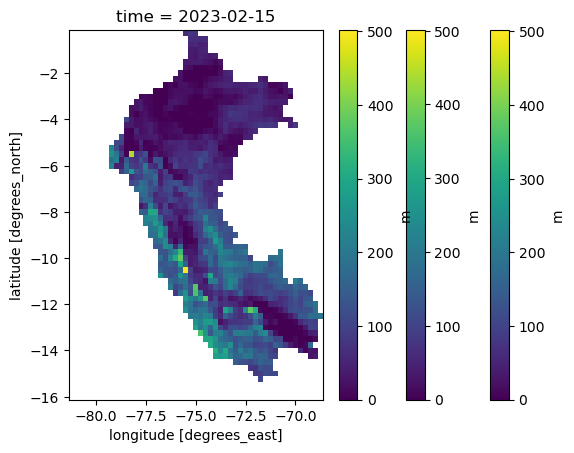

In [13]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np


def areaFromTifgeoref(file):
    def netcdf_to_geotiff(nc_file, output_tiff, var_name='m', crs="EPSG:4326"):
        """
        Convierte un archivo NetCDF con coordenadas lat/lon en un GeoTIFF.

        Parámetros:
        nc_file (str): Ruta al archivo NetCDF de entrada.
        output_tiff (str): Ruta de salida para el archivo GeoTIFF.
        var_name (str): Nombre de la variable dentro del NetCDF que se desea convertir. Por defecto 'm'.
        crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

        Retorna:
        None: Exporta el archivo GeoTIFF a la ubicación especificada.
        """
        # Cargar el dataset NetCDF
        ds = xr.open_dataset(nc_file)
        ds_var = ds[var_name]
        plt.plot()
        ds_var.plot()
        # Eliminar el atributo 'grid_mapping' si existe
        if 'grid_mapping' in ds_var.attrs:
            del ds_var.attrs['grid_mapping']

        # Configurar el CRS
        ds_var = ds_var.rio.write_crs(crs)
        ds_var = ds_var.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

        # Exportar a GeoTIFF
        ds_var.rio.to_raster(output_tiff)
        print(f"Archivo exportado a GeoTIFF: {output_tiff}")
    ##########################################################################################################
    # Ejemplo de uso
    nc_file = file  # Ruta del archivo NetCDF
    output_tiff = nc_file.replace('.nc', '.tiff')  # Ruta de salida para el GeoTIFF
    print(output_tiff)
    netcdf_to_geotiff(nc_file, output_tiff)

    import rasterio
    from rasterio.features import shapes
    import geopandas as gpd
    from shapely.geometry import shape

    # Abrir el archivo TIFF
    with rasterio.open(output_tiff) as src:
        # Leer la primera banda del raster
        band = src.read(1)
        # Generar geometrías a partir de los valores no nulos
        mask = band != src.nodata
        results = (
            {'properties': {'m': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(shapes(band, mask=mask, transform=src.transform))
        )

        # Convertir a GeoDataFrame
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)

    # Filtrar los valores no nulos
    gdf = gdf[gdf['m'] >= 0]

    # Asegurarse de que el GeoDataFrame esté en un sistema de coordenadas proyectadas (e.g., EPSG:32618)
    # Cambia el EPSG a uno que sea relevante para tu área de interés si no es el caso
    gdf = gdf.to_crs(epsg=32618)

    # Calcular el área total en metros cuadrados
    gdf['area_m2'] = gdf['geometry'].area

    # Convertir el área total a kilómetros cuadrados
    gdf['area_km2'] = gdf['area_m2'] / 1e6
    total_area_km2 = np.round(gdf['area_km2'].sum(),2)

    print(f'Área total de valores no nulos: {total_area_km2} km²')
    return total_area_km2
    #################################################################################################################

# areaFromTifgeoref('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am_masked2.nc')
# areaFromTifgeoref('NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked.nc')
# areaFromTifgeoref('NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked2.nc')

from glob import glob

files = glob('NewData/CHIRPS_MWEP/MSWP/*2.nc')
files 

for each in files:
    areaFromTifgeoref(each)

NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2009_10Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2009_10Am_masked2.tiff
Área total de valores no nulos: 201992.27 km²
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2009_10Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2009_10Am_masked2.tiff
Área total de valores no nulos: 53279.25 km²
NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2022_23Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2022_23Am_masked2.tiff
Área total de valores no nulos: 131707.22 km²
NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2009_10Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2009_10Am_masked2.tiff
Área total de valores no nulos: 2484459.28 km²
NewData/CHIRPS_MWEP/MSWP/Results/threshold3_MCWD_MSWP_AH2004_05Am_ma

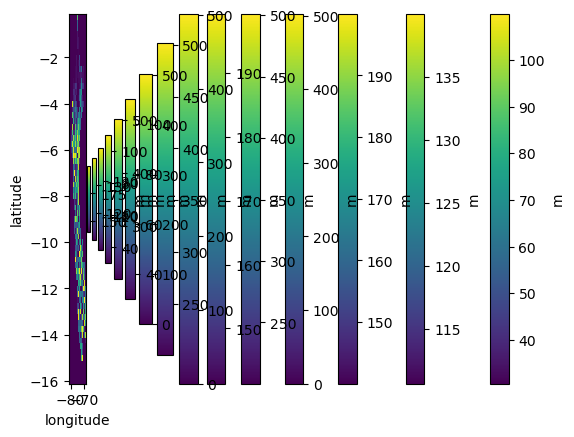

In [14]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from glob import glob

def areaFromTifgeoref(file):
    def netcdf_to_geotiff(nc_file, output_tiff, var_name='m', crs="EPSG:4326"):
        """
        Convierte un archivo NetCDF con coordenadas lat/lon en un GeoTIFF.

        Parámetros:
        nc_file (str): Ruta al archivo NetCDF de entrada.
        output_tiff (str): Ruta de salida para el archivo GeoTIFF.
        var_name (str): Nombre de la variable dentro del NetCDF que se desea convertir. Por defecto 'm'.
        crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

        Retorna:
        None: Exporta el archivo GeoTIFF a la ubicación especificada.
        """
        # Cargar el dataset NetCDF
        ds = xr.open_dataset(nc_file)
        ds_var = ds[var_name]
        plt.plot()
        ds_var.plot()
        # Eliminar el atributo 'grid_mapping' si existe
        if 'grid_mapping' in ds_var.attrs:
            del ds_var.attrs['grid_mapping']

        # Configurar el CRS
        ds_var = ds_var.rio.write_crs(crs)
        ds_var = ds_var.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

        # Exportar a GeoTIFF
        ds_var.rio.to_raster(output_tiff)
        print(f"Archivo exportado a GeoTIFF: {output_tiff}")
    ##########################################################################################################
    # Ejemplo de uso
    nc_file = file  # Ruta del archivo NetCDF
    output_tiff = nc_file.replace('.nc', '.tiff')  # Ruta de salida para el GeoTIFF
    print(output_tiff)
    netcdf_to_geotiff(nc_file, output_tiff)

    import rasterio
    from rasterio.features import shapes
    import geopandas as gpd
    from shapely.geometry import shape

    # Abrir el archivo TIFF
    with rasterio.open(output_tiff) as src:
        # Leer la primera banda del raster
        band = src.read(1)
        # Generar geometrías a partir de los valores no nulos
        mask = band != src.nodata
        results = (
            {'properties': {'m': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(shapes(band, mask=mask, transform=src.transform))
        )

        # Convertir a GeoDataFrame
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)

    # Filtrar los valores no nulos
    gdf = gdf[gdf['m'] >= 0]

    # Asegurarse de que el GeoDataFrame esté en un sistema de coordenadas proyectadas (e.g., EPSG:32618)
    # Cambia el EPSG a uno que sea relevante para tu área de interés si no es el caso
    gdf = gdf.to_crs(epsg=32618)

    # Calcular el área total en metros cuadrados
    gdf['area_m2'] = gdf['geometry'].area

    # Convertir el área total a kilómetros cuadrados
    gdf['area_km2'] = gdf['area_m2'] / 1e6
    total_area_km2 = np.round(gdf['area_km2'].sum(),2)

    print(f'Área total de valores no nulos: {total_area_km2} km²')
    return total_area_km2
    #################################################################################################################

# Obtener todos los archivos .nc en el directorio especificado
files = glob('NewData/CHIRPS_MWEP/MSWP/Results/*2.nc')

# Crear un diccionario para almacenar los resultados
resultados = {}

# Iterar sobre cada archivo y calcular el área
for each in files:
    umbral = each.split('/')[-1].split('_')[0]  # Extraer el umbral del nombre del archivo
    area = areaFromTifgeoref(each)
    if umbral not in resultados:
        resultados[umbral] = []
    resultados[umbral].append(area)

# Convertir el diccionario a un DataFrame
df_resultados = pd.DataFrame(resultados)

# Guardar los resultados en un archivo Excel o CSV
df_resultados.to_excel('NewData/CHIRPS_MWEP/MSWP/Results/areas_por_umbral.xlsx', index=False)
# df_resultados.to_csv('areas_por_umbral.csv', index=False)

print(df_resultados)


NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2009_10Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/Results/threshold4_MCWD_MSWP_AH2009_10Am_masked2.tiff
Área total de valores no nulos: 201992.27 km²
NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2009_10Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2009_10Am_masked2.tiff
Área total de valores no nulos: 53279.25 km²
NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2022_23Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/Results/threshold2_MCWD_MSWP_AH2022_23Am_masked2.tiff
Área total de valores no nulos: 131707.22 km²
NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2009_10Am_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/MSWP/Results/threshold5_MCWD_MSWP_AH2009_10Am_masked2.tiff
Área total de valores no nulos: 2484459.28 km²
NewData/CHIRPS_MWEP/MSWP/Results/threshold3_MCWD_MSWP_AH2004_05Am_ma

/tmp/ipykernel_5418/1365103862.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(['Threshold', 'Time']).sum().reset_index()


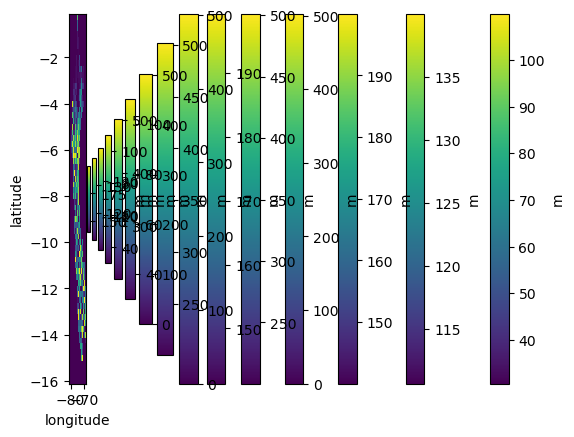

In [21]:
import pandas as pd
from glob import glob
import os

# Suponiendo que ya tienes la función `areaFromTifgeoref` definida y funciona correctamente

# Obtener la lista de archivos .nc
files = glob('NewData/CHIRPS_MWEP/MSWP/Results/*2.nc')

# Crear una lista para almacenar los resultados
results = []

# Calcular el área para cada archivo y almacenar los resultados
for each in files:
    area = areaFromTifgeoref(each)
    results.append({'File Name': each, 'Area (km²)': area})

# Convertir los resultados en un DataFrame
df = pd.DataFrame(results)

# Extraer solo el nombre del archivo (sin la ruta)
df['File Name'] = df['File Name'].apply(lambda x: os.path.basename(x))

# Extraer el umbral del nombre del archivo
df['Threshold'] = df['File Name'].apply(lambda x: int(x.split('_')[0].replace('threshold', '')))

# Extraer el tiempo de los nombres de archivo
def extract_time(file_name):
    # Partes del nombre del archivo separadas por '_'
    parts = file_name.split('_')
    # Buscar la parte que contenga 'Am' para obtener el tiempo
    for part in parts:
        if 'Am' in part:
            return int(part[:2])
    return None

df['Time'] = df['File Name'].apply(extract_time)

# Agrupar por Threshold y Time para sumar las áreas en caso de duplicados
df_grouped = df.groupby(['Threshold', 'Time']).sum().reset_index()

# Pivotar la tabla para que los umbrales queden como índices
df_pivot = df_grouped.pivot_table(index='Threshold', columns='Time', values='Area (km²)', aggfunc='sum')

# Reordenar las columnas para que estén en el orden 05, 10, 23
columns_order = [5, 10, 23]
df_pivot = df_pivot[columns_order]

# Renombrar las columnas
# df_pivot.columns = [f"Tiempo {str(col).zfill(2)}" for col in columns_order]

# Mostrar la tabla final
print(df_pivot.transpose())
df_pivot=df_pivot.transpose()
# Guardar en un archivo Excel si es necesario
df_pivot.to_excel("NewData/CHIRPS_MWEP/MSWP/Results/areas_por_umbral_y_tiempo.xlsx", index=True)


# PARA CHIRPS

NewData/CHIRPS_MWEP/CHIRPS/Results/threshold2_MCWD_CHIRPS_AH2022_23Am1Fix_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/CHIRPS/Results/threshold2_MCWD_CHIRPS_AH2022_23Am1Fix_masked2.tiff
Área total de valores no nulos: 175552.23 km²
NewData/CHIRPS_MWEP/CHIRPS/Results/threshold5_MCWD_CHIRPS_AH2009_10Am1Fix_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/CHIRPS/Results/threshold5_MCWD_CHIRPS_AH2009_10Am1Fix_masked2.tiff
Área total de valores no nulos: 2455336.59 km²
NewData/CHIRPS_MWEP/CHIRPS/Results/threshold1_MCWD_CHIRPS_AH2009_10Am1Fix_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/CHIRPS/Results/threshold1_MCWD_CHIRPS_AH2009_10Am1Fix_masked2.tiff
Área total de valores no nulos: 74156.15 km²
NewData/CHIRPS_MWEP/CHIRPS/Results/threshold1_MCWD_CHIRPS_AH2022_23Am1Fix_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/CHIRPS/Results/threshold1_MCWD_CHIRPS_AH2022_23Am1Fix_masked2.tiff
Área total de valores no nulos: 88591.01 km²
NewDa

/tmp/ipykernel_88479/3001990229.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(['Threshold', 'Time']).sum().reset_index()


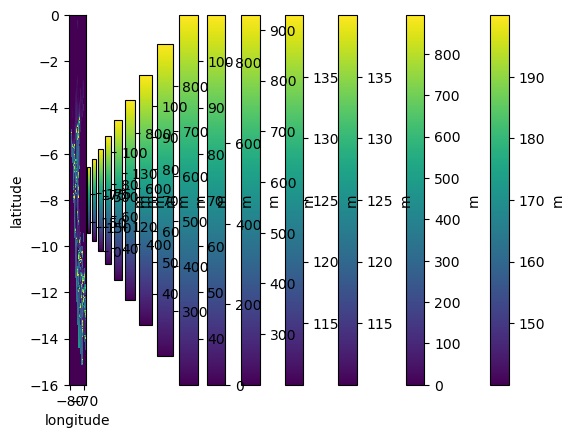

In [15]:
import pandas as pd
from glob import glob
import os

# Suponiendo que ya tienes la función `areaFromTifgeoref` definida y funciona correctamente

# Obtener la lista de archivos .nc
files = glob('NewData/CHIRPS_MWEP/CHIRPS/Results/*2.nc')

# Crear una lista para almacenar los resultados
results = []

# Calcular el área para cada archivo y almacenar los resultados
for each in files:
    area = areaFromTifgeoref(each)
    results.append({'File Name': each, 'Area (km²)': area})

# Convertir los resultados en un DataFrame
df = pd.DataFrame(results)

# Extraer solo el nombre del archivo (sin la ruta)
df['File Name'] = df['File Name'].apply(lambda x: os.path.basename(x))

# Extraer el umbral del nombre del archivo
df['Threshold'] = df['File Name'].apply(lambda x: int(x.split('_')[0].replace('threshold', '')))

# Extraer el tiempo de los nombres de archivo
def extract_time(file_name):
    # Partes del nombre del archivo separadas por '_'
    parts = file_name.split('_')
    # Buscar la parte que contenga 'Am' para obtener el tiempo
    for part in parts:
        if 'Am' in part:
            return int(part[:2])
    return None

df['Time'] = df['File Name'].apply(extract_time)

# Agrupar por Threshold y Time para sumar las áreas en caso de duplicados
df_grouped = df.groupby(['Threshold', 'Time']).sum().reset_index()

# Pivotar la tabla para que los umbrales queden como índices
df_pivot = df_grouped.pivot_table(index='Threshold', columns='Time', values='Area (km²)', aggfunc='sum')

# Reordenar las columnas para que estén en el orden 05, 10, 23
columns_order = [5, 10, 23]
df_pivot = df_pivot[columns_order]

# Renombrar las columnas
# df_pivot.columns = [f"Tiempo {str(col).zfill(2)}" for col in columns_order]

# Mostrar la tabla final
print(df_pivot.transpose())
df_pivot=df_pivot.transpose()
# Guardar en un archivo Excel si es necesario
df_pivot.to_excel("NewData/CHIRPS_MWEP/CHIRPS/Results/areas_por_umbral_y_tiempo.xlsx", index=True)


NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2022_23Am1Fix_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2022_23Am1Fix_masked2.tiff
Área total de valores no nulos: 939892.23 km²
NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2004_05Am1Fix_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2004_05Am1Fix_masked2.tiff
Área total de valores no nulos: 939892.42 km²
NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2009_10Am1Fix_masked2.tiff
Archivo exportado a GeoTIFF: NewData/CHIRPS_MWEP/CHIRPS/MCWD_CHIRPS_AH2009_10Am1Fix_masked2.tiff
Área total de valores no nulos: 939892.32 km²


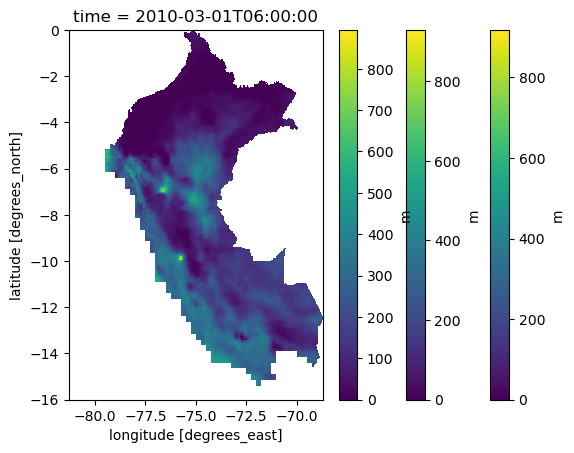

In [16]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np


def areaFromTifgeoref(file):
    def netcdf_to_geotiff(nc_file, output_tiff, var_name='m', crs="EPSG:4326"):
        """
        Convierte un archivo NetCDF con coordenadas lat/lon en un GeoTIFF.

        Parámetros:
        nc_file (str): Ruta al archivo NetCDF de entrada.
        output_tiff (str): Ruta de salida para el archivo GeoTIFF.
        var_name (str): Nombre de la variable dentro del NetCDF que se desea convertir. Por defecto 'm'.
        crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

        Retorna:
        None: Exporta el archivo GeoTIFF a la ubicación especificada.
        """
        # Cargar el dataset NetCDF
        ds = xr.open_dataset(nc_file)
        ds_var = ds[var_name]
        plt.plot()
        ds_var.plot()
        # Eliminar el atributo 'grid_mapping' si existe
        if 'grid_mapping' in ds_var.attrs:
            del ds_var.attrs['grid_mapping']

        # Configurar el CRS
        ds_var = ds_var.rio.write_crs(crs)
        ds_var = ds_var.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

        # Exportar a GeoTIFF
        ds_var.rio.to_raster(output_tiff)
        print(f"Archivo exportado a GeoTIFF: {output_tiff}")
    ##########################################################################################################
    # Ejemplo de uso
    nc_file = file  # Ruta del archivo NetCDF
    output_tiff = nc_file.replace('.nc', '.tiff')  # Ruta de salida para el GeoTIFF
    print(output_tiff)
    netcdf_to_geotiff(nc_file, output_tiff)

    import rasterio
    from rasterio.features import shapes
    import geopandas as gpd
    from shapely.geometry import shape

    # Abrir el archivo TIFF
    with rasterio.open(output_tiff) as src:
        # Leer la primera banda del raster
        band = src.read(1)
        # Generar geometrías a partir de los valores no nulos
        mask = band != src.nodata
        results = (
            {'properties': {'m': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(shapes(band, mask=mask, transform=src.transform))
        )

        # Convertir a GeoDataFrame
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)

    # Filtrar los valores no nulos
    gdf = gdf[gdf['m'] >= 0]

    # Asegurarse de que el GeoDataFrame esté en un sistema de coordenadas proyectadas (e.g., EPSG:32618)
    # Cambia el EPSG a uno que sea relevante para tu área de interés si no es el caso
    gdf = gdf.to_crs(epsg=32618)

    # Calcular el área total en metros cuadrados
    gdf['area_m2'] = gdf['geometry'].area

    # Convertir el área total a kilómetros cuadrados
    gdf['area_km2'] = gdf['area_m2'] / 1e6
    total_area_km2 = np.round(gdf['area_km2'].sum(),2)

    print(f'Área total de valores no nulos: {total_area_km2} km²')
    return total_area_km2
    #################################################################################################################

# areaFromTifgeoref('NewData/CHIRPS_MWEP/MSWP/MCWD_MSWP_AH2022_23Am_masked2.nc')
# areaFromTifgeoref('NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked.nc')
# areaFromTifgeoref('NewData/CHIRPS_MWEP/MSWP/Results/threshold1_MCWD_MSWP_AH2004_05Am_masked2.nc')

from glob import glob

files = glob('NewData/CHIRPS_MWEP/CHIRPS/*2.nc')
files 

for each in files:
    areaFromTifgeoref(each)

# era5

ERA_masked/Results/threshold5_ERA_MCWD_AH2004_05Am_masked_peru2.tiff
FrozenMappingWarningOnValuesAccess({'longitude': 127, 'latitude': 160})
Archivo exportado a GeoTIFF: ERA_masked/Results/threshold5_ERA_MCWD_AH2004_05Am_masked_peru2.tiff
Área total de valores no nulos: 2474825.6 km²
ERA_masked/Results/threshold3_ERA5_MCWD_AH2022_23Am_masked_peru2.tiff
FrozenMappingWarningOnValuesAccess({'longitude': 51, 'latitude': 64, 'expver': 1})
Archivo exportado a GeoTIFF: ERA_masked/Results/threshold3_ERA5_MCWD_AH2022_23Am_masked_peru2.tiff
Área total de valores no nulos: 31884.74 km²
ERA_masked/Results/threshold1_ERA5_MCWD_AH2022_23Am_masked_peru2.tiff
FrozenMappingWarningOnValuesAccess({'longitude': 51, 'latitude': 64, 'expver': 1})
Archivo exportado a GeoTIFF: ERA_masked/Results/threshold1_ERA5_MCWD_AH2022_23Am_masked_peru2.tiff
Área total de valores no nulos: 136177.93 km²
ERA_masked/Results/threshold4_ERA_MCWD_AH2009_10Am_masked_peru2.tiff
FrozenMappingWarningOnValuesAccess({'longitude': 12

/tmp/ipykernel_88479/4259833888.py:108: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(['Threshold', 'Time']).sum().reset_index()


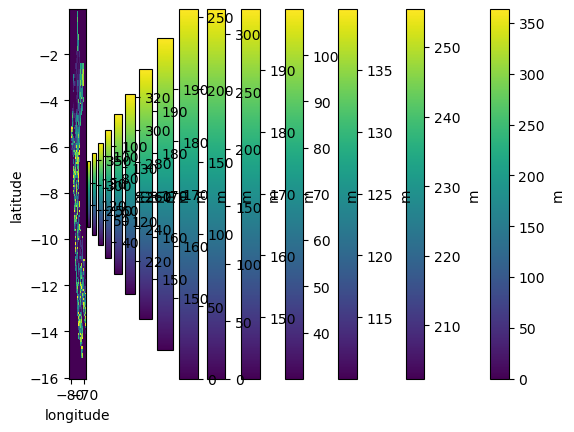

In [17]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from glob import glob
import os

def areaFromTifgeoref(file):
    def netcdf_to_geotiff(nc_file, output_tiff, var_name='m', crs="EPSG:4326"):
        # Cargar el dataset NetCDF
        ds = xr.open_dataset(nc_file)
        print(ds.dims)
        ds_var = ds[var_name]
        plt.plot()
        ds_var.plot()
        # Eliminar el atributo 'grid_mapping' si existe
        if 'grid_mapping' in ds_var.attrs:
            del ds_var.attrs['grid_mapping']

        # Configurar el CRS
        ds_var = ds_var.rio.write_crs(crs)
        ds_var = ds_var.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

        # Exportar a GeoTIFF
        ds_var.rio.to_raster(output_tiff)
        print(f"Archivo exportado a GeoTIFF: {output_tiff}")

    # Convertir el archivo NetCDF a GeoTIFF
    nc_file = file  
    output_tiff = nc_file.replace('.nc', '.tiff')
    print(output_tiff)
    netcdf_to_geotiff(nc_file, output_tiff)

    import rasterio
    from rasterio.features import shapes
    from shapely.geometry import shape

    # Abrir el archivo TIFF
    with rasterio.open(output_tiff) as src:
        # Leer la primera banda del raster
        band = src.read(1)
        
        # Convertir el tipo de dato a float32 si es necesario
        if band.dtype not in ['int16', 'int32', 'uint8', 'uint16', 'float32']:
            band = band.astype('float32')

        # Generar geometrías a partir de los valores no nulos
        mask = band != src.nodata
        results = (
            {'properties': {'m': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(shapes(band, mask=mask, transform=src.transform))
        )

        # Convertir a GeoDataFrame
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)

    # Filtrar los valores no nulos
    gdf = gdf[gdf['m'] >= 0]

    # Asegurarse de que el GeoDataFrame esté en un sistema de coordenadas proyectadas (e.g., EPSG:32618)
    gdf = gdf.to_crs(epsg=32618)

    # Calcular el área total en metros cuadrados
    gdf['area_m2'] = gdf['geometry'].area

    # Convertir el área total a kilómetros cuadrados
    gdf['area_km2'] = gdf['area_m2'] / 1e6
    total_area_km2 = np.round(gdf['area_km2'].sum(), 2)

    print(f'Área total de valores no nulos: {total_area_km2} km²')
    return total_area_km2

# Obtener la lista de archivos .nc
files = glob('ERA_masked/Results/*2.nc')

# Crear una lista para almacenar los resultados
results = []

# Calcular el área para cada archivo y almacenar los resultados
for each in files:
    area = areaFromTifgeoref(each)
    results.append({'File Name': each, 'Area (km²)': area})

# Convertir los resultados en un DataFrame
df = pd.DataFrame(results)

# Extraer solo el nombre del archivo (sin la ruta)
df['File Name'] = df['File Name'].apply(lambda x: os.path.basename(x))

# Extraer el umbral del nombre del archivo
df['Threshold'] = df['File Name'].apply(lambda x: int(x.split('_')[0].replace('threshold', '')))

# Extraer el tiempo de los nombres de archivo
def extract_time(file_name):
    parts = file_name.split('_')
    for part in parts:
        if 'Am' in part:
            return int(part[:2])
    return None

df['Time'] = df['File Name'].apply(extract_time)

# Agrupar por Threshold y Time para sumar las áreas en caso de duplicados
df_grouped = df.groupby(['Threshold', 'Time']).sum().reset_index()

# Pivotar la tabla para que los umbrales queden como índices
df_pivot = df_grouped.pivot_table(index='Threshold', columns='Time', values='Area (km²)', aggfunc='sum')

# Reordenar las columnas para que estén en el orden 05, 10, 23
columns_order = [5, 10, 23]
df_pivot = df_pivot[columns_order]

# Transponer la tabla para que los umbrales estén en las filas
df_pivot = df_pivot.transpose()

# Mostrar la tabla final
print(df_pivot)

# Guardar en un archivo Excel si es necesario
df_pivot.to_excel("ERA_masked/Results/areas_por_umbral_y_tiempo.xlsx", index=True)


ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru2.tiff
Archivo exportado a GeoTIFF: ERA_masked/ERA5_MCWD_AH2022_23Am_masked_peru2.tiff
Área total de valores no nulos: 921952.59 km²
ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru2.tiff
Archivo exportado a GeoTIFF: ERA_masked/ERA_MCWD_AH2009_10Am_masked_peru2.tiff
Área total de valores no nulos: 931918.56 km²
ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru2.tiff
Archivo exportado a GeoTIFF: ERA_masked/ERA_MCWD_AH2004_05Am_masked_peru2.tiff
Área total de valores no nulos: 931922.84 km²


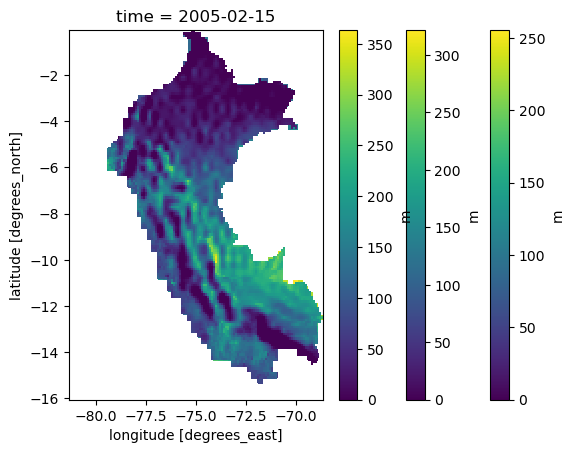

In [18]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

def areaFromTifgeoref(file):
    def netcdf_to_geotiff(nc_file, output_tiff, var_name='m', crs="EPSG:4326"):
        """
        Convierte un archivo NetCDF con coordenadas lat/lon en un GeoTIFF.

        Parámetros:
        nc_file (str): Ruta al archivo NetCDF de entrada.
        output_tiff (str): Ruta de salida para el archivo GeoTIFF.
        var_name (str): Nombre de la variable dentro del NetCDF que se desea convertir. Por defecto 'm'.
        crs (str): Sistema de referencia de coordenadas a usar. Por defecto "EPSG:4326".

        Retorna:
        None: Exporta el archivo GeoTIFF a la ubicación especificada.
        """
        # Cargar el dataset NetCDF
        ds = xr.open_dataset(nc_file)
        ds_var = ds[var_name]

        # Verificar el número de dimensiones y seleccionar una si es necesario
        if 'time' in ds_var.dims:
            ds_var = ds_var.isel(time=0)  # Selecciona la primera capa de tiempo, ajusta según tus necesidades
        
        plt.plot()
        ds_var.plot()
        
        # Eliminar el atributo 'grid_mapping' si existe
        if 'grid_mapping' in ds_var.attrs:
            del ds_var.attrs['grid_mapping']

        # Configurar el CRS
        ds_var = ds_var.rio.write_crs(crs)
        ds_var = ds_var.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

        # Exportar a GeoTIFF
        ds_var.rio.to_raster(output_tiff)
        print(f"Archivo exportado a GeoTIFF: {output_tiff}")

    # Ejemplo de uso
    nc_file = file  # Ruta del archivo NetCDF
    output_tiff = nc_file.replace('.nc', '.tiff')  # Ruta de salida para el GeoTIFF
    print(output_tiff)
    netcdf_to_geotiff(nc_file, output_tiff)

    import rasterio
    from rasterio.features import shapes
    import geopandas as gpd
    from shapely.geometry import shape

    # Abrir el archivo TIFF
    with rasterio.open(output_tiff) as src:
        # Leer la primera banda del raster
        band = src.read(1)
        
        # Convertir el tipo de dato a float32 si es necesario
        if band.dtype not in ['int16', 'int32', 'uint8', 'uint16', 'float32']:
            band = band.astype('float32')

        # Generar geometrías a partir de los valores no nulos
        mask = band != src.nodata
        results = (
            {'properties': {'m': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(shapes(band, mask=mask, transform=src.transform))
        )

        # Convertir a GeoDataFrame
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)

    # Filtrar los valores no nulos
    gdf = gdf[gdf['m'] >= 0]

    # Asegurarse de que el GeoDataFrame esté en un sistema de coordenadas proyectadas (e.g., EPSG:32618)
    gdf = gdf.to_crs(epsg=32618)

    # Calcular el área total en metros cuadrados
    gdf['area_m2'] = gdf['geometry'].area

    # Convertir el área total a kilómetros cuadrados
    gdf['area_km2'] = gdf['area_m2'] / 1e6
    total_area_km2 = np.round(gdf['area_km2'].sum(),2)

    print(f'Área total de valores no nulos: {total_area_km2} km²')
    return total_area_km2

from glob import glob

files = glob('ERA_masked/*2.nc')
files 

for each in files:
    areaFromTifgeoref(each)
